# Library Load

In [550]:
import pandas as pd
import numpy as np
import prince
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib import font_manager as fm
import matplotlib.cm as cm
import json
import requests
from adjustText import adjust_text
import geopandas as gpd
from tqdm import tqdm
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import math
from scipy import stats
import textwrap
from sklearn.preprocessing import MinMaxScaler
from adjustText import adjust_text

# 폰트 경로 직접 지정
font_path = r"C:\Windows\Fonts\malgun.ttf"  # Malgun Gothic 경로
fontprop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = fontprop.get_name()
plt.rcParams['axes.unicode_minus'] = False
# ---------------------------
# 0. 한글 깨짐 방지 설정
# ---------------------------
plt.rcParams['font.family'] = 'Malgun Gothic'   # Windows (맑은고딕)
# Mac 사용자라면 → 'AppleGothic'
# plt.rcParams['font.family'] = 'AppleGothic'

plt.rcParams['axes.unicode_minus'] = False       # 마이너스 기호 깨짐 방지

# Functions

In [267]:
variable_groups = {
    "기본사항": ['성별', '지역','나이','세대'],
    "인구사회적_특성": ['가구원수','혼인상태', '자녀여부', '종교', '고용상태', '가구소득', '소득변화', '학벌','소득수준'],
    "기부실태": ['채널','기부분야','국내의 사회복지 또는 자선 분야_기부액', '해외구호 분야_기부액', '초/중/고/대학교 교육분야_기부액',
       '의료분야_기부액', '문화예술분야_기부액', 'NGO분야_기부액', '환경/기후관련 분야_기부액', '동물보호 분야_기부액',
       '지역사회발전 분야_기부액', '기타_기부액','국내의 사회복지 또는 자선 분야','해외구호 분야','초/중/고/대학교 교육분야','의료분야',
     '문화예술분야','NGO분야','환경/기후관련 분야','동물보호 분야','지역사회발전 분야','기타분야','정기기부_횟수', '일시기부_횟수','기부관련활동'
     ,'작년기부액', '기부동기', '단체선정기준'],
     "비영리 기부단체에 대한 인식":["활동_의사소통_투명성",
    "비전_목표_제시",
    "재정정보_공개",
    "사업수행_정보공개",
    "운영정보_공개",
    "다양한_정보공개수단",
    "시민_의견제시수단",
    "문의사항_정확응답",
    "시민의견_반영",
    "법률준수",
    "사회발전_기여",
    "기부금_적절사용",
    "모금활동_적절성",
    "윤리적_운영",
    "전반적_신뢰도",
    "정부기업_대체역할",
    "취약계층_지원",
    "삶의질_향상",
    "운영비_인건비_과다사용",
    "사회이슈_해결기여",
    "공익_대변",
    "특정집단_대변"],
    "기부로 인한 임팩트":['기부만족_전반',
       '기부만족_기대충족', '기부자지향성_관심도', '기부자지향성_관계형성', '기부자지향성_장기관계', '기부자지향성_욕구파악',
       '기부충성도_재기부의향', '기부충성도_증액의향', '기부충성도_추천의향', '기부충성도_최우선기부','기부노력시간',
       '기부단체효과성','기부_긍정영향',
       '기부_도움제공', '기부_삶변화', '기부_사회임팩트', '기부_참여확산', '기부_책임성제고', '기부_정부보완',
       '기부_사회인식제고','사회변화도', '정보요청', '관심표현'],
    "기부환경에_대한_인식": ['미래전망', '기부수준인식', '기부수준_낮은이유','비용상한선여부',
       '상한선이유', '상한선배제이유', '추가지출여부_행정비용', '추가지출여부_성과측정', '추가지출여부_IT비용'],
    "자워봉사_실태": [ '자원봉사여부', '자원봉사시간'],
    "고향사랑기부제":['고향사랑기부제여부', '고향사랑기부제_사용여부', '고향사랑기부제_영향력'],
    "종교적_기부":['종교기부여부', '종교기부금액']
}

In [107]:
def make_y_simple(row):
    # 문1: 작년기부여부
    last_year = row['기부여부']
    # 문2-2: 작년전 기부여부
    prev_year = row['예전기부여부']

    # 케이스 매핑
    if last_year == 1:
        return '작년기부'   # 충성 기부자
    elif last_year == 2 and prev_year == 1:
        return '기부중단'   # 기부중단자
    elif last_year == 2 and prev_year == 2:
        return '비기부'   # 비기부자

In [108]:
def clean_list_value(x):
    # 1) 빈 리스트 → 0
    if isinstance(x, list) and len(x) == 0:
        return 0
    
    # 2) 리스트 안에 문자열이 존재하면 -> 리스트 제거하고 문자열로 변환
    if isinstance(x, list):
        # 모든 요소가 문자열일 때 결합
        if all(isinstance(i, str) for i in x):
            return ", ".join(x)  # 리스트의 모든 값 꺼내서 문자열로
        else:
            return x  # 문자열 아닌 것이 섞여 있으면 원본 유지

    return x  # 리스트가 아니면 그대로 반환

In [109]:


def split_column_to_rows(df, col):
    df = df.copy()

    def split_value(x):

        # 1) 리스트/배열 먼저 처리 → 절대 pd.isna(x) 하지 않음
        if isinstance(x, (list, tuple, np.ndarray)):
            if len(x) == 0:
                return 0
            return list(x)

        # 2) NaN 처리
        if pd.isna(x):
            return 0

        # 3) 문자열로 처리
        x = str(x).strip()

        # 빈값 또는 "[]" → 0
        if x in ["", "[]"]:
            return 0

        # 콤마 없는 경우 (단일 값)
        if "," not in x:
            return [x]

        # 콤마 있는 경우
        parts = [v.strip() for v in x.split(",")]

        # ['', ''] 같은 경우
        if all(v == "" for v in parts):
            return 0

        return parts

    # 리스트 또는 숫자로 변환
    df[col] = df[col].apply(split_value)

    # explode를 위해 리스트가 아닌 값은 리스트로 감싸기
    df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [x])

    # explode
    df = df.explode(col).reset_index(drop=True)

    return df


In [110]:
# 19개 컬럼 통합
def combine_columns(row):
    # 값이 실수(0이 아닌 수)인 컬럼명 추출
    cols_with_value = [col for col in row.index if pd.notnull(row[col]) and row[col] != 0]
    # 2개 이상이면 ,로 join
    return ",".join(cols_with_value)

In [209]:
def map_region(data, col_name='선문3', new_col='지역'):
    """
    data[col_name] 값에 따라 지역명을 새 컬럼에 매핑하는 함수

    Args:
        data (pd.DataFrame): 원본 데이터프레임
        col_name (str): 매핑할 숫자 컬럼 이름 (기본 '선문3')
        new_col (str): 새로 만들 지역 컬럼 이름 (기본 '지역')

    Returns:
        pd.DataFrame: 지역 컬럼이 추가된 데이터프레임
    """
    mapping = {
        1: '서울', 2: '부산', 3: '대구', 4: '인천', 5: '광주', 6: '대전',
        7: '울산', 8: '세종', 9: '경기', 10: '강원', 11: '충북', 12: '충남',
        13: '전북', 14: '전남', 15: '경북', 16: '경남',17:'제주'
    }
    # 기본값 '제주' 처리
    data[new_col] = data[col_name].map(mapping)
    return data

In [161]:
def classify_quadrant(row):
    if row['가구소득'] >= income_threshold and row['총 기부금액'] >= donation_threshold:
        return '고소득-고액기부'
    elif row['가구소득'] >= income_threshold and row['총 기부금액'] < donation_threshold:
        return '고소득-저액기부'
    elif row['가구소득'] < income_threshold and row['총 기부금액'] >= donation_threshold:
        return '저소득-고액기부'
    else:
        return '저소득-저액기부'

In [176]:
# -------------------------------------------
# 3) 지도 생성 함수(잠재력 / 취약지역 공용)
# -------------------------------------------
def draw_map(df, col, title, cmap):
    plt.figure(figsize=(10, 12))
    ax = plt.gca()

    # choropleth
    df.plot(column=col, cmap=cmap, legend=True, ax=ax)
    ax.set_title(title, fontsize=20)

    # --- 위도/경도 축 제거 ---
    ax.set_axis_off()

    # --- 라벨 표시 (지역명 + 점수) ---
    for idx, row in df.iterrows():
        centroid = row.geometry.centroid
        x, y = centroid.x, centroid.y

        # 서울/경기도 겹침 보정
        if row["지역"] in OFFSET:
            dx, dy = OFFSET[row["지역"]]
            x += dx
            y += dy

        label = f"{row['지역']}\n{row[col]:.1f}"

        ax.text(
            x, y, label,
            ha='center', va='center',
            fontsize=10, fontweight='bold',
            color="black",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
        )

    plt.show()


In [204]:
# 레이더 차트 그리기 함수
# 레이더 차트 함수
def plot_radar(ax, categories, values, title):
    N = len(categories)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    values += values[:1]  # 도형 닫기 위해 첫 값 반복
    angles += angles[:1]

    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_yticks(range(0, max(values)+1))
    ax.set_title(title, size=12, y=1.1)

In [251]:
def get_interaction_type(var, inter_var):
    # 상호작용 변수 없으면
    if inter_var is None:
        return "해석불가"
    
    # 둘 다 corr 행렬에 있을 때만 계산
    if inter_var in corr_matrix.columns:
        corr = corr_matrix.loc[var, inter_var]
        
        if corr > 0:
            return "상호증폭(+)"
        elif corr < 0:
            return "억제(-)"
        else:
            return "중립(0)"
    return "해석불가"

In [269]:
def compute_group_shap(shap_values, X, variable_groups):
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    
    group_shap = {}
    
    for group, vars_in_group in variable_groups.items():
        existing_vars = [v for v in vars_in_group if v in shap_df.columns]
        group_shap[group] = shap_df[existing_vars].mean(axis=1).abs().mean()
        
    return group_shap

In [512]:
def classify_conversion(row):
    if row['기부타입'] in ['비기부','기부중단']:   # 비기부자·중단자만 관심군
        if row['올해기부의향'] == '있음':
            return '전환가능군'
        else:
            return '비전환군'
    else:
        return np.nan  # 작년기부자(유지군)는 전환분석 대상 아님

# Data Load

In [111]:
data=pd.read_excel('C:/Users/gram/Desktop/NGO/20250703_005327.xlsx')

# Ⅰ. 기부자 현황 및 특징(Q1~Q5)

In [112]:
data['age']=data['H선문2_01']+1
data=data.drop(['NO','확인 필요 사항','S1','S2','GUBUN','선문1_3_TXT','선문2_1','선문2_2',
                'H선문2_01','H선문2','H선문3','선문1_3_TXT'
                ],axis=1)
data=data.rename(columns={'문1':'기부여부',
                          '문2_01':'기부안한이유',
                          '문2_02':'예전기부여부',
                          '문2_03':'기부중단이유'})

In [113]:
re_data=data.copy()
# 다시 구간을 같은 cut 기준으로 적용 + 라벨 부여
# qcut으로 binning (labels=None으로 하면 Interval 정보가 유지됨)
bins = pd.qcut(data['배문6'], q=10)

# interval을 문자열 라벨로 변환
labels = [f"{int(interval.left)} ~ {int(interval.right)}" for interval in bins.cat.categories]
re_data['소득수준'] = pd.qcut(re_data['배문6'], q=10, labels=labels)
re_data['기부유형'] = '비기부'  # 기본값 설정
# 문5_1이 0이 아니고 NaN도 아닐 때 → 1
re_data.loc[(data['문5_1'].notna()) & (re_data['문5_1'] != 0), '기부유형'] = '정기기부'
# 문5_2가 0이 아니고 NaN도 아닐 때 → 2
re_data.loc[(data['문5_2'].notna()) & (re_data['문5_2'] != 0), '기부유형'] = '일시기부'
re_data['기부타입'] = re_data.apply(make_y_simple, axis=1)
map={1:'기부의향 있음',2:'기부의향 없음'}
re_data['문9']=re_data['문9'].replace(map)
counts=re_data[['기부타입','문9']]
pivot=pd.pivot_table(counts,index='문9',columns='기부타입',aggfunc='size')

# 2️⃣ 열별 합계 행 추가 (concat 사용)
total_row = pivot.sum(axis=0).rename('합계')
pivot = pd.concat([pivot, total_row.to_frame().T])
pivot['합계'] = pivot.sum(axis=1)
txt_cols = [col for col in re_data.columns if "TXT" in col]
re_data=re_data.drop(txt_cols,axis=1)
re_data=re_data.drop(['문10','문11','문11_9998','문12','문12_9998'],axis=1)

In [114]:
dato=re_data.copy()
dato['배문6'] = dato['배문6'].astype(str)
# 4자리 이하인 경우 뒤에 '0000' 붙이기
dato['배문6'] = dato['배문6'].apply(lambda x: x + '0000' if len(x) <= 3 else x)
# float 타입으로 변환
dato['배문6'] = dato['배문6'].astype(int)

In [115]:
cols = ['문3_1','문3_2','문3_3','문3_4','문3_5','문3_6','문3_7',
        '문3_8','문3_9','문3_10','문3_11','문3_12','문3_9997']

# 숫자 → 설문 문항 매핑
num_to_text = {
    1: "TV나 라디오",
    2: "신문이나 잡지",
    3: "온라인 기사 및 광고",
    4: "거리모금이나 거리회원모집",
    5: "포털사이트 기부플랫폼",
    6: "친구 또는 지인의 추천",
    7: "기부단체가 제공하는 정보",
    8: "기부단체가 주최하는 행사",
    9: "SNS나 유트브",
    10: "인터넷사이트",
    11: "블록체인 기반 모금",
    12: "사회공헌활동",
    13: "기타"
}

def merge_survey_cols(row):
    texts = []
    for val in row[cols]:
        if pd.notna(val):
            key = int(val)  # float -> int
            if key in num_to_text:
                texts.append(num_to_text[key])
    return ",".join(texts)  # 2개 이상이면 자동 ','로 연결

# 새로운 컬럼 생성
dato['문3_통합'] = dato.apply(merge_survey_cols, axis=1)

In [116]:
cols4 = ['문4_1_1','문4_2_1','문4_3_1','문4_4_1','문4_5_1',
         '문4_6_1','문4_7_1','문4_8_1','문4_9_1','문4_10_1']

# 컬럼 순서 기준 매핑
col_names_map = {
    '문4_1_1': '국내의 사회복지 또는 자선 분야',
    '문4_2_1': '해외구호 분야',
    '문4_3_1': '초/중/고/대학교 교육분야',
    '문4_4_1': '의료분야',
    '문4_5_1': '문화예술분야',
    '문4_6_1': 'NGO분야',
    '문4_7_1': '환경/기후관련 분야',
    '문4_8_1': '동물보호 분야',
    '문4_9_1': '지역사회발전 분야',
    '문4_10_1': '기타'
}

# 컬럼 통합 함수
def merge_cols4(row):
    selected = []
    for col in cols4:
        val = row[col]
        if val == 1:
            selected.append(col_names_map[col])
    return ",".join(selected)

# 새로운 컬럼 생성
dato['문4_통합'] = dato.apply(merge_cols4, axis=1)

In [117]:
# 예시 컬럼
cols = ['문4_01_1', '문4_01_2', '문4_01_3', '문4_01_4', '문4_01_5',
        '문4_01_6', '문4_01_7', '문4_01_8', '문4_01_9', '문4_01_10', '문4_01_11']

# a 리스트 (수정된 쉼표/문자열)
a = ['국내의 사회복지 또는 자선 분야','해외구호 분야','초/중/고/대학교 교육분야','의료분야',
     '문화예술분야','NGO분야','환경/기후관련 분야','동물보호 분야','지역사회발전 분야','기타']

# 컬럼명을 새 이름으로 매핑
new_names = {old: f"{a[i]}_기부액" for i, old in enumerate(cols[:len(a)])}

# 나머지 컬럼은 그대로 두고 싶으면
# 예: 마지막 컬럼 '문4_01_11'은 그대로 둠

# 컬럼명 변경
dato.rename(columns=new_names, inplace=True)

In [118]:
issue_block=dato.iloc[:,48:48+12*8]
eight=['국내의 사회복지 또는 자선 분야','해외구호 분야','초/중/고/대학교 교육분야','의료분야','문화예술분야','NGO분야'
,'지역사회발전 분야','기타분야']
twelve=['아동 및 청소년 이슈','청년 이슈','노인관련 이슈','장애인관련 이슈','여성 또는 성평등 관련 이슈',
        '취약계층 문제 해결','동물보호','환경이슈','자연재해이슈','해외재난구호','권익옹호나 사회이슈','기타']
issue_block=dato.iloc[:,48:48+12*8]
compressed = pd.DataFrame()

for i, field in enumerate(eight):
    # A, B, C ... H
    letter = chr(ord('A') + i)

    # 해당 분야의 12개 컬럼명
    cols = [f"문4_02{letter}_{j}" for j in range(1, 13)]

    # NaN이 아닌 값이 있는 컬럼의 idx → twelve[idx] 추출
    compressed[field] = issue_block[cols].apply(
        lambda row: [twelve[idx] 
                     for idx, val in enumerate(row) 
                     if not pd.isna(val)], 
        axis=1
    )
dato2=pd.concat([dato,compressed],axis=1)

In [119]:
# 컬럼 맵핑
mapping = {
    '문6_1': "TV/라디오 기부",
    '문6_2': "거리모금 기부",
    '문6_3': "비영리기부단체 정기·일시 후원",
    '문6_4': "개인·비공식 집단에 기부",
    '문6_5': "포털사이트 크라우드 펀딩 기부",
    '문6_6': "블록체인 기반 기부",
    '문6_7': "SNS·유튜브 기부",
    '문6_8': "공익상품 구매 기부",
    '문6_9': "행사/캠페인 기부",
    '문6_10': "포인트·마일리지 기부",
    '문6_11': "무인기부단말기 기부",
    '문6_12': "팬덤기부",
    '문6_13': "모금 캠페인 기획·실행 참여",
    '문6_14': "가상화폐 기부",
    '문6_15': "고액·유산기부 클럽 가입",
    '문6_16': "현물기부",
    '문6_17': "재난 관련 특별 기부",
    '문6_18': "사회공헌활동 급여공제",
    '문6_19': "기타"
}

# 컬럼명 한글로 변환
dato2 = dato2.rename(columns=mapping)



dato2['문6_통합'] =dato2.iloc[:,48+12*8+2:48+12*8+2+19].apply(combine_columns, axis=1)

In [120]:
cols_22 = [
    "활동_의사소통_투명성",
    "비전_목표_제시",
    "재정정보_공개",
    "사업수행_정보공개",
    "운영정보_공개",
    "다양한_정보공개수단",
    "시민_의견제시수단",
    "문의사항_정확응답",
    "시민의견_반영",
    "법률준수",
    "사회발전_기여",
    "기부금_적절사용",
    "모금활동_적절성",
    "윤리적_운영",
    "전반적_신뢰도",
    "정부기업_대체역할",
    "취약계층_지원",
    "삶의질_향상",
    "운영비_인건비_과다사용",
    "사회이슈_해결기여",
    "공익_대변",
    "특정집단_대변"
]
df44 = dato2.iloc[:, 169:169+44]  # 44개 Likert 컬럼
df_first22 = df44.iloc[:, :22]     # 앞 22개
df_last22 = df44.iloc[:, 22:]      # 뒤 22개
# 값이 있는 컬럼만 선택하는 방식 -> 앞 우선
# 결과 저장할 데이터프레임
merged_22 = pd.DataFrame(index=df44.index)

for i in range(22):
    colA = df_first22.iloc[:, i]
    colB = df_last22.iloc[:, i]

    # 숫자인 값만 유효하게 인정
    A_valid = pd.to_numeric(colA, errors='coerce')
    B_valid = pd.to_numeric(colB, errors='coerce')

    # A가 숫자면 A, 아니면 B
    merged_22[f"col_{i+1}"] = np.where(~A_valid.isna(), A_valid, B_valid)
merged_22.columns = cols_22
#merged_22=merged_22.fillna(0)

In [121]:
dato3=pd.concat([dato2,merged_22],axis=1)
dato3=dato3.drop('문14_12',axis=1)

In [122]:
mapping_keywords = {
    '문14_1': "정부기업_대체역할",
    '문14_2': "취약계층_지원",
    '문14_3': "삶의질_향상",
    '문14_4': "사회발전_기여",
    '문14_5': "운영비_인건비_과다사용",
    '문14_6': "기부금_적절사용",
    '문14_7': "모금활동_적절성",
    '문14_8': "사회이슈_해결기여",
    '문14_9': "공익_대변",
    '문14_10': "특정집단_대변",
    '문14_11': "윤리적_운영",
    '문14_13': "전반적_신뢰도"   # 둘 다 신뢰도 관련일 경우 같은 항목
}
df14 = dato3[['문14_1','문14_2','문14_3','문14_4','문14_5',
              '문14_6','문14_7','문14_8','문14_9','문14_10',
              '문14_11','문14_13']].copy()

df14 = df14.rename(columns=mapping_keywords)


In [123]:
for col in df14.columns:
    concept = col   # mapping 후 개념명

    # merged_22에 해당 concept 컬럼이 있을 때만
    if concept in merged_22.columns:
        merged_22[concept] = merged_22[concept].fillna(df14[col])
merged_22=merged_22.fillna(0)

In [124]:
mapping_10 = {
    '문20_1': '기부만족_전반',
    '문20_2': '기부만족_기대충족',
    '문20_3': '기부자지향성_관심도',
    '문20_4': '기부자지향성_관계형성',
    '문20_5': '기부자지향성_장기관계',
    '문20_6': '기부자지향성_욕구파악',
    '문20_7': '기부충성도_재기부의향',
    '문20_8': '기부충성도_증액의향',
    '문20_9': '기부충성도_추천의향',
    '문20_10': '기부충성도_최우선기부'
}
ups= dato3.iloc[:,225:235].rename(columns=mapping_10)
ups=ups.fillna(0)
dato4=pd.concat([dato3,ups],axis=1)

In [125]:
mapping_11 = {
    '문21': '기부노력시간',
    '문22': '기부단체효과성'}
pzx=dato4.iloc[:,235:237].rename(columns=mapping_11)

pzx=pzx.fillna(0)
dato5=pd.concat([dato4,pzx],axis=1)

In [126]:
# 기존 컬럼 리스트
old_cols = [f"문23_{i}" for i in range(1, 9)]

# 변경할 새로운 컬럼명 매핑 딕셔너리
new_cols = {
    "문23_1": "기부_긍정영향",
    "문23_2": "기부_도움제공",
    "문23_3": "기부_삶변화",
    "문23_4": "기부_사회임팩트",
    "문23_5": "기부_참여확산",
    "문23_6": "기부_책임성제고",
    "문23_7": "기부_정부보완",
    "문23_8": "기부_사회인식제고"
}

# 데이터프레임 컬럼명 변경
dato5.rename(columns=new_cols, inplace=True)
dato5.iloc[:,237:237+8]=dato5.iloc[:,237:237+8].fillna(0)

In [127]:
# 변경할 새로운 컬럼명 매핑 딕셔너리
new_cols2 = {
    "문24_01_1": "사회변화도",
    "문25_01":'정보요청',
    "문25_02":'관심표현',
    "문30_1":'미래전망',
    "문31":'기부수준인식',
    "문32":'비용상한선여부',
    "문32_01":'상한선이유',
    "문32_02":"상한선배제이유",
    "문33_1":'추가지출여부_행정비용',
    "문33_2":"추가지출여부_성과측정",
    "문33_3":"추가지출여부_IT비용",
    "문40":"자원봉사여부",
    "문41":"자원봉사시간",
    "문42":"고향사랑기부제여부",
    "문43_01":'고향사랑기부제_사용여부',
    "문43_02":"고향사랑기부제_영향력",
    "문44":"종교기부여부",
    "문44_01":"종교기부금액"
}
dato5.rename(columns=new_cols2, inplace=True)

In [128]:
# 1) 요약 컬럼명 매핑
rename_map = {
    "문31_02_1": "이유_책임의식부족",
    "문31_02_2": "이유_단체불신",
    "문31_02_3": "이유_종교선호",
    "문31_02_4": "이유_여력부족",
    "문31_02_5": "이유_세제혜택부족",
    "문31_02_6": "이유_직접기부선호",
    "문31_02_9997": "이유_기타"
}

# 2) 컬럼명 변경
dato5.rename(columns=rename_map, inplace=True)

# 3) 통합 대상 컬럼 리스트
cols = list(rename_map.values())

# 4) 응답이 있는(=NaN이 아닌) 컬럼명을 수집하여 1개 문자열로 합치기
dato5["기부수준_낮은이유"] = (
    dato5[cols]
    .apply(lambda row: [col for col in cols if not pd.isna(row[col])], axis=1)
    .apply(lambda lst: ", ".join(lst) if len(lst) > 1 else (lst[0] if len(lst) == 1 else np.nan))
)

In [129]:
drop_cols=dato.iloc[:,10:14].columns.tolist()+dato.iloc[:,14:27].columns.tolist()+['문4_01_11']+issue_block.columns.tolist()\
+dato2.iloc[:,48+12*8+2:48+12*8+2+19].columns.tolist()+df44.columns.tolist()+dato3.iloc[:,169+44:169+44+13].columns.tolist()\
+dato4.iloc[:,225:235].columns.tolist()+['문24_02_1']+['문21','문22']

dato6=dato5.drop(drop_cols,axis=1)
dato6=dato6.drop(dato6.iloc[:,10:20].columns.tolist(),axis=1)

old_cols = ['선문1', '선문3', '배문1', '배문2', '배문3', '배문4', '배문5', '배문6', '배문7', '배문8',]
new_cols = ['성별','지역','가구원수','혼인상태','자녀여부','종교','고용상태','가구소득','소득변화','학벌',]

rename_dict = dict(zip(old_cols, new_cols))

dato6 = dato6.rename(columns=rename_dict)
dato6.iloc[:,10:20]=dato6.iloc[:,10:20].fillna(0)

In [144]:
new_cols2=['정기기부_횟수','일시기부_횟수','작년기부액','기부동기','단체선정기수준','올해기부의향']
old_cols2 = ['문5_1', '문5_2', '문6_01', '문7', '문8', '문9']
rename_dict = dict(zip(old_cols2, new_cols2))
dato7 = dato6.rename(columns=rename_dict)
dato7 = dato7.apply(lambda x: x.astype('object') if x.dtype.name == 'category' else x)
dato7 = dato7.fillna(0)
bins = [0, 29, 39, 49, 59, 200]
labels = ['20대 이하', '30대', '40대', '50대', '60대 이상']

dato7['age_group'] = pd.cut(dato7['age'], bins=bins, labels=labels, right=True)
dato7=dato7.rename(columns={"age":"나이",'age_group':"세대"})
dato7 = dato7.loc[:, ~dato7.columns.duplicated()]

In [145]:
reason_cols = [
    '이유_책임의식부족', '이유_단체불신', '이유_종교선호', '이유_여력부족',
    '이유_세제혜택부족', '이유_직접기부선호', '이유_기타'
]

dato7=dato7.drop(reason_cols,axis=1)
dat7 =split_column_to_rows(dato7, '문3_통합')
dat8=split_column_to_rows(dat7, '문4_통합')
dat9=split_column_to_rows(dat8, '문6_통합')
dat10=split_column_to_rows(dat9, '기부수준_낮은이유')
final=dat10[['국내의 사회복지 또는 자선 분야', '해외구호 분야', '초/중/고/대학교 교육분야', '의료분야', '문화예술분야',
       'NGO분야', '지역사회발전 분야', '기타분야']]
dup_cols=['채널','기부분야','국내의 사회복지 또는 자선 분야', '해외구호 분야', '초/중/고/대학교 교육분야', '의료분야', '문화예술분야',
       'NGO분야', '지역사회발전 분야', '기타분야', '기부관련활동','기부수준_낮은이유']
final = final.applymap(clean_list_value)
dat10[['국내의 사회복지 또는 자선 분야', '해외구호 분야', '초/중/고/대학교 교육분야', '의료분야', '문화예술분야',
       'NGO분야', '지역사회발전 분야', '기타분야']]=final[['국내의 사회복지 또는 자선 분야', '해외구호 분야', '초/중/고/대학교 교육분야', '의료분야', '문화예술분야',
       'NGO분야', '지역사회발전 분야', '기타분야']]
dat10=dat10.rename(columns={'단체선정기수준':'단체선정기준','문3_통합':"채널","문4_통합":'기부분야','문6_통합':"기부관련활동",})

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\2211472276.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final = final.applymap(clean_list_value)


In [146]:
no_float=dat10.copy()

In [152]:
no_float.to_csv('C:/Users/gram/Desktop/NGO/final.csv',index=False)

# Vizualize

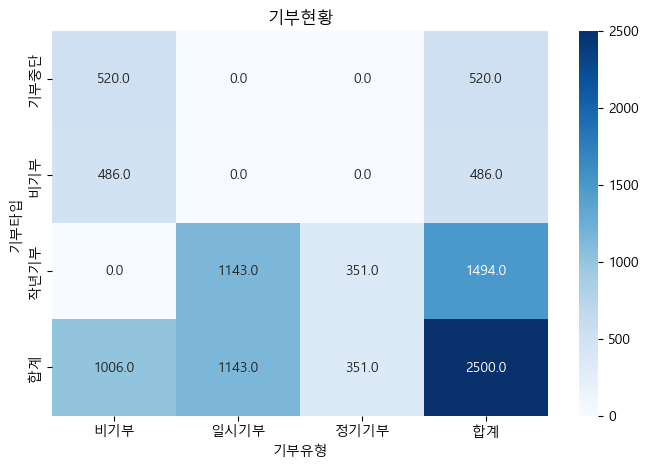

In [153]:

dup_cols=['채널','기부분야','국내의 사회복지 또는 자선 분야', '해외구호 분야', '초/중/고/대학교 교육분야', '의료분야', '문화예술분야',
       'NGO분야', '지역사회발전 분야', '기타분야', '기부관련활동','기부수준_낮은이유']
dat01=no_float.drop(dup_cols,axis=1).drop_duplicates().reset_index(drop=True)
cross=pd.concat([dat01[['기부타입']].reset_index(drop=True),dat01[['기부유형']]],axis=1)
cross2=pd.pivot_table(cross,index='기부타입',columns='기부유형',aggfunc='size').fillna(0)
cross2["합계"] = cross2.sum(axis=1)
cross2.loc["합계"] = cross2.sum(axis=0)
plt.figure(figsize=(8,5))
sns.heatmap(
    cross2,
    annot=True,          # 숫자 표시
    fmt=".1f",
    cmap="Blues"
)
plt.title("기부현황")
plt.show()

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\741354050.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = df.groupby(['세대', '기부유형', '기부타입']).size().reset_index(name='count')


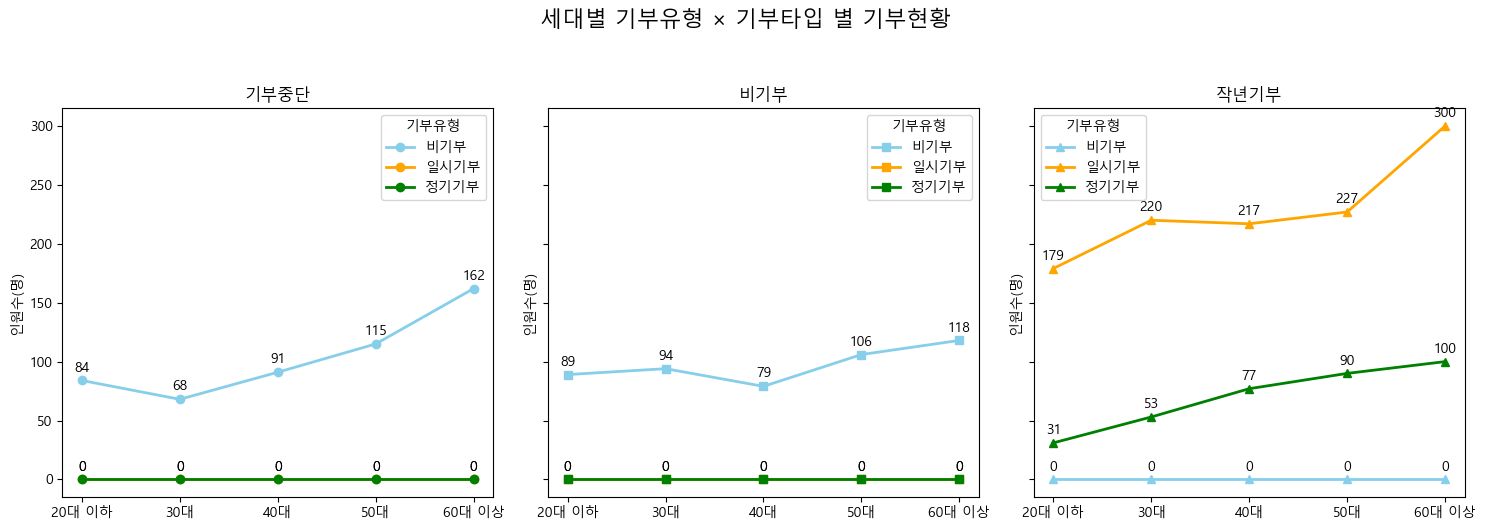

In [156]:
df=dat01[['기부유형','기부타입','세대']]
df_counts = df.groupby(['세대', '기부유형', '기부타입']).size().reset_index(name='count')



# 세대 순서
generations = df_counts['세대'].unique()
# 기부유형 색상 매핑
colors = {'비기부':'skyblue', '일시기부':'orange', '정기기부':'green'}
# 기부타입 마커 매핑
markers = {'기부중단':'o', '비기부':'s', '작년기부':'^'}

# figure, subplot 생성 (기부타입별)
donation_types = df_counts['기부타입'].unique()
fig, axes = plt.subplots(1, len(donation_types), figsize=(5*len(donation_types),5), sharey=True)

if len(donation_types) == 1:
    axes = [axes]

for ax, dtype in zip(axes, donation_types):
    sub = df_counts[df_counts['기부타입']==dtype]
    for dtype_color in sub['기부유형'].unique():
        temp = sub[sub['기부유형']==dtype_color]
        ax.plot(
            temp['세대'],
            temp['count'],
            marker=markers[temp['기부타입'].iloc[0]],
            color=colors[dtype_color],
            label=dtype_color,
            linewidth=2
        )
        # 각 점 위에 값 표시
        for x, y in zip(temp['세대'], temp['count']):
            ax.text(x, y+5, str(y), ha='center', va='bottom', fontsize=10)
    ax.set_title(f"{dtype}")
    ax.set_ylabel("인원수(명)")
    ax.legend(title='기부유형')

plt.suptitle("세대별 기부유형 × 기부타입 별 기부현황", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [159]:

dup_cols=['채널','기부분야','국내의 사회복지 또는 자선 분야', '해외구호 분야', '초/중/고/대학교 교육분야', '의료분야', '문화예술분야',
       'NGO분야', '지역사회발전 분야', '기타분야', '기부수준_낮은이유']
dat01=no_float.drop(dup_cols,axis=1).drop_duplicates().reset_index(drop=True)
# 그룹별 Top 3 채널 계산
top_channels_dict = {}

grouped = dat01.groupby(['세대', '기부유형'])
for (gen, dtype), group in grouped:
    counts = group['기부관련활동'].value_counts()
    total = counts.sum()
    top3 = counts.head(3)
    
    # 비율 붙이기
    top3_str = [f"{ch} ({cnt/total*100:.1f}%)" for ch, cnt in top3.items()]
    
    # 3개가 안되면 빈값으로 채우기
    while len(top3_str) < 3:
        top3_str.append('')
    
    top_channels_dict[(gen, dtype)] = top3_str

# DataFrame으로 변환
pivot_df = pd.DataFrame.from_dict(top_channels_dict, orient='index', columns=['Top1', 'Top2', 'Top3'])

# index 이름 설정
gen=[]
type=[]
for idx in range(len(pivot_df)):
    gen.append(pivot_df.index[idx][0])
    type.append(pivot_df.index[idx][1])
pivot_df['세대']=gen
pivot_df['기부타입']=type
pivot_df=pivot_df.reset_index(drop=True)
# 세대와 기부타입을 MultiIndex로 설정
pivot_df.set_index(['세대', '기부타입'], inplace=True)
df_filtered = pivot_df[pivot_df.index.get_level_values('기부타입') != '비기부']
df_filtered

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\3513570266.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dat01.groupby(['세대', '기부유형'])


Top1                      Top2  \
세대     기부타입                                                       
20대 이하 일시기부       포인트·마일리지 기부 (16.3%)        SNS·유튜브 기부 (15.3%)   
       정기기부  비영리기부단체 정기·일시 후원 (33.9%)       포인트·마일리지 기부 (14.3%)   
30대    일시기부       포인트·마일리지 기부 (13.3%)        SNS·유튜브 기부 (10.1%)   
       정기기부  비영리기부단체 정기·일시 후원 (23.9%)       포인트·마일리지 기부 (13.6%)   
40대    일시기부       포인트·마일리지 기부 (16.2%)  포털사이트 크라우드 펀딩 기부 (10.0%)   
       정기기부  비영리기부단체 정기·일시 후원 (25.4%)       포인트·마일리지 기부 (13.8%)   
50대    일시기부       포인트·마일리지 기부 (15.8%)  비영리기부단체 정기·일시 후원 (10.4%)   
       정기기부  비영리기부단체 정기·일시 후원 (25.5%)       포인트·마일리지 기부 (19.3%)   
60대 이상 일시기부  비영리기부단체 정기·일시 후원 (11.7%)       포인트·마일리지 기부 (11.4%)   
       정기기부  비영리기부단체 정기·일시 후원 (32.5%)       포인트·마일리지 기부 (12.1%)   

                                 Top3  
세대     기부타입                            
20대 이하 일시기부  포털사이트 크라우드 펀딩 기부 (11.4%)  
       정기기부        SNS·유튜브 기부 (12.5%)  
30대    일시기부   포털사이트 크라우드 펀딩 기부 (9.4%)  
       정기기부         SNS·유튜브 기부 (9.1%)  
40대    일시기부         SNS·유튜브 기부 (8.7%)  
       정기기부         SNS·유튜브 기부 (9.4%)  
50대    일시기부              현물기부 (10.2%)  
       정기기부              현물기부 (10.6%)  
60대 이상 일시기부          TV/라디오 기부 (9.1%)  
       정기기부            거리모금 기부 (7.6%)

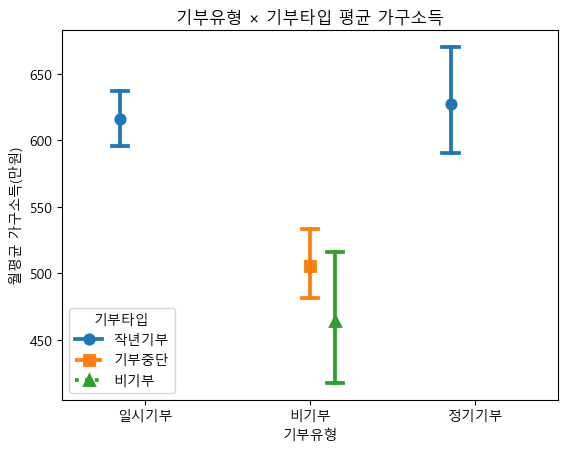

In [160]:
dat01['가구소득']=dat01['가구소득']/10000

money=dat01[['기부유형','기부타입','가구소득']]
sns.pointplot(
    data=money,
    x='기부유형',
    y='가구소득',
    hue='기부타입',
    dodge=0.3,
    markers=['o','s','^','D'],
    linestyles=['-','--',':','-.'],
    capsize=0.1
)
plt.title("기부유형 × 기부타입 평균 가구소득")
plt.ylabel("월평균 가구소득(만원)")
plt.xlabel("기부유형")
plt.legend(title='기부타입')
plt.show()

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\325838099.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sodeok['총 기부금액']=sodeok.iloc[:,4:].T.sum()


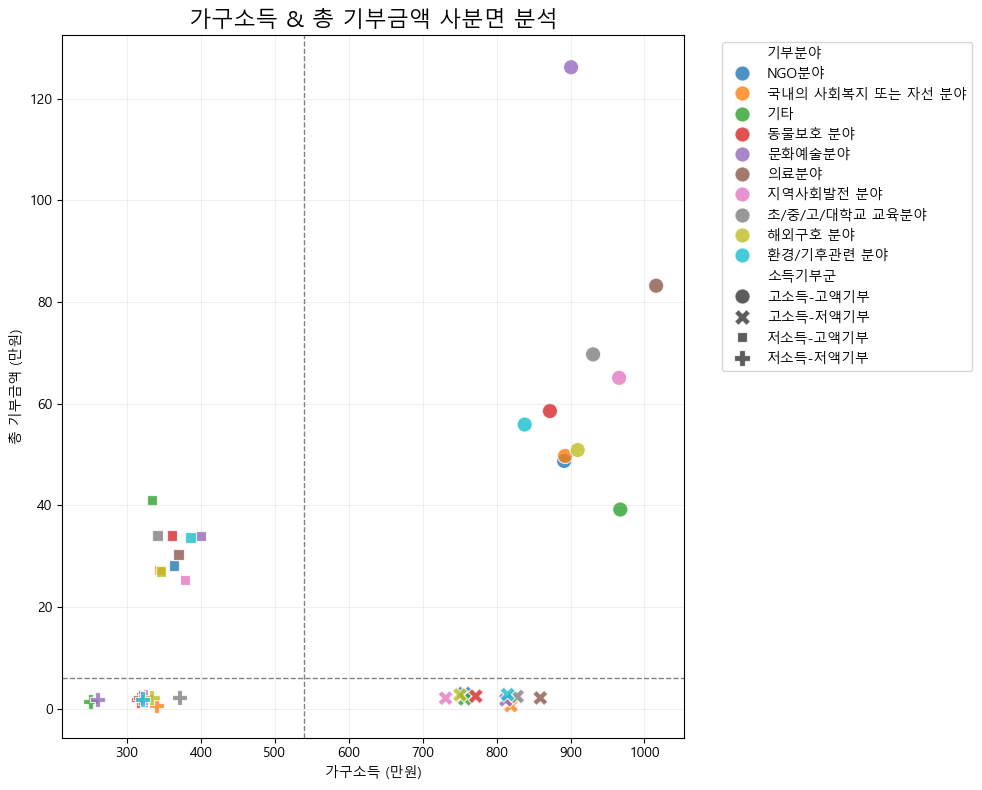

In [162]:
dup_cols=['채널', '기부관련활동','기부수준_낮은이유']
dato=no_float.drop(dup_cols,axis=1).drop_duplicates().reset_index(drop=True)
qq=['기부유형','가구소득','기부분야','국내의 사회복지 또는 자선 분야_기부액', '해외구호 분야_기부액', '초/중/고/대학교 교육분야_기부액',
       '의료분야_기부액', '문화예술분야_기부액', 'NGO분야_기부액', '환경/기후관련 분야_기부액', '동물보호 분야_기부액',
       '지역사회발전 분야_기부액', '기타_기부액']
sodeok=dato[qq]
sodeok['총 기부금액']=sodeok.iloc[:,4:].T.sum()
sodeok=sodeok[sodeok['기부유형']!='비기부'].reset_index(drop=True)
sodeok['가구소득'] = sodeok['가구소득'] / 10000
sodeok['총 기부금액'] = sodeok['총 기부금액'] / 10000
income_threshold = sodeok['가구소득'].median()
donation_threshold = sodeok['총 기부금액'].median()
sodeok['income_donation_group'] = sodeok.apply(classify_quadrant, axis=1)
bunya=sodeok[['기부유형','income_donation_group','가구소득','총 기부금액','기부분야']]
bunya2=bunya.groupby(['income_donation_group','기부분야'])[['가구소득','총 기부금액']].mean()
bunya2=bunya2.reset_index(drop=False)
bunya2=bunya2.rename(columns={'income_donation_group':'소득기부군'})
plt.figure(figsize=(10, 8))

# scatter, hue=기부분야
sns.scatterplot(
    data=bunya2,
    x='가구소득',
    y='총 기부금액',
    hue='기부분야',        # 원하는 분류 컬럼
    style='소득기부군',
    s=120,
    alpha=0.8,
    palette='tab10'
)

# 기준선 추가
plt.axvline(income_threshold, color='grey', linestyle='--', linewidth=1)
plt.axhline(donation_threshold, color='grey', linestyle='--', linewidth=1)

plt.title('가구소득 & 총 기부금액 사분면 분석', fontsize=16)
plt.xlabel('가구소득 (만원)')
plt.ylabel('총 기부금액 (만원)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Ⅱ. 지역별 기부 패턴(Q6~Q10)

In [164]:

dup_cols=['채널','기부분야','국내의 사회복지 또는 자선 분야', '해외구호 분야', '초/중/고/대학교 교육분야', '의료분야', '문화예술분야',
       'NGO분야', '지역사회발전 분야', '기타분야', '기부관련활동','기부수준_낮은이유']
dat01=no_float.drop(dup_cols,axis=1).drop_duplicates().reset_index(drop=True)

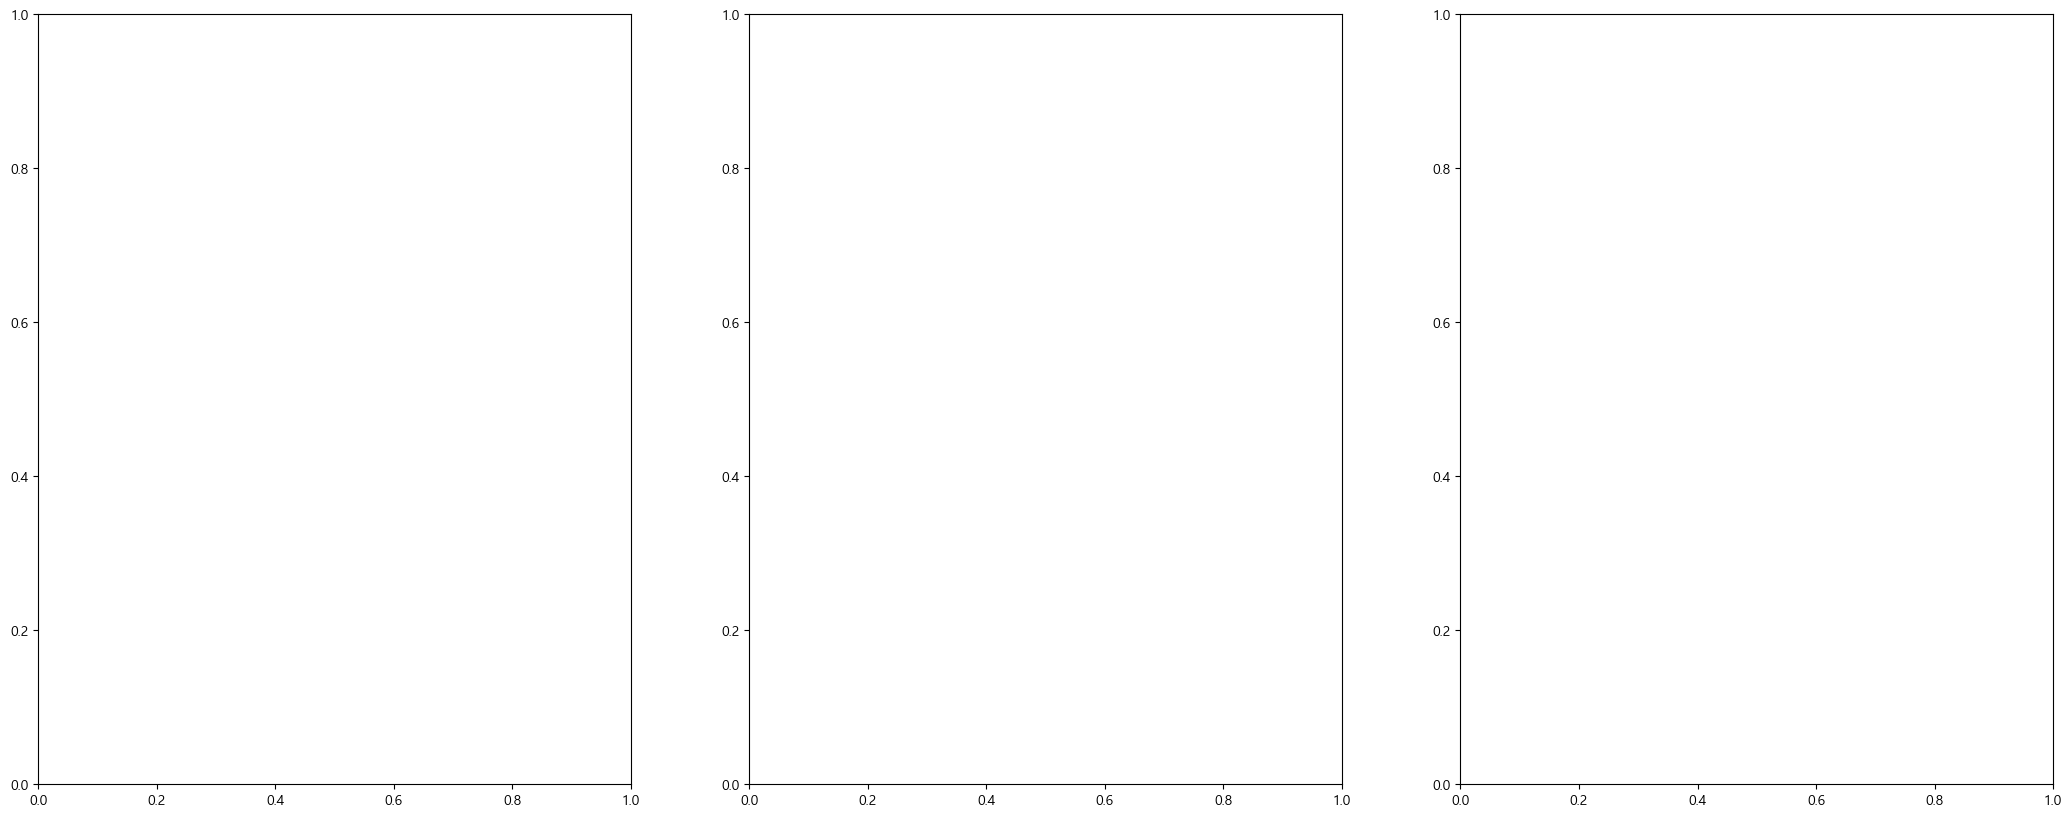

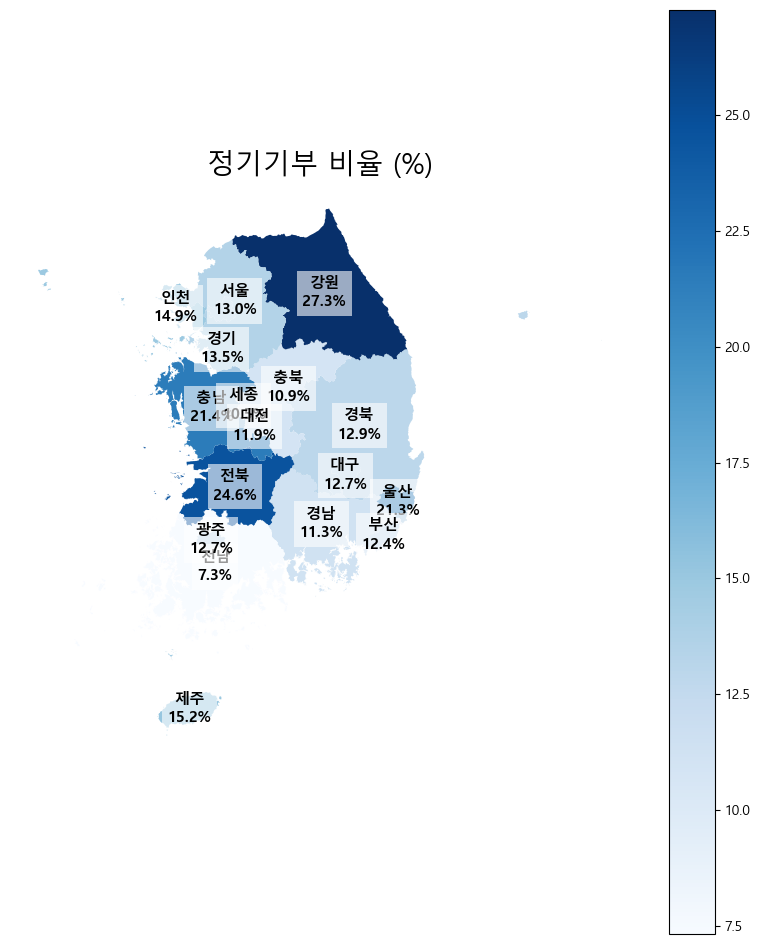

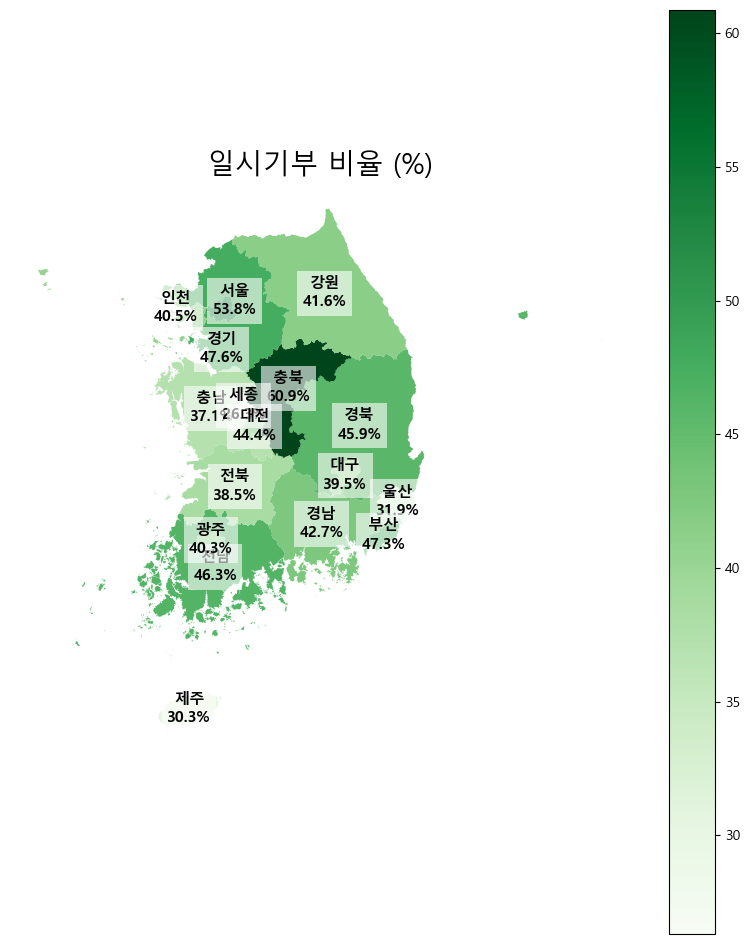

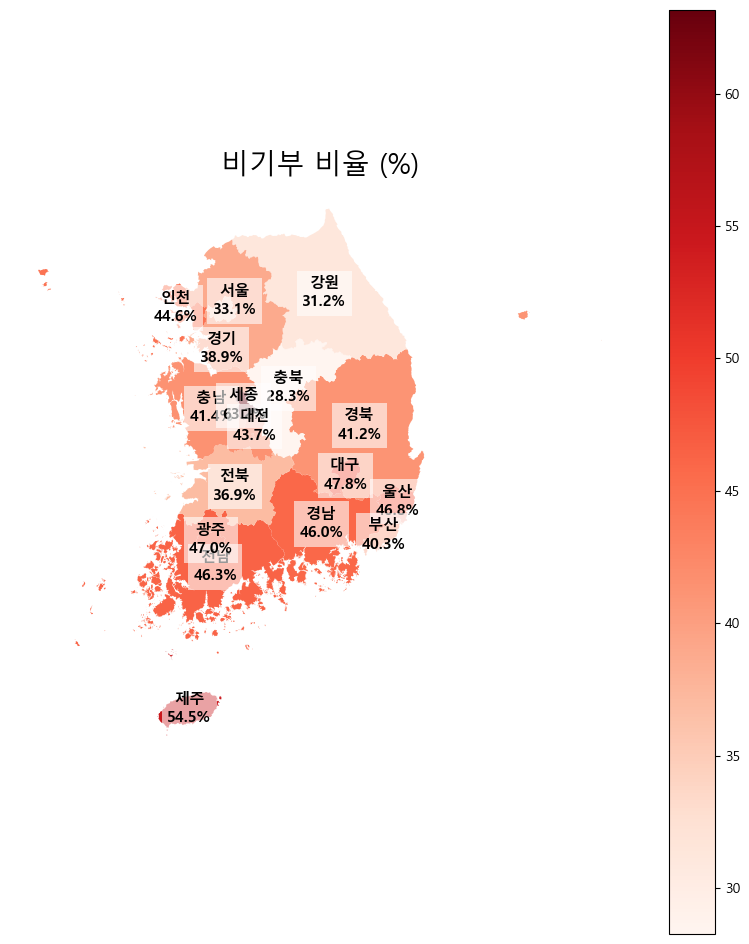

In [183]:

# region별 기부자 비율 테이블
pivot = pd.crosstab(dat01['지역'], dat01['기부유형'], normalize='index') * 100
pivot = pivot.reset_index()
pivot=map_region(pivot, col_name='지역', new_col='지역')
# 시도 단위 한국 지도 geojson
pivot=pivot.fillna('제주')
url = "https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2013/json/skorea_provinces_geo.json"
geo_json = requests.get(url).json()


# GeoJSON 로드
geo = gpd.read_file(url)
mapping = {
    '제주특별자치도': '제주',
    '경상남도': '경남',
    '경상북도': '경북',
    '전라남도': '전남',
    '전라북도': '전북',
    '충청남도': '충남',
    '충청북도': '충북',
    '강원도': '강원',
    '경기도': '경기',
    '세종특별자치시': '세종',
    '울산광역시': '울산',
    '대전광역시': '대전',
    '광주광역시': '광주',
    '인천광역시': '인천',
    '대구광역시': '대구',
    '부산광역시': '부산',
    '서울특별시': '서울'
}

geo['지역'] = geo['name'].map(mapping)
# pivot과 merge
merged = geo.merge(pivot, left_on='지역', right_on='지역')

label_offsets = {
    '서울': (0.15, 0.10),   # 오른쪽 위로 이동
    '경기': (-0.20, -0.40), # 왼쪽 아래로 이동
    # 필요하면 다른 지역도 추가 가능
}
fig, axes = plt.subplots(1, 3, figsize=(26, 10))

cols = ['정기기부', '일시기부', '비기부']
titles = ['정기기부 비율 (%)', '일시기부 비율 (%)', '비기부 비율 (%)']
cmaps = ['Blues', 'Greens', 'Reds']

# 서울·경기 오프셋 설정
OFFSET =  {
    '서울': (0.15, 0.10),   # 오른쪽 위로 이동
    '경기': (-0.20, -0.40), # 왼쪽 아래로 이동
    # 필요하면 다른 지역도 추가 가능
}

for i in range(3):
    col = cols[i]

    plt.figure(figsize=(10, 12))
    ax = plt.gca()

    # 지도 그리기
    merged.plot(column=col, cmap=cmaps[i], legend=True, ax=ax)
    ax.set_title(titles[i], fontsize=20)

    # ---- 위도·경도 축(스케일) 삭제 ----
    ax.set_axis_off()

    # ---- 라벨 표시(지역 + %) ----
    for idx, row in merged.iterrows():
        centroid = row.geometry.centroid
        x, y = centroid.x, centroid.y

        # 서울/경기 겹침 방지
        if row["지역"] in OFFSET:
            dx, dy = OFFSET[row["지역"]]
            x += dx
            y += dy

        label = f"{row['지역']}\n{row[col]:.1f}%"

        ax.text(
            x, y, label,
            ha='center', va='center',
            fontsize=11, fontweight='bold',
            color="black",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
        )

    plt.show()


In [184]:
merged["기부잠재력"] = (
    0.5 * merged["정기기부"] +
    0.3 * merged["일시기부"] -
    0.2 * merged["비기부"]
)

merged["기부취약점수"] = (
    0.6 * merged["비기부"] -
    0.4 * merged["정기기부"]
)


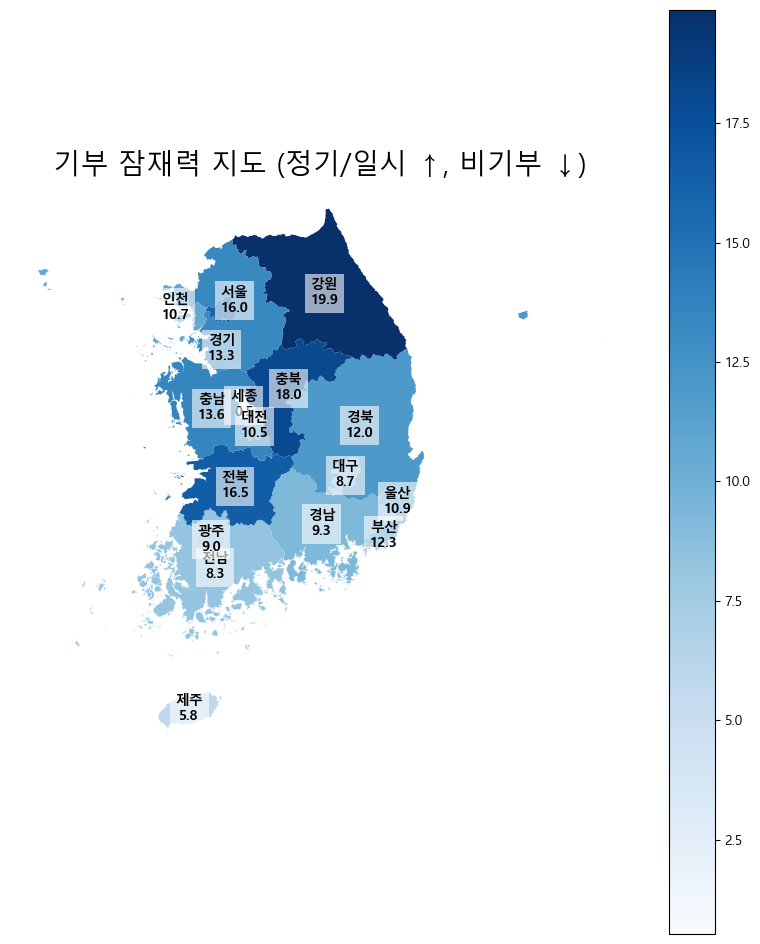

In [185]:
# ----------------------------
# 4) 지도 2개 따로 출력
# ----------------------------
draw_map(
    merged,
    col="기부잠재력",
    title="기부 잠재력 지도 (정기/일시 ↑, 비기부 ↓)",
    cmap="Blues"
)


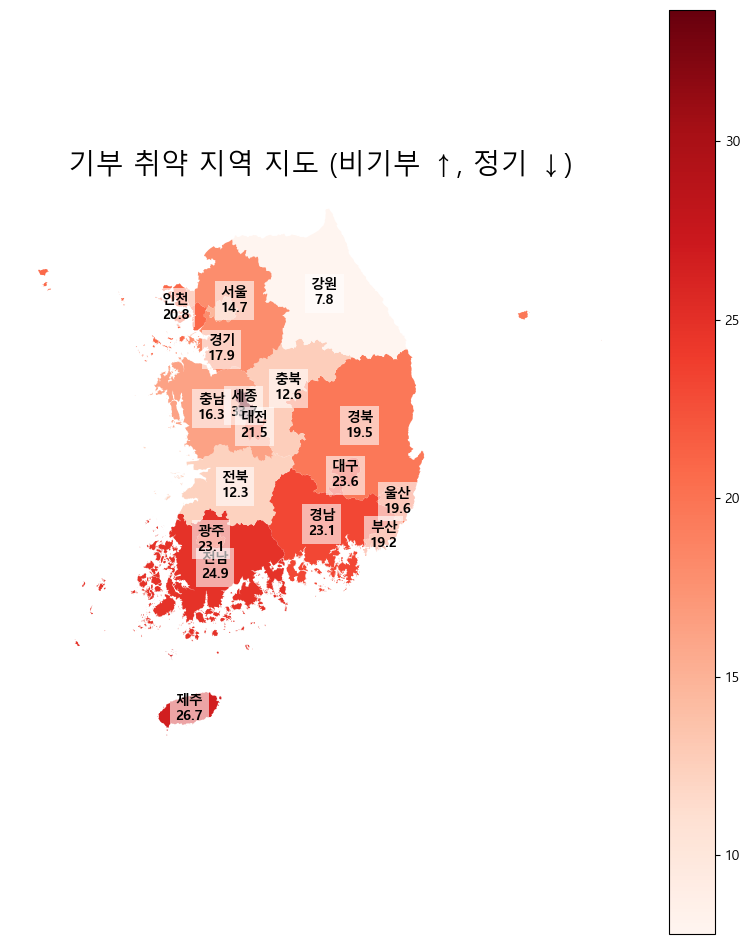

In [186]:

draw_map(
    merged,
    col="기부취약점수",
    title="기부 취약 지역 지도 (비기부 ↑, 정기 ↓)",
    cmap="Reds"
)

In [191]:
dup_cols=['채널', '기부수준_낮은이유']
dat01=no_float.drop(dup_cols,axis=1).drop_duplicates().reset_index(drop=True)
yesno=dat01[['기부분야']]
itsue=dat01[['국내의 사회복지 또는 자선 분야', '해외구호 분야', '초/중/고/대학교 교육분야', '의료분야', '문화예술분야',
       'NGO분야', '지역사회발전 분야', '기타분야']]
vit=pd.concat([dat01['지역'],yesno,itsue],axis=1)
vit3=vit.copy()

# ① 리스트 컬럼 9개 지정
list_cols = vit3.iloc[:,1:].columns.tolist()

# ② 모든 리스트 컬럼을 개별 explode 후 순차적으로 병합
df_expanded = vit3.copy()
# 빈 리스트를 NaN으로 변환
for col in list_cols:
    df_expanded[col] = df_expanded[col].apply(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)
df_expanded=df_expanded.dropna(subset=list_cols, how='all')
# ① 리스트 컬럼 9개 지정
list_cols = vit3.iloc[:,1:].columns.tolist()

# ② 모든 리스트 컬럼을 개별 explode 후 순차적으로 병합
df_expanded2= df_expanded.copy()

for col in list_cols:
    df_expanded2 = df_expanded2.explode(col, ignore_index=True)

df_expanded2=df_expanded2.drop_duplicates()

issue_cols = [
    '국내의 사회복지 또는 자선 분야',
    '해외구호 분야',
    '초/중/고/대학교 교육분야',
    '의료분야',
    '문화예술분야',
    'NGO분야',
    '지역사회발전 분야',
    '기타분야'
]

df_melt = dat01.melt(
    id_vars=['지역', '기부분야'],   # 그대로 유지할 컬럼
    value_vars=issue_cols,         # melt할 이슈 컬럼들
    var_name='',           # 새로 생길 컬럼명
    value_name='선행이슈'                # melt된 값 컬럼명
)
df_melt = df_melt.dropna(subset=['선행이슈'])
df_issue=df_melt[['지역','기부분야','선행이슈']].drop_duplicates().reset_index(drop=True)
df_issue2=map_region(df_issue, col_name='지역', new_col='지역')

# 1. '기부분야' 컬럼에서 '기타'를 '기타분야'로 변경
df_issue2['기부분야'] = df_issue2['기부분야'].replace('기타', '기타분야')

# 2. '기부분야' 또는 '선행이슈'가 0인 행 삭제
df_issue2 = df_issue2[~((df_issue2['기부분야'] == '0') | (df_issue2['선행이슈'] == '0'))].reset_index(drop=True)
df_issue2=df_issue2[~((df_issue2['기부분야'] == 0) | (df_issue2['선행이슈'] == 0))].reset_index(drop=True)

In [194]:
df_issue3=df_issue2.drop('지역',axis=1)
pivot = df_issue3.pivot_table(index='기부분야', columns='선행이슈', aggfunc='size', fill_value=0)
# Melt: long-format으로 변환
df_melt = pivot.reset_index().melt(id_vars='기부분야', var_name='선행이슈', value_name='count')

issue = ['아동 및 청소년 이슈','청년 이슈','노인관련 이슈','장애인관련 이슈',
         '여성 또는 성평등 관련 이슈','취약계층 문제 해결','동물보호','환경이슈',
         '자연재해이슈','해외재난구호','권익옹호나 사회이슈','기타']

counts = pivot.values  # 너가 제공한 8×12 numpy array

rows = []
for i, g in enumerate(issue_cols):
    for j, iss in enumerate(issue):
        cnt = counts[i][j]
        rows += [{'기부분야': g, '관련이슈': iss}] * cnt

df_it = pd.DataFrame(rows)

In [197]:


mca = prince.MCA(
    n_components=2,
    engine='sklearn',   # 중요!
    random_state=42
)

mca = mca.fit(df_it)
coords = mca.column_coordinates(df_it)

In [199]:
countss=pd.concat([df_melt.groupby('선행이슈')[['count']].sum(),df_melt.groupby('기부분야')[['count']].sum()])
coords_plot = coords.reset_index()
coords_plot.columns = ['label', 'Dim1', 'Dim2']
coords_plot['category']=0
for idx in range(len(coords_plot)):
    coords_plot['category'][idx]=coords_plot['label'][idx].split('_')[0]
    coords_plot['label'][idx]=coords_plot['label'][idx].split('_')[2]

coords_plot2=pd.merge(coords_plot,countss.reset_index(),how='left',left_on='label',right_on='index')

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\2147376950.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  coords_plot['category'][idx]=coords_plot['label'][idx].split('_')[0]
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\2147376950.

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


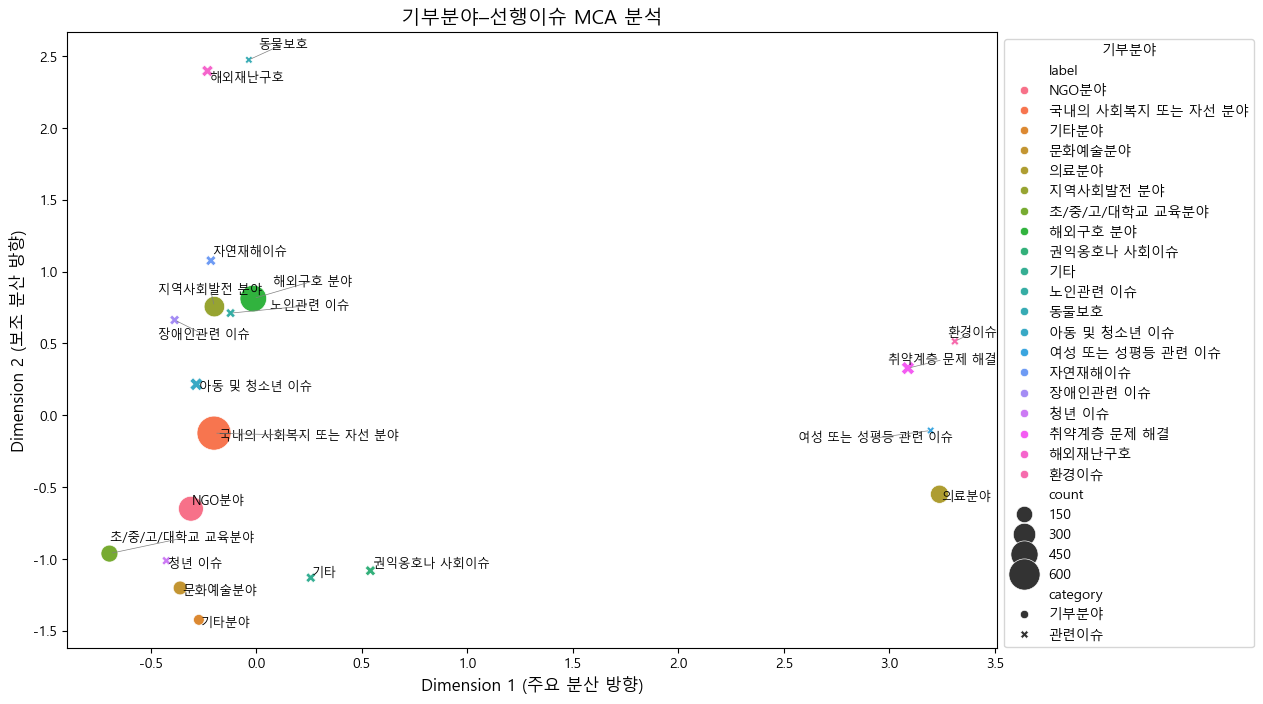

In [201]:
countss=pd.concat([df_melt.groupby('선행이슈')[['count']].sum(),df_melt.groupby('기부분야')[['count']].sum()],axis=0)

# (1) figsize로 그래프 찌그러짐 방지
plt.figure(figsize=(12, 8))

# (2) 산점도 (size=피벗값, hue=기부분야)
scatter = sns.scatterplot( data=coords_plot2, x='Dim1', y='Dim2', style='category', hue='label', size='count', sizes=(30, 600))

# (3) 점에 텍스트 라벨 추가
texts = []
for i, row in coords_plot2.iterrows():
    texts.append(
        plt.text(
            row["Dim1"],
            row["Dim2"],
            row["label"],
            fontsize=9
        )
    )

# (4) adjustText → 라벨 겹침 자동 해결
adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="gray", lw=0.5),
    force_points=0.3,
    force_text=0.5
)

# (5) 추천 x, y축 제목
plt.xlabel("Dimension 1 (주요 분산 방향)", fontsize=12)
plt.ylabel("Dimension 2 (보조 분산 방향)", fontsize=12)

# (6) 추천 그래프 제목
plt.title("기부분야–선행이슈 MCA 분석", fontsize=14)

# (7) 범례에서 size(count) 제거
#    size 관련 범례는 가장 마지막에 자동으로 추가되므로 삭제함
handles, labels = scatter.get_legend_handles_labels()

# hue 범례만 남기기 → 보통 앞쪽이 hue, 뒤쪽이 size
# labels 중 "값_size" 또는 size 범례 문구 자동 제거
filtered = [(h, l) for h, l in zip(handles, labels) if "size" not in l and l != "값_size"]
handles, labels = zip(*filtered)

legend = plt.legend(handles, labels,
                    title="기부분야",
                    bbox_to_anchor=(1, 1),  # x=2 인 근처로 이동
                    loc="upper left")

plt.show()

In [212]:
df_melt = df_expanded2.melt(
    id_vars=['지역', '기부분야'],   # 그대로 유지할 컬럼
    value_vars=issue_cols,         # melt할 이슈 컬럼들
    var_name='',           # 새로 생길 컬럼명
    value_name='선행이슈'                # melt된 값 컬럼명
)
df_melt = df_melt.dropna(subset=['선행이슈'])
df_issue=df_melt[['지역','기부분야','선행이슈']].drop_duplicates().reset_index(drop=True)
# 2. '기부분야' 또는 '선행이슈'가 0인 행 삭제
df_issue = df_issue[~((df_issue['기부분야'] == '0') | (df_issue['선행이슈'] == '0'))].reset_index(drop=True)
df_issue=df_issue[~((df_issue['기부분야'] == 0) | (df_issue['선행이슈'] == 0))].reset_index(drop=True)
piv=df_issue.pivot_table(index=['지역','기부분야'], columns='선행이슈', aggfunc='size', fill_value=0)

# 예시 데이터
df = df_issue.copy()
# 각 기부분야 별 이상적 선행이슈 정의
ideal_issue_map = {
    '국내의 사회복지 또는 자선 분야':['아동 및 청소년 이슈','노인관련 이슈','취약계층 문제 해결'],
    '해외구호 분야':['해외재난구호','자연재해이슈'],
    '초/중/고/대학교':['청년 이슈'],
    '의료분야':['의료 관련 이슈'],
    '문화예술분야':['문화예술 관련 이슈'],
    'NGO분야':['아동 및 청소년 이슈','환경이슈','취약계층 문제 해결'],
    '지역사회발전 분야':['권익옹호나 사회이슈','환경이슈'],
    '기타':['기타']
}

# 지역별, 기부분야별 점수 계산
regions = df['지역'].unique()
gibu_fields = df['기부분야'].unique()

scores = []

for r in regions:
    df_r = df[df['지역']==r]
    for gibu in gibu_fields:
        df_gibu = df_r[df_r['기부분야']==gibu]
        if df_gibu.empty:
            continue
        # 점수 계산: 이상적 이슈 포함 -> 0, 아니면 +1
        score = df_gibu['선행이슈'].apply(lambda x: 0 if x in ideal_issue_map.get(gibu, []) else 1).sum()
        scores.append({'지역':r, '기부분야':gibu, 'GapScore':score})

# 결과 DataFrame
gap_df = pd.DataFrame(scores)
gap_df=map_region(gap_df, col_name='지역', new_col='지역')

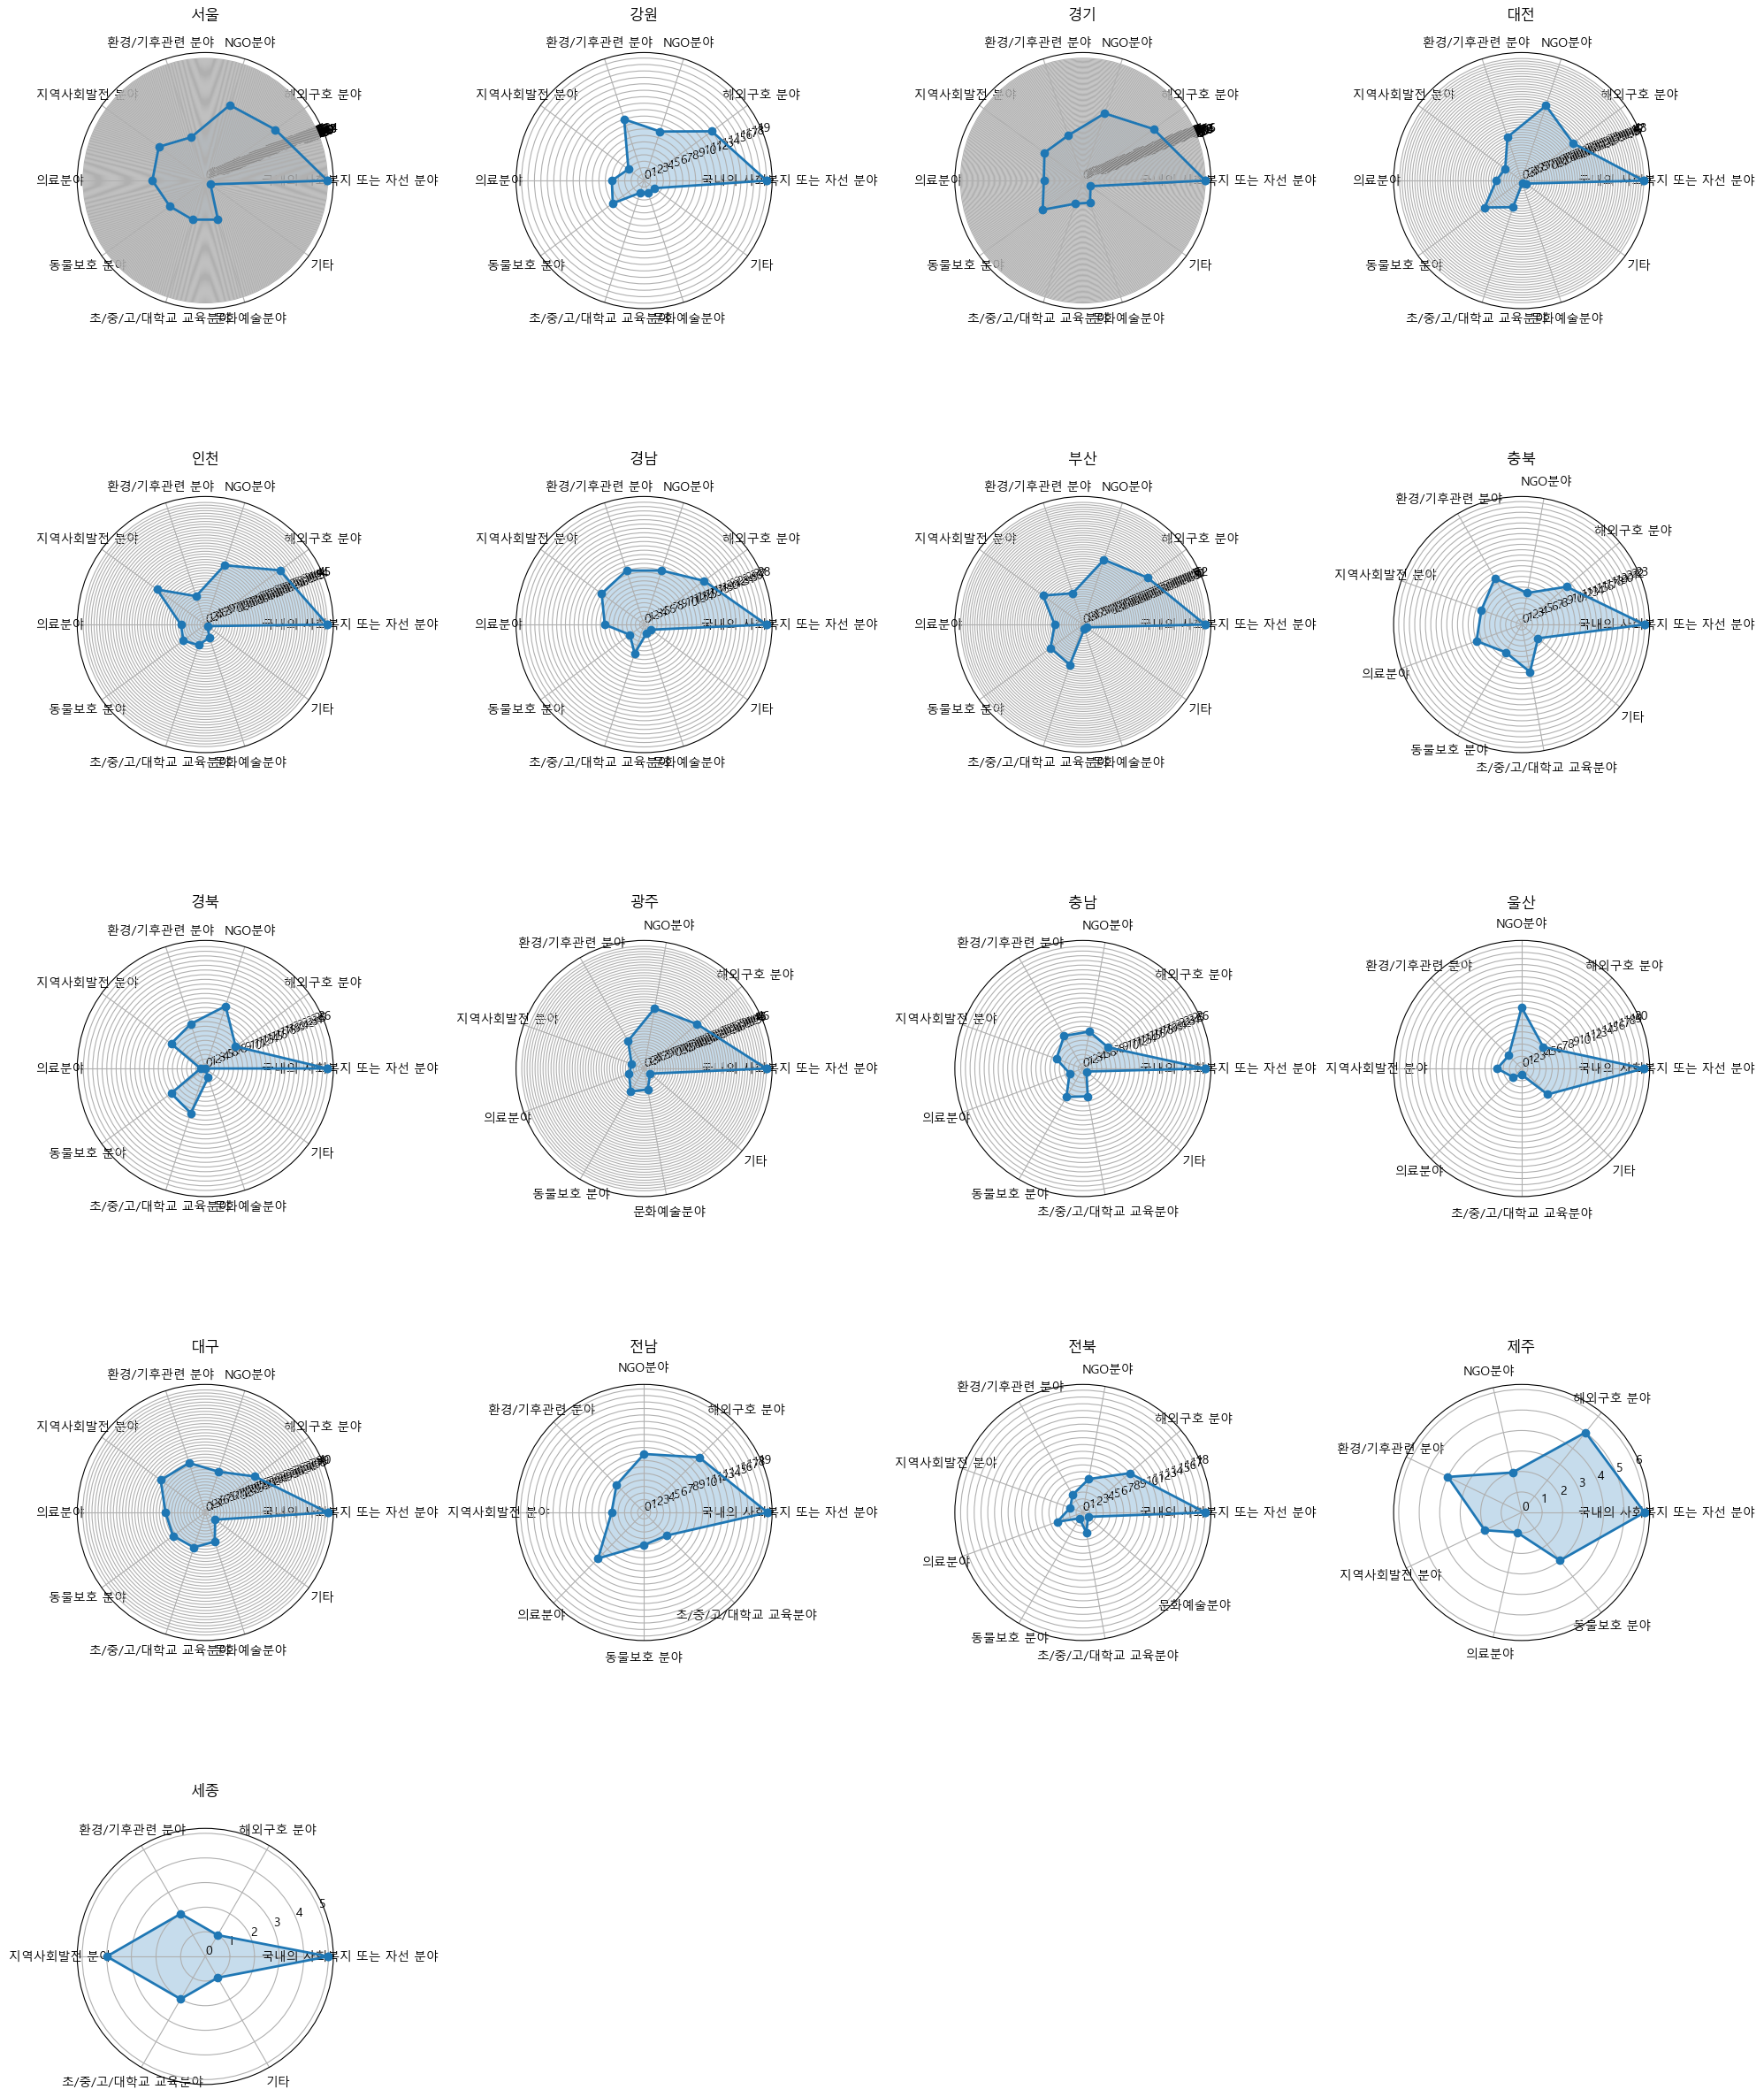

In [213]:
# subplot 4x5

rows, cols = 5, 4
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows), subplot_kw=dict(polar=True))
axes = axes.flatten()

regions = gap_df['지역'].unique()

for i, r in enumerate(regions):
    df_r = gap_df[gap_df['지역']==r]
    categories = df_r['기부분야'].tolist()
    values = df_r['GapScore'].tolist()
    plot_radar(axes[i], categories, values, r)

# 남는 subplot 처리
for j in range(len(regions), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Ⅲ.기부의향 결정 요인 분석(Q11~Q15)

In [235]:
dup_cols

['채널', '기부수준_낮은이유']

In [236]:
dat10=pd.read_csv('C:/Users/gram/Desktop/NGO/final.csv')
cat_cols = ['성별','지역','혼인상태', '자녀여부', '종교', '고용상태','소득변화', '학벌','기부동기','단체선정기준','올해기부의향'
            ,'정보요청','관심표현','기부수준인식','상한선이유','상한선배제이유','추가지출여부_행정비용',	'추가지출여부_성과측정'	,'추가지출여부_IT비용'
            ,'자원봉사여부','고향사랑기부제여부','고향사랑기부제_사용여부','고향사랑기부제_영향력','종교기부여부','기부유형','세대','소득수준','기부타입',
            '기부노력시간','기부단체효과성']+['채널','기부분야','국내의 사회복지 또는 자선 분야', '해외구호 분야', '초/중/고/대학교 교육분야', '의료분야', '문화예술분야',
       'NGO분야', '지역사회발전 분야', '기타분야', '기부관련활동','기부수준_낮은이유']
for col in cat_cols:
    
    # 1) 값 종류가 2개인 경우: 2 → 0
    if dat10[col].nunique() == 2 and 2 in dat10[col].unique():
        dat10[col] = dat10[col].replace(2, 0)
    
    # 2) 숫자 0과 한글 문자열이 섞여 있으면: 숫자 0 → '0'
    uniques = dat10[col].unique()
    # 숫자 0이 있고, 문자열(한글)이 있으면 변환
    if any(isinstance(x, str) for x in uniques) and 0 in uniques:
        dat10[col] = dat10[col].replace(0, '0')
for col in cat_cols:
    le = LabelEncoder()
    dat10[col] = le.fit_transform(dat10[col])


[LightGBM] [Warning] Unknown parameter: pos_label
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: pos_label
[LightGBM] [Info] Number of positive: 35340, number of negative: 3525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 38865, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909301 -> initscore=2.305135
[LightGBM] [Info] Start training from score 2.305135


C:\Users\gram\AppData\Local\Temp\ipykernel_39816\917946146.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\917946146.py:50: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


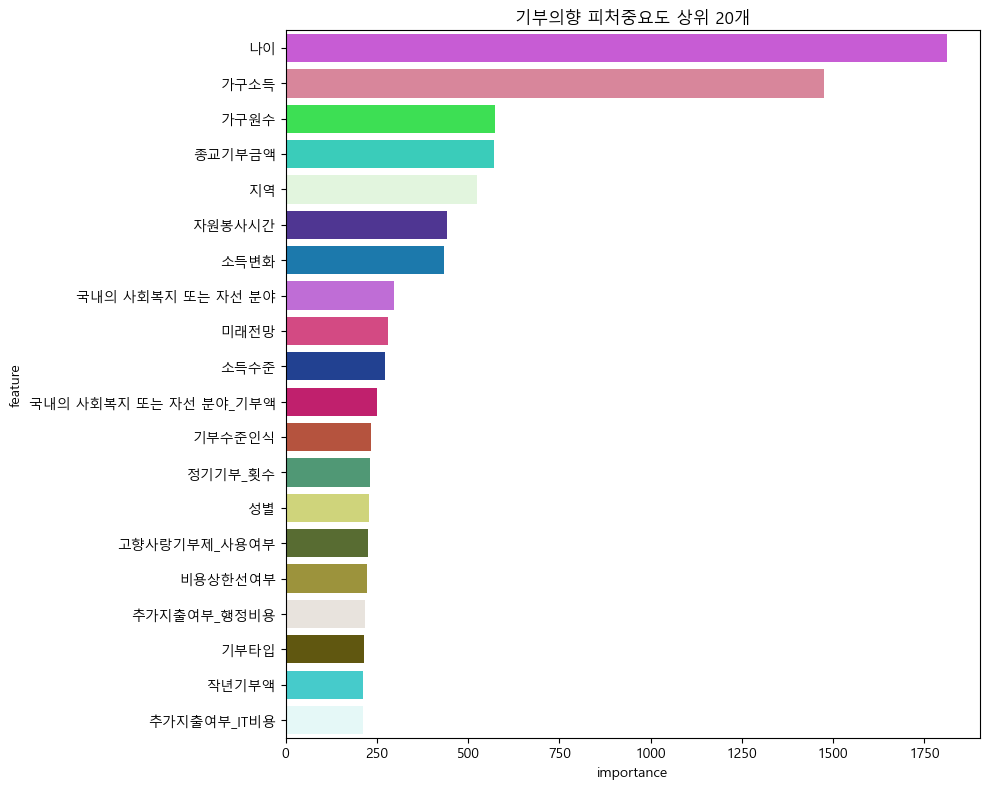

In [237]:

# -------------------------
# 1. 데이터 로드 (예시)
# -------------------------
# df = pd.read_csv("donation.csv")  # 형태: features + target(기부의향)
target_col = "올해기부의향"     # 타깃 변수명 예시

X = dat10.drop(columns=[target_col])

y = dat10['올해기부의향']

# -------------------------
# 3. Train/Test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# 5. LightGBM 학습
# -------------------------
model = lgb.LGBMClassifier(
     objective='binary',
    pos_label=1,     # ← positive class 강제 지정!!
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    random_state=42
)
cat_colss = [col for col in cat_cols if col != '올해기부의향']
model.fit(X_train, y_train,    categorical_feature=cat_colss)

# --------------------
# 3. Feature Importance 추출
# --------------------
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# 상위 20개만
top20 = feature_importance.head(20)

# --------------------
# 4. Seaborn 시각화 (알록달록)
# --------------------
plt.figure(figsize=(10, 8))

# 무작위 색상 20개 생성
colors = np.random.rand(len(top20), 3)

sns.barplot(
    data=top20,
    x='importance',
    y='feature',
    palette=colors
)

plt.title("기부의향 피처중요도 상위 20개")
plt.tight_layout()
plt.show()


C:\Users\gram\AppData\Local\Temp\ipykernel_39816\1016359306.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\1016359306.py:12: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


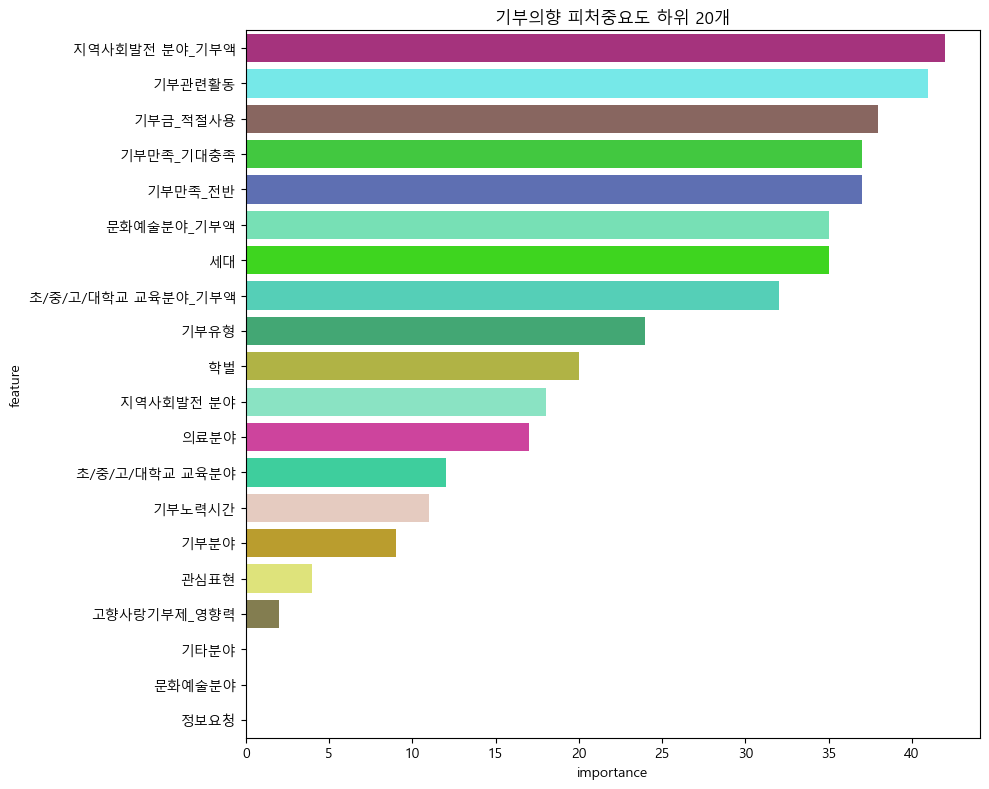

In [239]:
# 상위 20개만
bottom20 = feature_importance.tail(20)

# --------------------
# 4. Seaborn 시각화 (알록달록)
# --------------------
plt.figure(figsize=(10, 8))

# 무작위 색상 20개 생성
colors = np.random.rand(len(bottom20), 3)

sns.barplot(
    data=bottom20,
    x='importance',
    y='feature',
    palette=colors
)

plt.title("기부의향 피처중요도 하위 20개")
plt.tight_layout()
plt.show()

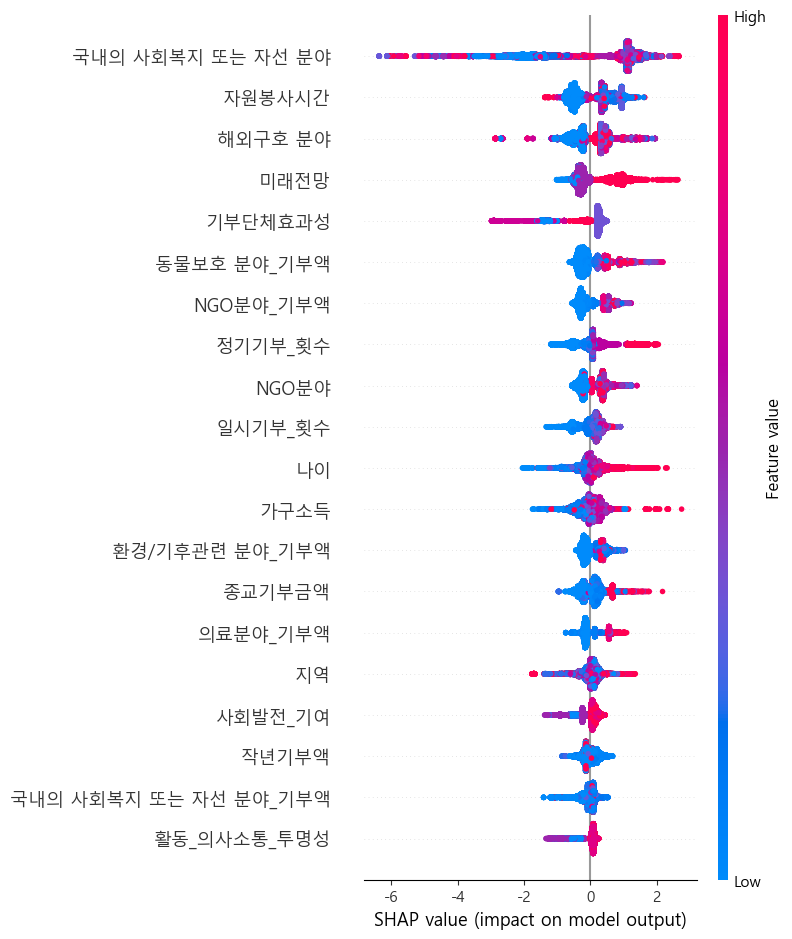

In [240]:
# 2) TreeExplainer 만들기
explainer = shap.TreeExplainer(
    model)
# 3) SHAP 값 계산
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

In [242]:

# 1) SHAP 중요도
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=X.columns)

# 2) SHAP dependence 내부 로직을 이용하여 interaction 변수 자동 탐지
from shap.plots._scatter import approximate_interactions

auto_interaction = {}

for col in tqdm(X.columns):
    try:
        idx = X.columns.get_loc(col)
        # approximate_interactions → 상호작용 강도 상위 변수 index 반환
        inter_idx = approximate_interactions(
            idx, shap_values.values, X.values
        )[0]
        auto_interaction[col] = X.columns[inter_idx]
    except:
        auto_interaction[col] = None

# 3) 두 변수 상관계수 계산
corr_matrix = X.corr()

def get_corr_desc(var, inter_var):
    if (inter_var is not None) and (inter_var in corr_matrix.columns):
        corr = corr_matrix.loc[var, inter_var]
        return f"상관계수={corr:.3f}"
    return "상호작용 변수 없음"

# 4) df 생성 (문제였던 3·4번째 컬럼 채워짐)
df = pd.DataFrame({
    "변수": X.columns,
    "shape-x상관": shap_importance.values,
    "자동 탐지된_상호작용변수": [auto_interaction[c] for c in X.columns],
    "두 변수상관,상호작용해석": [
        get_corr_desc(c, auto_interaction[c]) for c in X.columns
    ]
})

# 5) 상위 10개만 보기
top10 = df.sort_values("shape-x상관", ascending=False).head(10)
top10

100%|██████████| 102/102 [08:26<00:00,  4.97s/it]


변수  shape-x상관          자동 탐지된_상호작용변수 두 변수상관,상호작용해석
57  국내의 사회복지 또는 자선 분야   1.441981                정기기부_횟수    상관계수=0.069
45             자원봉사시간   0.525939                 기부_삶변화    상관계수=0.105
58            해외구호 분야   0.477950      국내의 사회복지 또는 자선 분야    상관계수=0.194
36               미래전망   0.463354  국내의 사회복지 또는 자선 분야_기부액    상관계수=0.031
99            기부단체효과성   0.378613      국내의 사회복지 또는 자선 분야    상관계수=0.072
17        동물보호 분야_기부액   0.369833            고향사랑기부제_영향력    상관계수=0.083
15          NGO분야_기부액   0.347244           고향사랑기부제_사용여부    상관계수=0.013
20            정기기부_횟수   0.331101                기부_참여확산    상관계수=0.230
62              NGO분야   0.315126                 기부노력시간    상관계수=0.261
21            일시기부_횟수   0.265460                  NGO분야    상관계수=0.167

In [245]:


# 1) 컬럼 이름 변경
df = df.rename(columns={"두 변수상관,상호작용해석": "두 변수 상관계수"})

# 2) 문자열에서 숫자만 추출하여 float로 변환
df["두 변수 상관계수"] = (
    df["두 변수 상관계수"]
    .astype(str)
    .str.extract(r"(-?\d+\.\d+)", expand=False)   # 숫자 추출 (양수/음수 지원)
    .astype(float)
)

In [258]:
top10_corr = df.reindex(
    df["두 변수 상관계수"].abs().sort_values(ascending=False).index
).drop_duplicates('두 변수 상관계수').head(10)

In [260]:
top10_corr=top10_corr.reset_index(drop=True)
# top10에 새로운 컬럼 추가
top10_corr["상호작용종류"] = [
    get_interaction_type(row["변수"], row["자동 탐지된_상호작용변수"])
    for _, row in top10.iterrows()
]

top10_corr=top10_corr.reset_index(drop=True)
top10_corr.index=[x for x in range(1,11)]

In [261]:
top10_corr

변수  shape-x상관      자동 탐지된_상호작용변수  두 변수 상관계수   상호작용종류
1      기부만족_전반   0.043938          정부기업_대체역할      0.731  상호증폭(+)
2      기부_정부보완   0.075069            기부_참여확산      0.725  상호증폭(+)
3      재정정보_공개   0.027880         기부충성도_추천의향      0.682  상호증폭(+)
4   기부충성도_추천의향   0.078571          정부기업_대체역할      0.662  상호증폭(+)
5      기부_도움제공   0.011218            시민의견_반영      0.621  상호증폭(+)
6         자녀여부   0.023419                 세대      0.555  상호증폭(+)
7    기부만족_기대충족   0.022522  국내의 사회복지 또는 자선 분야      0.329  상호증폭(+)
8   기부자지향성_관심도   0.071983               미래전망      0.304  상호증폭(+)
9        사회변화도   0.123368              작년기부액      0.287  상호증폭(+)
10       작년기부액   0.160759             자원봉사여부      0.286  상호증폭(+)

▶ 기부만족_전반 vs 정부기업_대체역할 상호작용 dependence plot 생성 중...



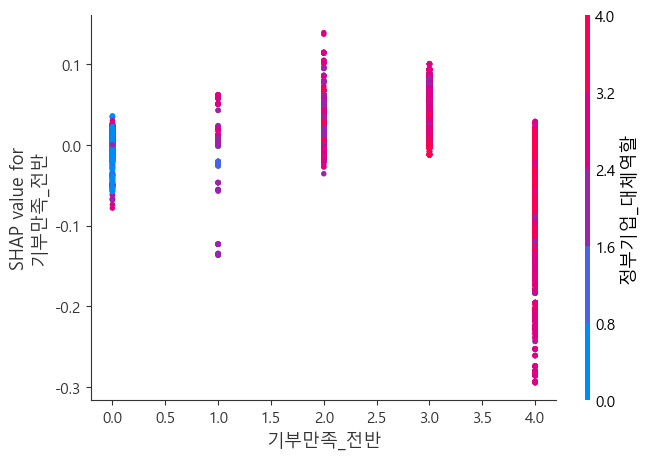

▶ 기부_정부보완 vs 기부_참여확산 상호작용 dependence plot 생성 중...



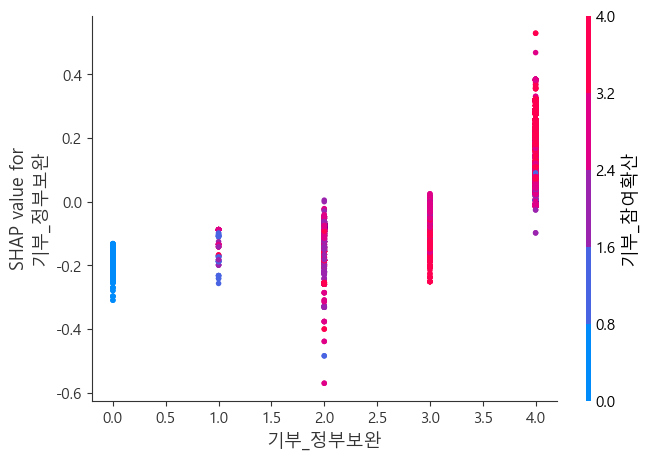

▶ 재정정보_공개 vs 기부충성도_추천의향 상호작용 dependence plot 생성 중...



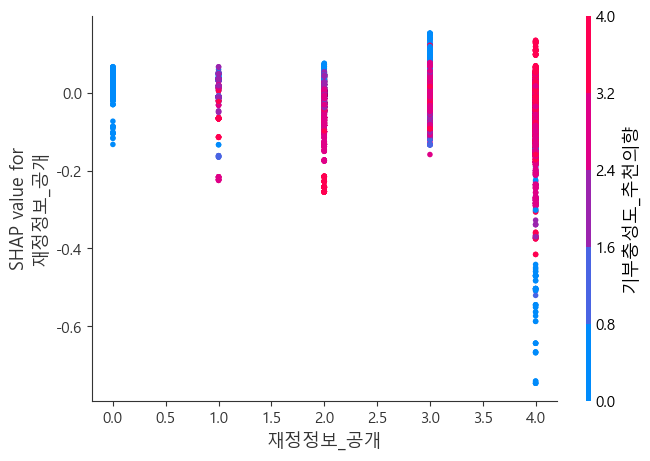

In [262]:
# 2) top10_corr에서 상위 3개 변수 추출
top3 = top10_corr.head(3)

# 3) dependence plot 자동 생성
for _, row in top3.iterrows():
    main_var = row["변수"]
    inter_var = row["자동 탐지된_상호작용변수"]
    
    print(f"▶ {main_var} vs {inter_var} 상호작용 dependence plot 생성 중...\n")
    
    shap.dependence_plot(
        main_var,
        shap_values.values,
        X,
        interaction_index=inter_var  # 상호작용 변수 직접 지정
    )


C:\Users\gram\AppData\Local\Temp\ipykernel_39816\2861563127.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20, x='shape-x상관', y='feature_pair', palette='viridis')


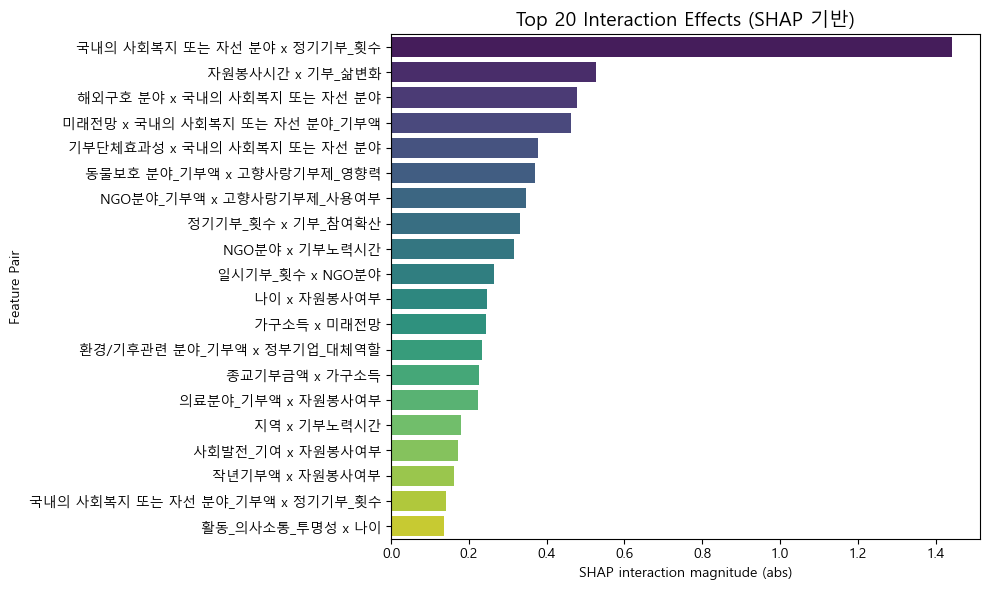

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\2861563127.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_matrix.applymap(lambda x: f"{x:.2f}" if x >= top_vals_threshold else "")


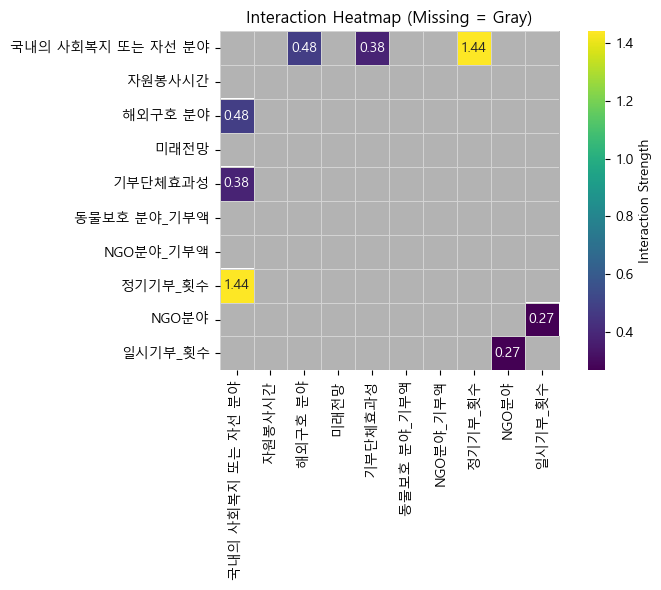

In [265]:
df['feature_pair'] = df['변수'] + " x " + df['자동 탐지된_상호작용변수']

# 상위 20개 (실제 df가 더 크다면 head(20))
top20 = df.sort_values('shape-x상관', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top20, x='shape-x상관', y='feature_pair', palette='viridis')
plt.xlabel("SHAP interaction magnitude (abs)")
plt.ylabel("Feature Pair")
plt.title("Top 20 Interaction Effects (SHAP 기반)", fontsize=14)
plt.tight_layout()
plt.show()

# -------------------------------
# 3. Top 10 변수 heatmap
# -------------------------------
# Top 20에서 feature 추출
#top_features = set(top20['변수']).union(set(top20['자동 탐지된_상호작용변수']))
#top_features = list(top_features)[:10]  # 최대 10개
top_features=top20['변수'].values.tolist()[:10]
# Heatmap용 상호작용 행렬 생성
heatmap_matrix = pd.DataFrame(0, index=top_features, columns=top_features, dtype=float)

# 값 채우기 (shape-x상관 사용)
for _, row in df.iterrows():
    f1, f2 = row['변수'], row['자동 탐지된_상호작용변수']
    if f1 in top_features and f2 in top_features:
        heatmap_matrix.loc[f1, f2] = row['shape-x상관']
        heatmap_matrix.loc[f2, f1] = row['shape-x상관']  # 대칭


# 상위 5개 값 추출
top_n = 20
flat_vals = heatmap_matrix.values.flatten()
top_vals_threshold = np.sort(flat_vals)[-top_n]  # 상위 5번째 값

# annot 매트릭스 생성: 조건에 따라 숫자 표시
annot = heatmap_matrix.applymap(lambda x: f"{x:.2f}" if x >= top_vals_threshold else "")

# 히트맵 그리기
heatmap_matrix.replace(0, np.nan, inplace=True)
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_matrix,
    cmap="viridis",      # 실제 값에 쓸 컬러맵
    linewidths=0.5,
    linecolor='lightgray',
    square=True,
    annot=annot,
    fmt="",
    mask=heatmap_matrix.isna(),  # 값이 없는 부분 숨기기(NaN)
    cbar_kws={'label': 'Interaction Strength'}
)

# NaN 부분을 회색으로 채우기
# 부분적으로 seaborn이 mask 처리에서 NaN을 완전 표시하지 않아 별도 처리 필요
plt.imshow(
    heatmap_matrix.isna(),
    cmap=plt.cm.gray_r,    # 회색 컬러맵
    alpha=0.3,             # 투명도
    extent=(0, len(top_features), len(top_features), 0)
)

plt.xticks(rotation=90)
plt.title("Interaction Heatmap (Missing = Gray)")
plt.tight_layout()
plt.show()

In [268]:
# variable_groups 안의 모든 feature 리스트 합치기
all_group_features = [f for features in variable_groups.values() for f in features]

# dat10.columns를 리스트로
dat_columns = dat10.columns.tolist()

# dat10에 존재하지만 variable_groups에 없는 컬럼 찾기
missing_in_groups = [col for col in dat_columns if col not in all_group_features]

print("variable_groups에 빠진 컬럼들:")
print(missing_in_groups)

variable_groups에 빠진 컬럼들:
['올해기부의향', '기부유형', '기부타입']


In [270]:

group_effect = compute_group_shap(shap_values, X_test, variable_groups)
group_effect

{'기본사항': 0.0844237709048191,
 '인구사회적_특성': 0.03913881035844874,
 '기부실태': 0.10217649198023548,
 '비영리 기부단체에 대한 인식': 0.024547455072284795,
 '기부로 인한 임팩트': 0.03390078865338452,
 '기부환경에_대한_인식': 0.059029587597327904,
 '자워봉사_실태': 0.30470251263304,
 '고향사랑기부제': 0.046714189969788884,
 '종교적_기부': 0.13811650721291482}

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\3849794629.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


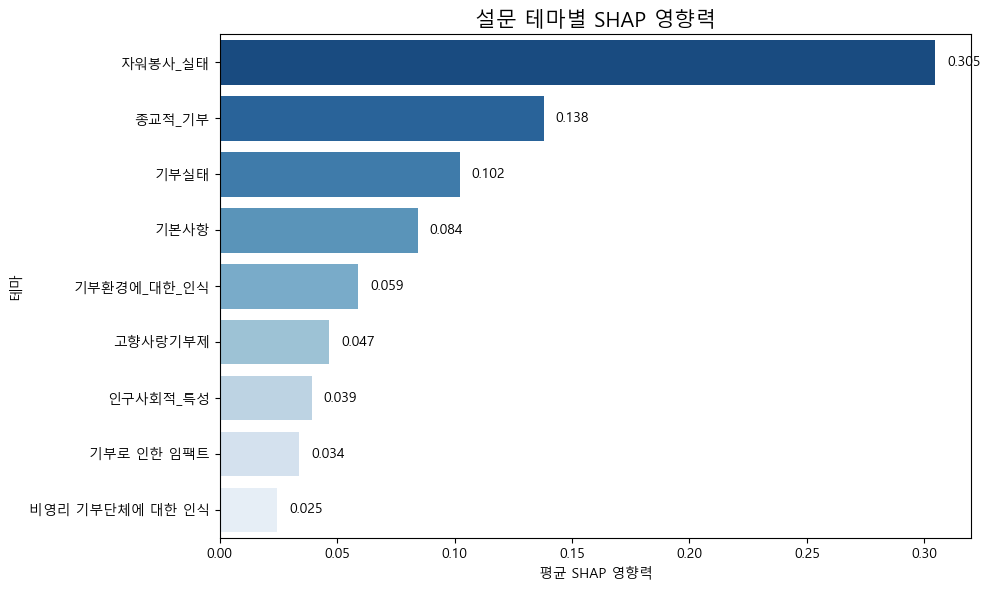

In [272]:
# 테마별 영향력 데이터 정리
theme_scores = {'기본사항': 0.0844237709048191,
 '인구사회적_특성': 0.03913881035844874,
 '기부실태': 0.10217649198023548,
 '비영리 기부단체에 대한 인식': 0.024547455072284795,
 '기부로 인한 임팩트': 0.03390078865338452,
 '기부환경에_대한_인식': 0.059029587597327904,
 '자워봉사_실태': 0.30470251263304,
 '고향사랑기부제': 0.046714189969788884,
 '종교적_기부': 0.13811650721291482}

df_theme = pd.DataFrame({
    "테마": list(theme_scores.keys()),
    "영향력": list(theme_scores.values())
})

plt.figure(figsize=(10, 6))

# 바플롯
ax = sns.barplot(
    data=df_theme.sort_values("영향력", ascending=False),
    x="영향력",
    y="테마",
    palette="Blues_r"
)

# 바 위에 숫자 표시
for i, (value) in enumerate(df_theme.sort_values("영향력", ascending=False)["영향력"]):
    plt.text(
        x=value + 0.005,   # 약간 오른쪽에 표시
        y=i,               # 해당 bar의 y 위치
        s=f"{value:.3f}",  # 표시할 숫자
        va='center'
    )

plt.title("설문 테마별 SHAP 영향력", fontsize=15)
plt.xlabel("평균 SHAP 영향력")
plt.ylabel("테마")
plt.tight_layout()
plt.show()

In [273]:
# -------------------------------
# 1. 테마별 top 3 변수 선택
# -------------------------------
all_features = [f for grp in variable_groups.values() for f in grp]

shap_values_df= pd.DataFrame(shap_values.values, columns=all_features)
theme_top_vars = {}

for theme, features in variable_groups.items():
    # 해당 테마 feature 중 shap_values_df에 존재하는 것만 필터링
    valid_features = [f for f in features if f in dat10.columns]
    
    if not valid_features:
        continue  # 테마에 데이터가 없으면 건너뜀
    
    # 각 feature별 평균 절대 SHAP 값 계산
    mean_abs_shap = shap_values_df[valid_features].abs().mean(axis=0)
    
    # 내림차순 정렬 후 top 3 선택
    top3 = mean_abs_shap.sort_values(ascending=False).head(3)
    
    # 딕셔너리로 저장
    theme_top_vars[theme] = top3.to_dict()

# -------------------------------
# 2. 결과 확인
# -------------------------------
for theme, top_vars in theme_top_vars.items():
    print(f"{theme}: {top_vars}")

기본사항: {'지역': 0.17927731749040307, '나이': 0.1258061464807701, '성별': 0.08698376372687211}
인구사회적_특성: {'종교': 0.24397247129316288, '소득변화': 0.1417500077166351, '고용상태': 0.046019875674452516}
기부실태: {'일시기부_횟수': 0.46335367165742275, '초/중/고/대학교 교육분야_기부액': 0.3698326563676368, '국내의 사회복지 또는 자선 분야_기부액': 0.34724394697514077}
비영리 기부단체에 대한 인식: {'취약계층_지원': 1.4419814643588167, '운영정보_공개': 0.5259389530051527, '삶의질_향상': 0.47795035536996594}
기부로 인한 임팩트: {'기부_도움제공': 0.17304878796503032, '기부자지향성_관계형성': 0.13528189869872317, '기부자지향성_관심도': 0.11292067703452527}
기부환경에_대한_인식: {'상한선이유': 0.07198331036908515, '기부수준인식': 0.04588020348386356, '기부수준_낮은이유': 0.04393766295611784}
자워봉사_실태: {'자원봉사시간': 0.07857077155162788, '자원봉사여부': 0.04279533129517397}
고향사랑기부제: {'고향사랑기부제_영향력': 0.3786131265536363, '고향사랑기부제여부': 0.027900543421403388, '고향사랑기부제_사용여부': 0.02708119795304419}
종교적_기부: {'종교기부금액': 0.028239343519044436, '종교기부여부': 0.024118886326850626}


C:\Users\gram\AppData\Local\Temp\ipykernel_39816\523655686.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=shap_vals, y=var_names, palette="plasma")
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\523655686.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=shap_vals, y=var_names, palette="plasma")
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\523655686.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=shap_vals, y=var_names, palette="plasma")
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\523655686.py:23

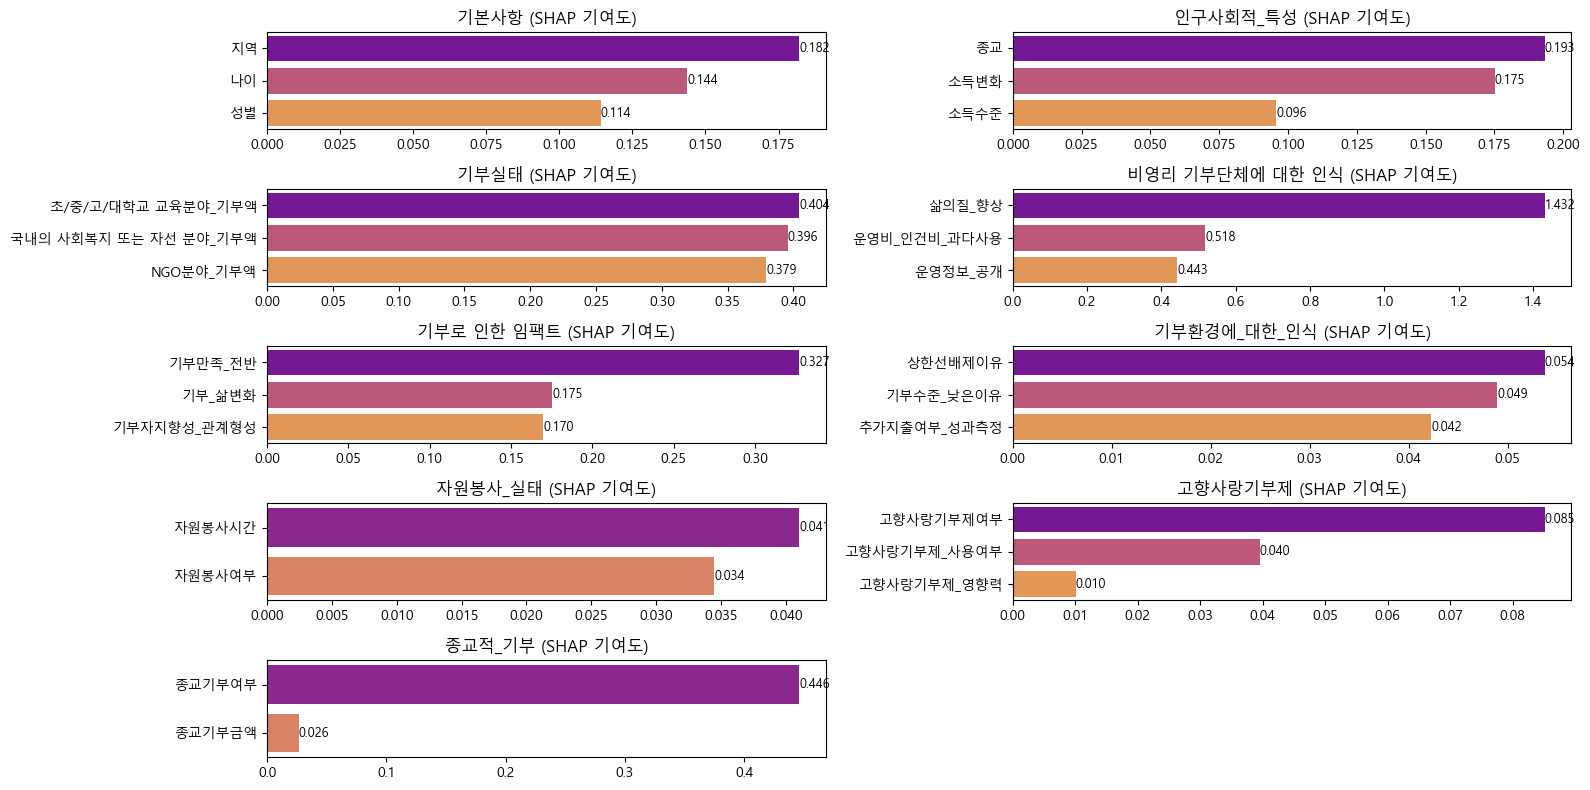

In [274]:
theme_top_vars = {'기본사항': {'지역': 0.18207400429914733, '나이': 0.1437438218798776, '성별': 0.11410765198934368},
'인구사회적_특성': {'종교': 0.19332087152405408, '소득변화': 0.17512118596785872, '소득수준': 0.09568464663172918},
'기부실태': {'초/중/고/대학교 교육분야_기부액': 0.40440993961590815, '국내의 사회복지 또는 자선 분야_기부액': 0.3957978444042623, 'NGO분야_기부액': 0.379495730024093},
'비영리 기부단체에 대한 인식': {'삶의질_향상': 1.4318226487410164, '운영비_인건비_과다사용': 0.5180814380656518, '운영정보_공개': 0.4430319023508188},
'기부로 인한 임팩트': {'기부만족_전반': 0.32710954572538814, '기부_삶변화': 0.1752651266047061, '기부자지향성_관계형성': 0.16968660259202728},
'기부환경에_대한_인식': {'상한선배제이유': 0.05377424254363172, '기부수준_낮은이유': 0.048976229266349994, '추가지출여부_성과측정': 0.04229068029100227},
'자원봉사_실태': {'자원봉사시간': 0.04102983196652452, '자원봉사여부': 0.03448736515912204},
'고향사랑기부제': {'고향사랑기부제여부': 0.08516443115824474, '고향사랑기부제_사용여부': 0.0395692996969626, '고향사랑기부제_영향력': 0.010122494378480746},
'종교적_기부': {'종교기부여부': 0.4460789182416811, '종교기부금액': 0.02647693321176571}}
# 원하는 subplot 구조 지정
rows = 5
cols = 2

plt.figure(figsize=(16, 8))

for i, (theme, vars_dict) in enumerate(theme_top_vars.items(), 1):
    plt.subplot(rows, cols, i)
    
    # 데이터 준비
    var_names = list(vars_dict.keys())
    shap_vals = list(vars_dict.values())
    
    ax = sns.barplot(x=shap_vals, y=var_names, palette="plasma")

    # ---- 바 끝에 숫자 표시 ----
    for p in ax.patches:
        width = p.get_width()                 # bar 길이 (SHAP 값)
        y = p.get_y() + p.get_height() / 2    # bar 중앙 위치
        ax.text(
            width,                             # bar 끝 x 위치
            y,                                 # 해당 bar y 중앙 
            f"{width:.3f}",                    # 표시할 숫자
            va='center',
            ha='left',                         # bar 끝 오른쪽에 표시
            fontsize=9,
            color='black'
        )

    plt.title(f"{theme} (SHAP 기여도)", fontsize=12)
    #plt.xlabel("평균 SHAP 값")
    #plt.ylabel("변수명")

plt.tight_layout()
plt.show()

# Ⅲ. 기부자 유형(PERSONA) 분석(Q16~Q20)

k=2, silhouette score=0.0831
k=3, silhouette score=0.0904
k=4, silhouette score=0.1045
k=5, silhouette score=0.0957
k=6, silhouette score=0.0889
k=7, silhouette score=0.0898
k=8, silhouette score=0.0872
k=9, silhouette score=0.0936
k=10, silhouette score=0.0983

🔥 Best k (Silhouette) = 4


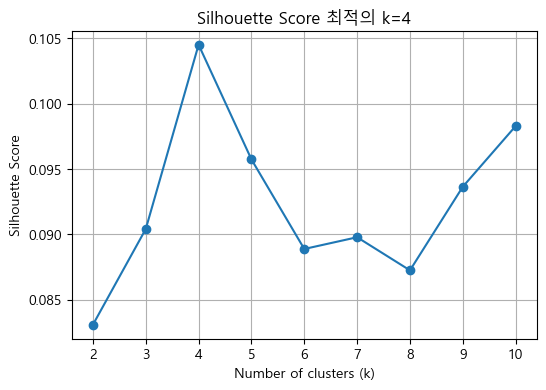

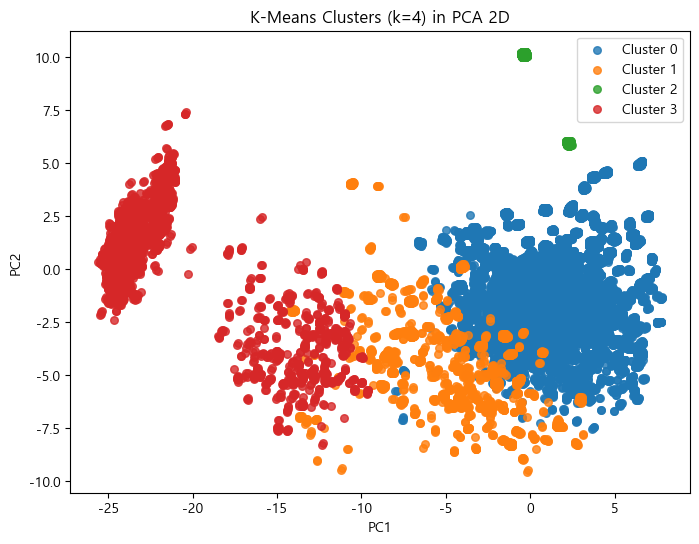

In [278]:

# 최종 feature: 설문 numeric + SHAP values
X = np.hstack([shap_values.values, dat10.values])

# ------------------------------
# 2) 스케일링
# ------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1) 최적 k 탐색 (Silhouette Score)
# -----------------------------
range_k = range(2, 11)  # k 후보
sil_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"k={k}, silhouette score={score:.4f}")

best_k = range_k[np.argmax(sil_scores)]
print("\n🔥 Best k (Silhouette) =", best_k)

# Silhouette score 시각화
plt.figure(figsize=(6,4))
plt.plot(range_k, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score 최적의 k=4")
plt.grid(True)
plt.show()

# -----------------------------
# 2) Best k로 K-Means 실행
# -----------------------------
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# -----------------------------
# 3) PCA 2D로 차원 축소
# -----------------------------
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_scaled)

# -----------------------------
# 4) PCA 2D Scatter + 군집별 색상
# -----------------------------
plt.figure(figsize=(8,6))
for i in range(best_k):
    plt.scatter(
        X_2d[labels==i,0],
        X_2d[labels==i,1],
        s=30,
        alpha=0.8,
        label=f"Cluster {i}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means Clusters (k={best_k}) in PCA 2D")
plt.legend()
plt.show()

In [279]:
# 1) 군집 컬럼 추가
df = dat10.copy()
df['cluster'] = labels
df=df.drop(['올해기부의향','cluster'],axis=1)
# 3) SHAP 기여도 평균으로 군집 특징 확인
shap_df = pd.DataFrame(shap_values.values, columns=df.columns)
shap_df['cluster'] = labels
def signed_abs_mean(df):
    df = df.drop(columns='cluster')
    
    mean_shap = df.mean()
    mean_abs_shap = df.abs().mean()
    
    # 방향 유지: abs_mean * sign(mean)
    return mean_abs_shap * np.sign(mean_shap)

# 클러스터별 signed abs mean SHAP
cluster_signed_mean = shap_df.groupby("cluster").apply(signed_abs_mean)

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\3864889738.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_signed_mean = shap_df.groupby("cluster").apply(signed_abs_mean)


In [280]:
cluster_abs_importance = (
    shap_df
        .groupby('cluster')
        .apply(lambda x: x[shap_df.columns[:-1]].abs().mean())
)

# 2) 클러스터별 방향(+) 또는 (–)
cluster_direction = (
    shap_df
        .groupby('cluster')
        .apply(lambda x: x[shap_df.columns[:-1]].mean().apply(np.sign))
)
# 클러스터별 중요도 matrix: (4 × 102)
mat = cluster_abs_importance.values

# 각 변수별 집단 간 분산(variance)
feature_variance = cluster_abs_importance.var(axis=0)

# 차별성이 높은 변수 Top20
distinctive_vars = feature_variance.sort_values(ascending=False).head(15)

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\687223853.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shap_df
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\687223853.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shap_df


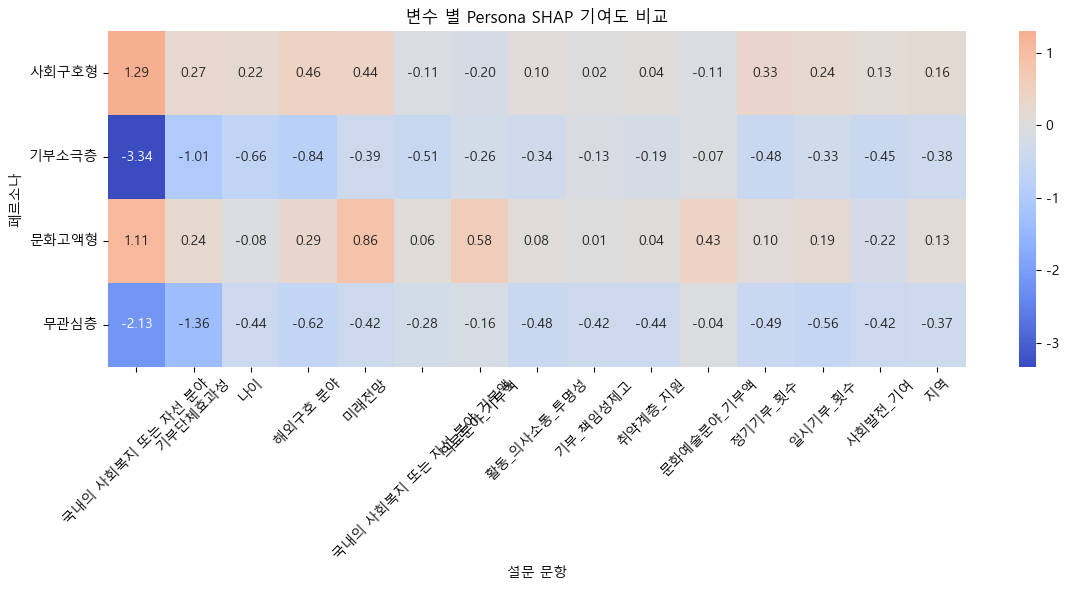

In [281]:
# ---- 1. Persona 0~2만 선택 ----
persona_subset=cluster_signed_mean.loc[[0,1,2,3]]
persona_subset.index=[0,1,2,3]
# ---- 2. 컬럼별 max-min 계산 ----

# ---- 3. 상위 10개 변수 선택 ----
top_cols = distinctive_vars.index.tolist()
persona_top_diff = persona_subset[top_cols]

# ---- 4. Heatmap 시각화 ----
plt.figure(figsize=(12,6))
sns.heatmap(
    persona_top_diff,         # persona_top_diff: (군집 x feature) DataFrame
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    yticklabels=['사회구호형','기부소극층','문화고액형','무관심층'],
    xticklabels=persona_top_diff.columns
)

plt.title("변수 별 Persona SHAP 기여도 비교")
plt.xlabel("설문 문항")
plt.ylabel("페르소나")
plt.yticks(rotation=0)   # y축 라벨 수직
plt.xticks(rotation=45)  # x축 라벨은 보기 좋게 45도 회전
plt.tight_layout()
plt.show()

기부타입      0     1      2  Total
사회구호형    16     0  40061  40077
기부소극층    41     0   2407   2448
문화고액형     0     0   2830   2830
무관심층   1787  1429     11   3227
합계     1844  1429  45309  48582


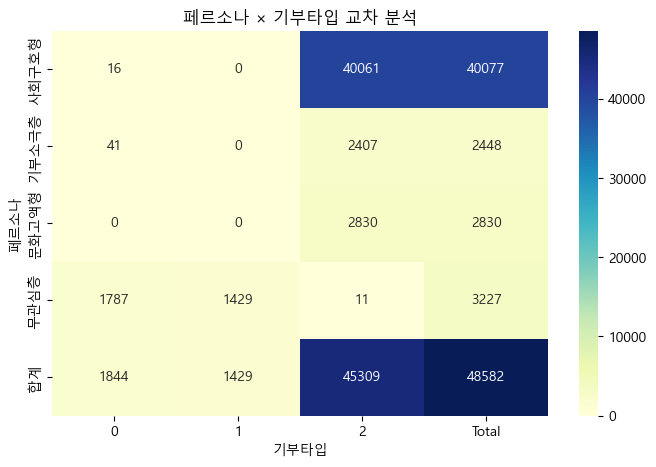

In [287]:
# --------------------------------------
# 1. 교차표 (합계 포함)
# --------------------------------------
cross_tab = pd.crosstab(labels, dat10['기부타입'], margins=True, margins_name='Total')
# 0~4 인덱스를 페르소나 이름으로 변경
persona_names = ['사회구호형','기부소극층','문화고액형','무관심층','합계']
#["정기적·직장 참여형","멀티채널 활발형","무관심/비참여형",
#                 "온라인/포인트 중심형","단체 후원 선호형",'합계']

cross_tab.index = persona_names
print(cross_tab)

# --------------------------------------
# 2. Heatmap 시각화
# --------------------------------------
plt.figure(figsize=(8,5))
sns.heatmap(cross_tab.iloc[:, :], annot=True, fmt='d', cmap='YlGnBu', cbar=True)  # Total 제외 후 표시
plt.title("페르소나 × 기부타입 교차 분석")
plt.xlabel("기부타입")
plt.ylabel("페르소나")
plt.show()

In [301]:
dat10['페르소나']=labels
viz=dat10[['성별', '지역','나이','세대',
'가구원수','혼인상태', '자녀여부', '종교', '고용상태', '가구소득', '소득변화', '학벌','소득수준','기부타입','페르소나']]
viz['무관심형']=0
for idx in range(len(viz)):
    if viz['페르소나'][idx]==3:
        viz['무관심형'][idx]='무관심형'
    else:
        viz['무관심형'][idx]='나머지'
viz=viz.drop(['페르소나','기부타입'],axis=1)
continuous_vars = ['나이','가구원수','가구소득']
categorical_vars = ['성별','지역','세대','혼인상태','자녀여부','종교','고용상태','소득변화','학벌','소득수준']
#viz.columns=['성별','지역','나이','가구원수','혼인상태','자녀여부','종교','고용상태','가구소득','전년도소득변화','학벌','나이','기부타입','페르소나','무관심형']

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\547382157.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz['무관심형']=0
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\547382157.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instea

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\1624446198.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\1624446198.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\1624446198.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


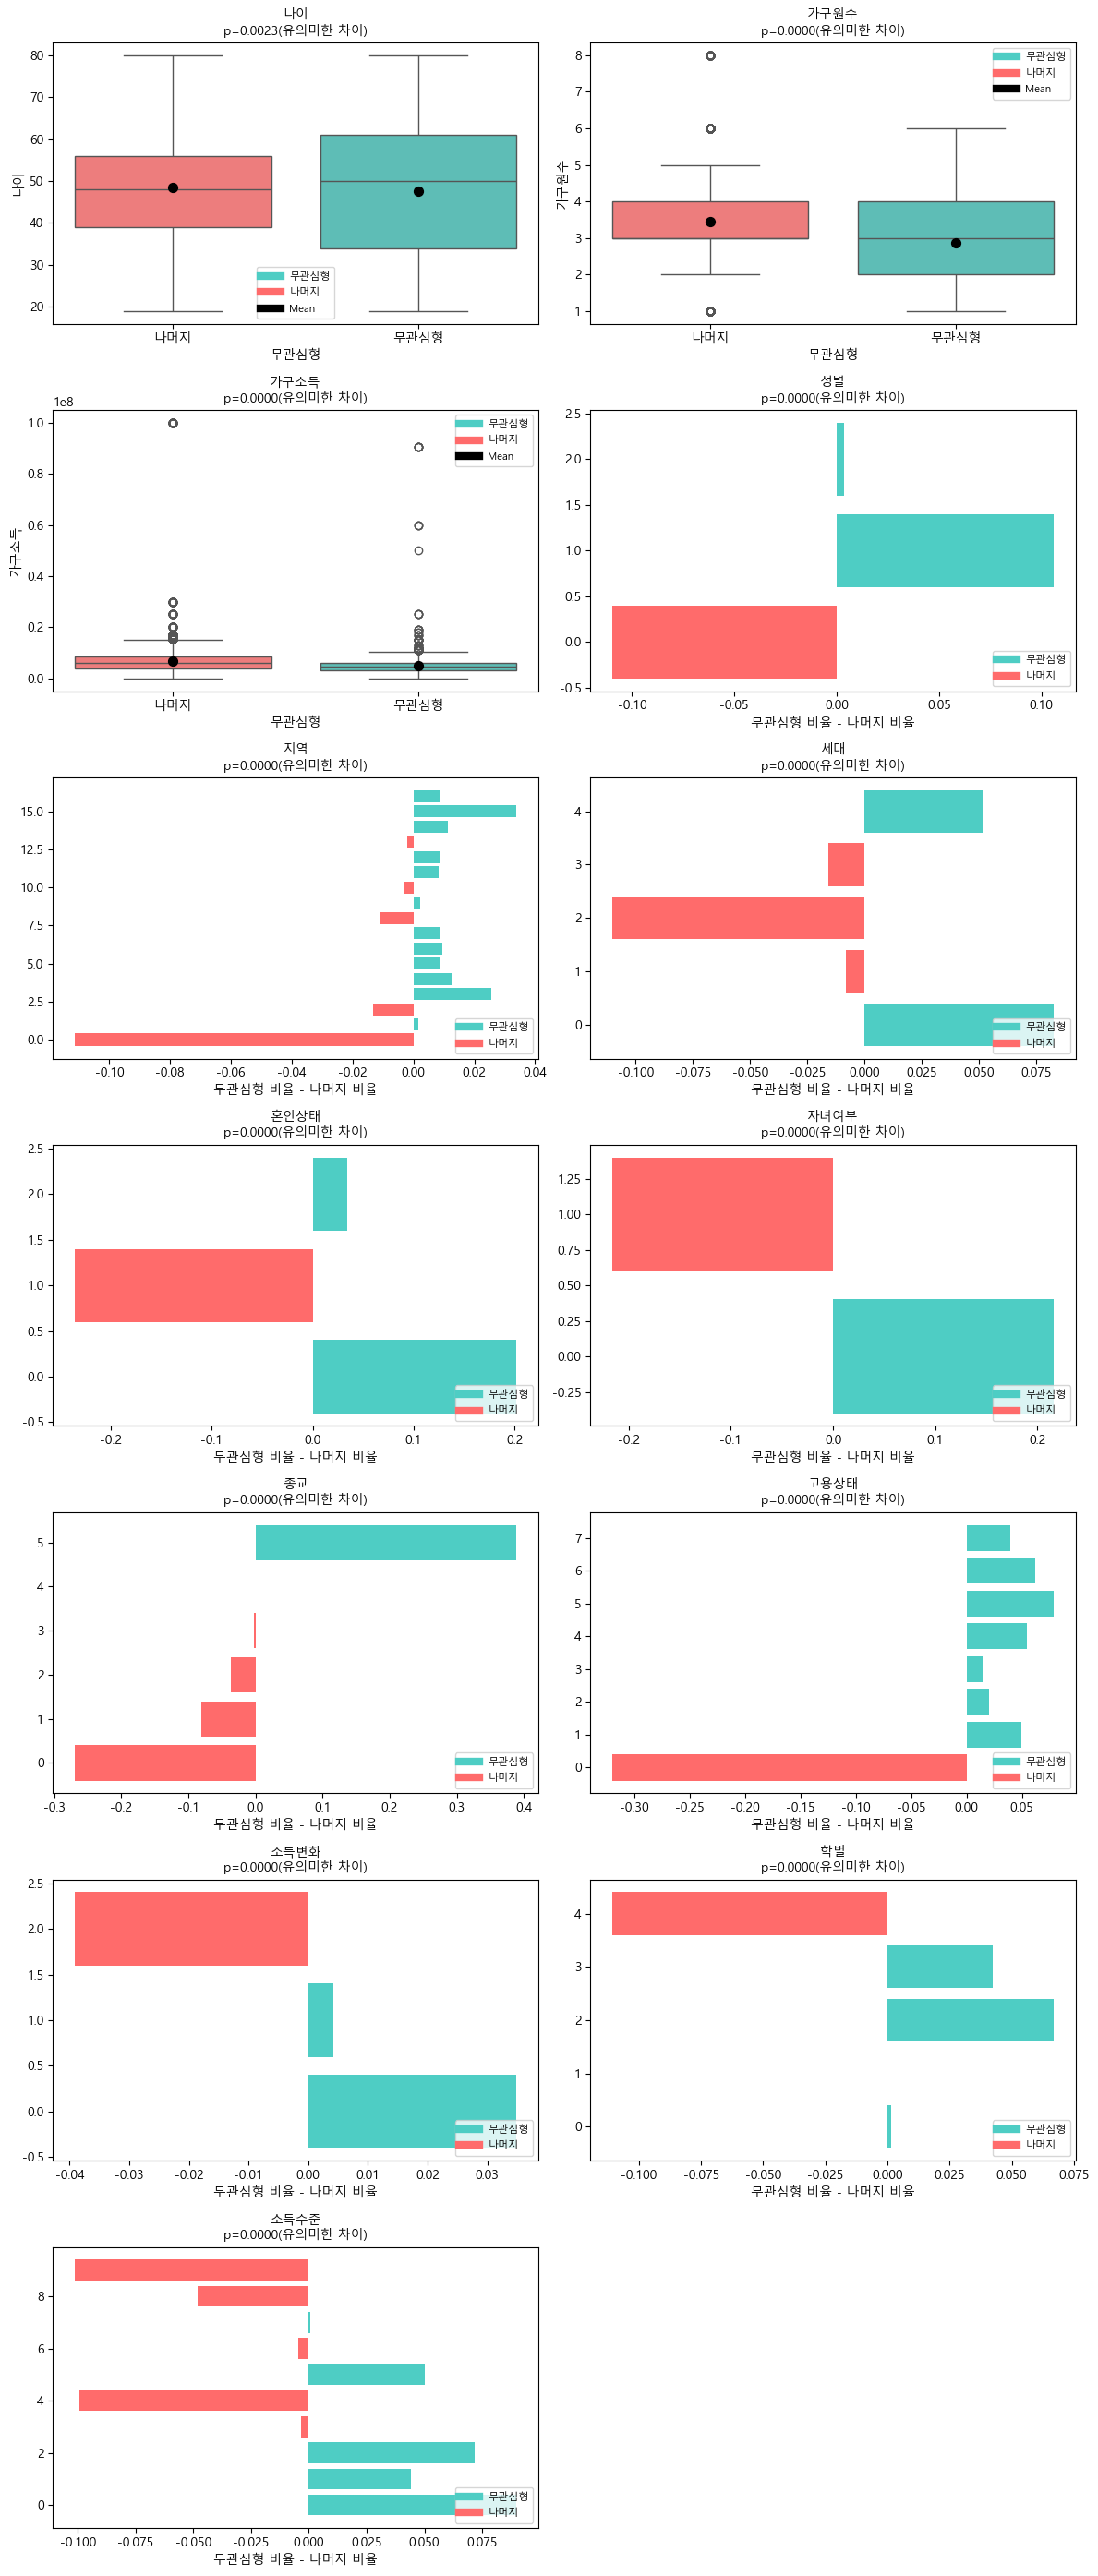

In [303]:

# -------------------------------
# 변수 설정
# -------------------------------
continuous_vars = ['나이','가구원수','가구소득']
categorical_vars = ['성별','지역','세대','혼인상태','자녀여부','종교','고용상태','소득변화','학벌','소득수준']
# -------------------------------
# 통계검정 & p-value 계산
# -------------------------------
alpha = 0.05
results = []

for col in continuous_vars:
    group0 = viz[viz['무관심형']=='나머지'][col].dropna()
    group1 = viz[viz['무관심형']=='무관심형'][col].dropna()
    stat, p = stats.ttest_ind(group0, group1)
    results.append({'variable': col, 'test':'t-test', 'p_value': p})

for col in categorical_vars:
    contingency = pd.crosstab(viz[col], viz['무관심형'])
    stat, p, dof, expected = stats.chi2_contingency(contingency)
    results.append({'variable': col, 'test':'chi2', 'p_value': p})

results_df = pd.DataFrame(results)
significant_vars = results_df[results_df['p_value'] < alpha]['variable'].tolist()

# -------------------------------
# 대시보드 스타일 시각화
# -------------------------------
num_vars = len(significant_vars)
cols = 2
rows = math.ceil(num_vars / cols)
plt.figure(figsize=(cols*6, rows*4))

# 색상 지정
palette_continuous = {'나머지':'#FF6B6B', '무관심형':'#4ECDC4'}  # 나머지=빨강, 무관심=파랑

for i, col in enumerate(significant_vars):
    plt.subplot(rows, cols, i+1)
    p_val = results_df.loc[results_df['variable']==col, 'p_value'].values[0]

    if col in continuous_vars:
        # 연속형 boxplot
        sns.boxplot(
            x='무관심형', 
            y=col, 
            data=viz, 
            palette=palette_continuous
        )
        # 그룹 평균 표시
        means = viz.groupby('무관심형')[col].mean()
        plt.scatter([0,1], [means['나머지'], means['무관심형']], color='black', zorder=10, s=50, label='Mean')
        plt.xticks([0,1], ['나머지','무관심형'])
        plt.title(f"{col}\np={p_val:.4f}(유의미한 차이)", fontsize=10)
        # 범례 추가
        handles = [
            plt.Line2D([0], [0], color='#4ECDC4', lw=6, label='무관심형'),
            plt.Line2D([0], [0], color='#FF6B6B', lw=6, label='나머지'),
            plt.Line2D([0], [0], color='black', lw=6, label='Mean')
        ]
        plt.legend(handles=handles, fontsize=8)

    else:
        # 범주형 Difference Bar Plot
        prop_df = viz.groupby(['무관심형', col]).size().reset_index(name='count')
        prop_df['prop'] = prop_df.groupby('무관심형')['count'].transform(lambda x: x / x.sum())
        diff_df = prop_df.pivot(index=col, columns='무관심형', values='prop').fillna(0)
        diff_df['diff'] = diff_df['무관심형'] - diff_df['나머지']  # 무관심 - 나머지
        diff_df = diff_df.sort_values('diff')
        colors = ['#4ECDC4' if x>0 else '#FF6B6B' for x in diff_df['diff']]  # 무관심 파랑, 나머지 빨강
        plt.barh(diff_df.index, diff_df['diff'], color=colors)
        plt.xlabel('무관심형 비율 - 나머지 비율')
        plt.title(f"{col}\np={p_val:.4f}(유의미한 차이)", fontsize=10)
        # 범주형도 legend 추가
        handles = [
            plt.Line2D([0], [0], color='#4ECDC4', lw=6, label='무관심형'),
            plt.Line2D([0], [0], color='#FF6B6B', lw=6, label='나머지')
        ]
        plt.legend(handles=handles, fontsize=8, loc='lower right')

plt.tight_layout()
plt.show()

In [308]:
cols_22 = ['페르소나','기부타입',
    "활동_의사소통_투명성",
    "비전_목표_제시",
    "재정정보_공개",
    "사업수행_정보공개",
    "운영정보_공개",
    "다양한_정보공개수단",
    "시민_의견제시수단",
    "문의사항_정확응답",
    "시민의견_반영",
    "법률준수",
    "사회발전_기여",
    "기부금_적절사용",
    "모금활동_적절성",
    "윤리적_운영",
    "전반적_신뢰도",
    "정부기업_대체역할",
    "취약계층_지원",
    "삶의질_향상",
    "운영비_인건비_과다사용",
    "사회이슈_해결기여",
    "공익_대변",
    "특정집단_대변"
]
impact_cols=['기부만족_전반',
       '기부만족_기대충족', '기부자지향성_관심도', '기부자지향성_관계형성', '기부자지향성_장기관계', '기부자지향성_욕구파악',
       '기부충성도_재기부의향', '기부충성도_증액의향', '기부충성도_추천의향', '기부충성도_최우선기부','기부노력시간',
       '기부단체효과성','기부_긍정영향',
       '기부_도움제공', '기부_삶변화', '기부_사회임팩트', '기부_참여확산', '기부_책임성제고', '기부_정부보완',
       '기부_사회인식제고','사회변화도', '정보요청', '관심표현']
persona_map = {
    0: "사회구호형",
    1: "기부소극층",
    2: "문화고액형",
    3: "무관심형"
}

dat10["persona_category"] = dat10["페르소나"].map(persona_map)
persona_means = dat10.groupby("persona_category")[cols_22[2:]].mean().T

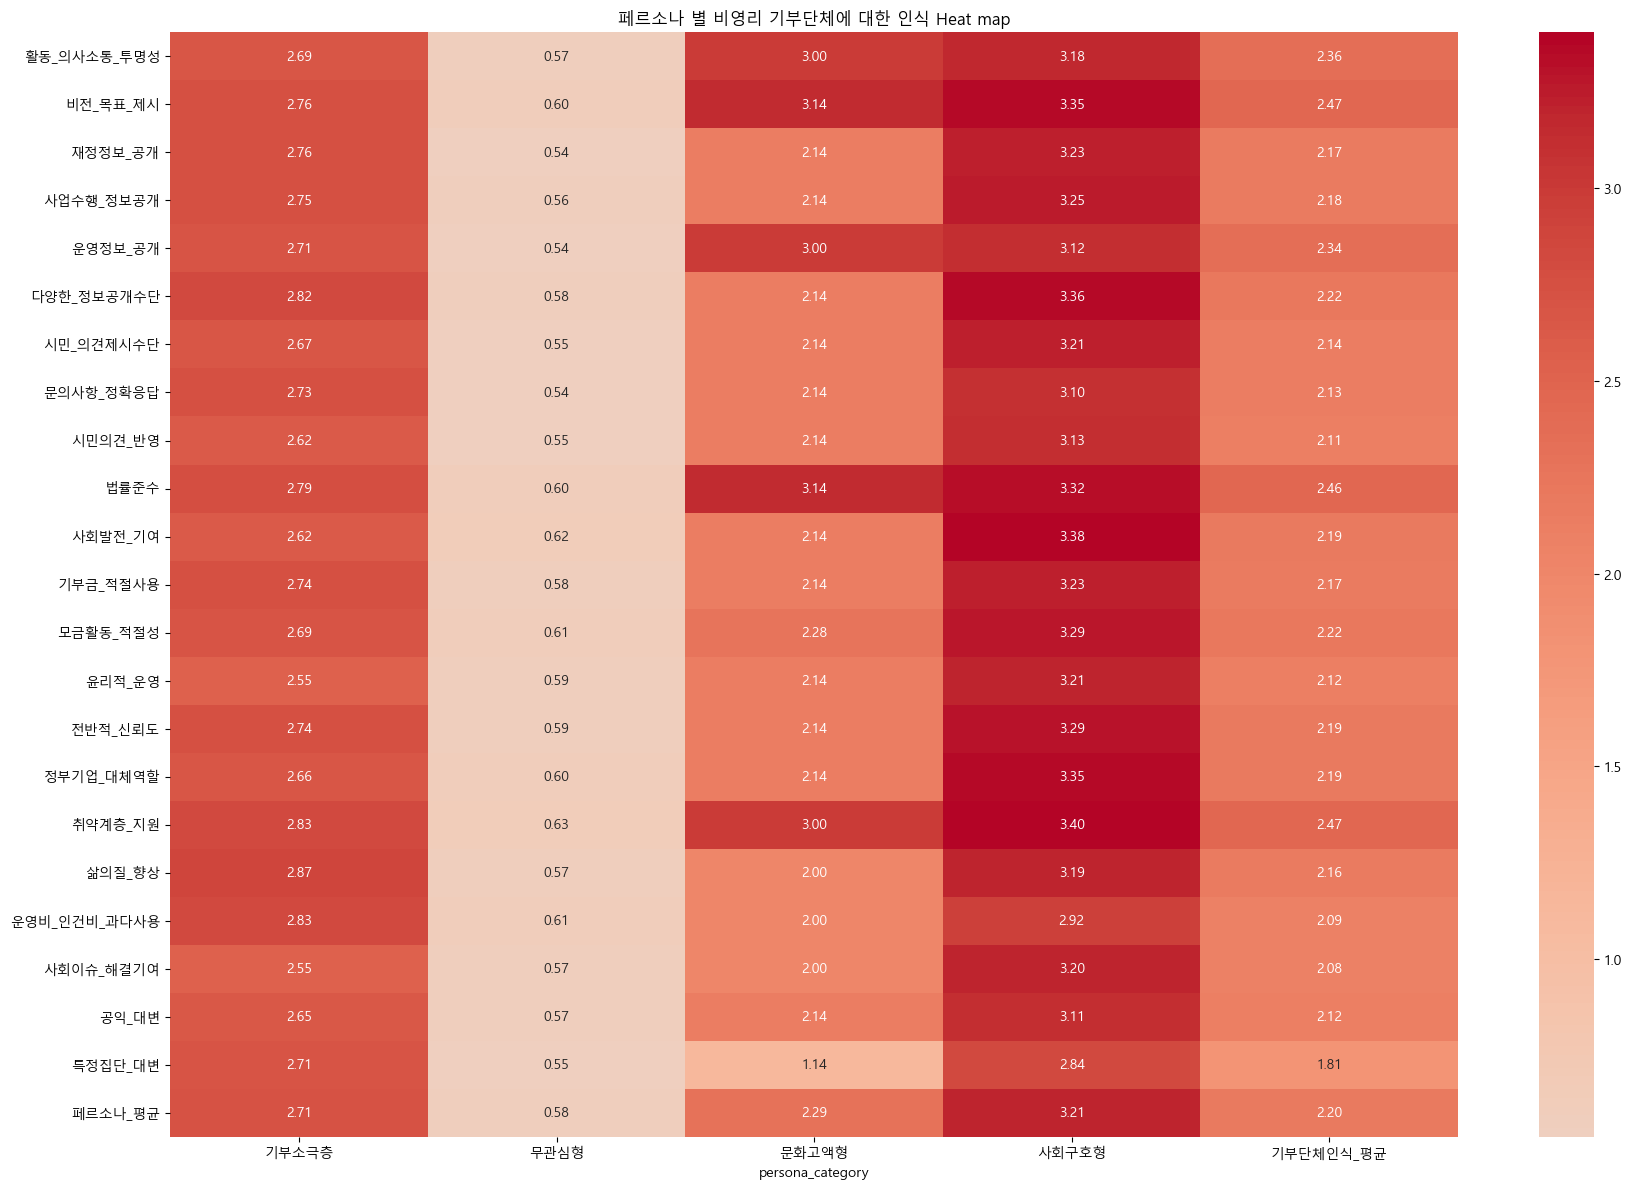

In [305]:
# -----------------------------
# 2. 행(Row) 합계 추가
# -----------------------------
df=persona_means.copy()
df['기부단체인식_평균'] = df.mean(axis=1)

# -----------------------------
# 3. 열(Column) 합계 추가
# -----------------------------
col_total = df.mean(axis=0)
df.loc['페르소나_평균'] = col_total

# -----------------------------

# -----------------------------
# 5. 합계를 포함한 히트맵 시각화
# -----------------------------
plt.figure(figsize=(18, 12))
sns.heatmap(df, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("페르소나 별 비영리 기부단체에 대한 인식 Heat map")
plt.tight_layout()
plt.show()

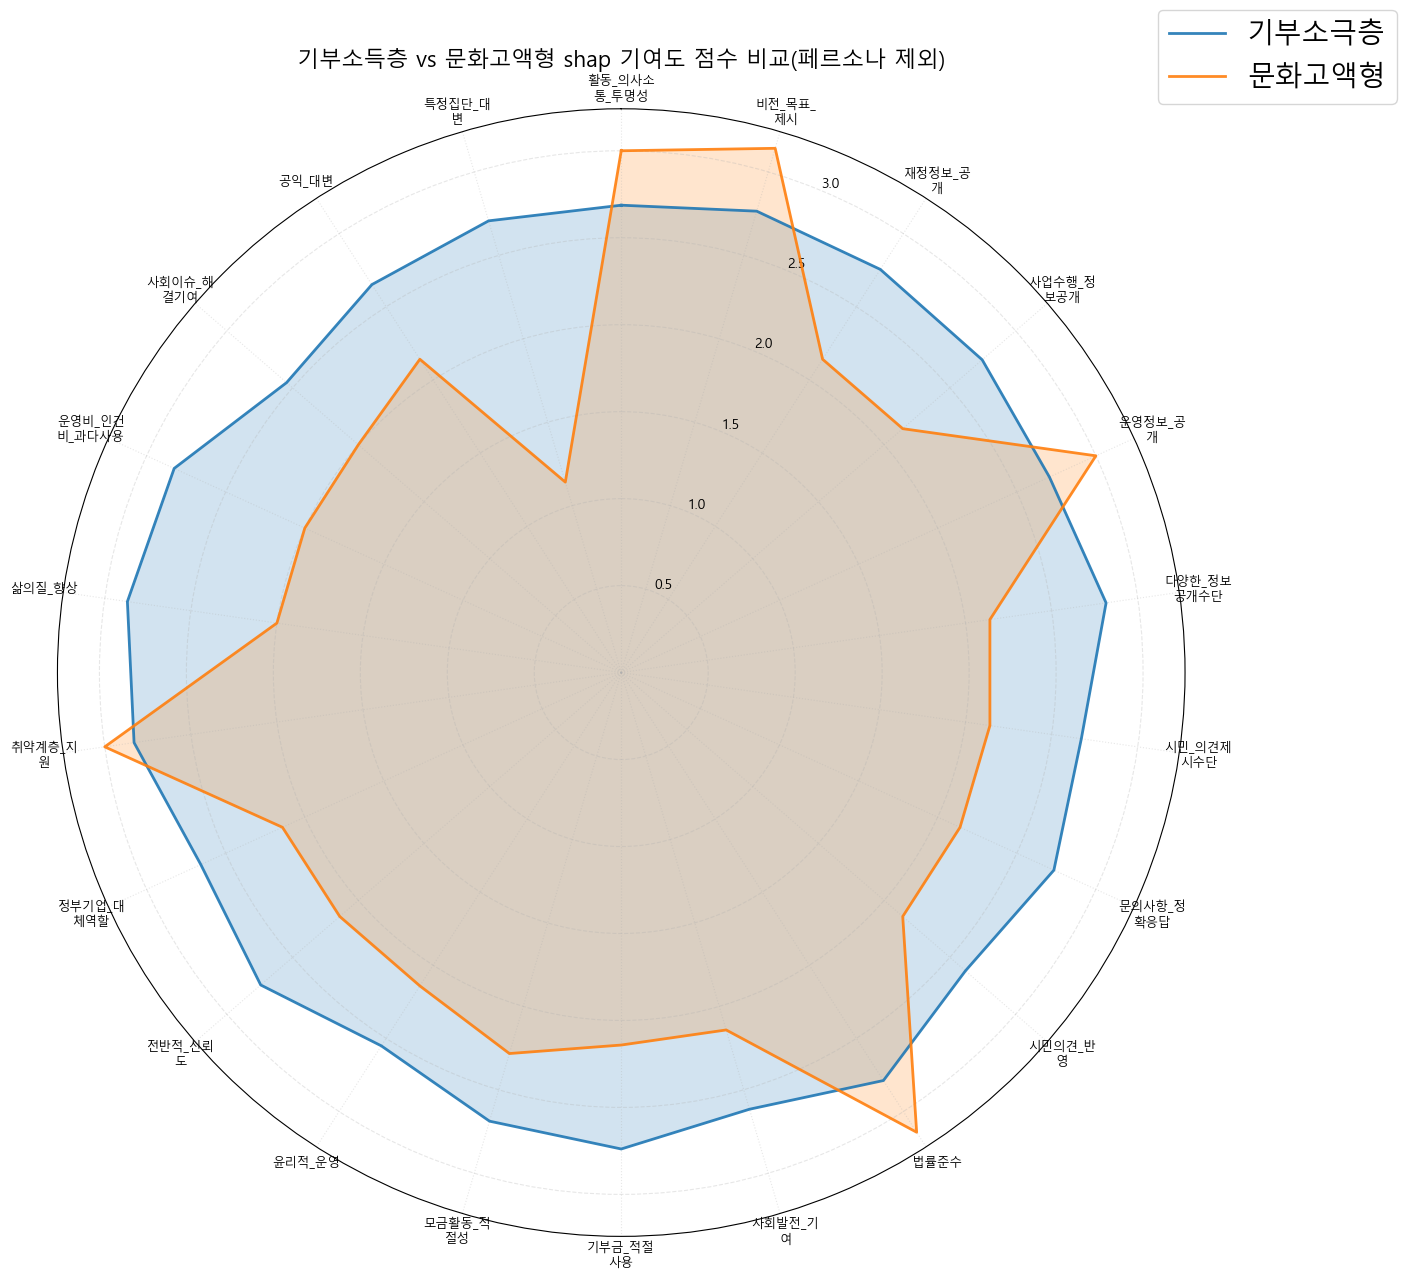

In [316]:
# ----------------------------------------------------------
# 2) 예시 데이터 생성 (사용자는 dat만 넣으면 됨)
# ----------------------------------------------------------

groupA = 1
groupB = 2

df_A = dat10[dat10["페르소나"] == groupA]
df_B = dat10[dat10["페르소나"] == groupB]

# ----------------------------------------------------------
# '페르소나' 항목 제거
# ----------------------------------------------------------
cols_radar = [c for c in cols_22 if c != "페르소나"]
cols_radar = [c for c in cols_radar if c != "기부타입"]
# 22개 문항별 평균 (페르소나 제외)
vals_A = df_A[cols_radar].mean().values
vals_B = df_B[cols_radar].mean().values

# ----------------------------------------------------------
# 3) 레이더차트용 세팅
# ----------------------------------------------------------
N = len(cols_radar)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

vals_A = np.concatenate([vals_A, [vals_A[0]]])
vals_B = np.concatenate([vals_B, [vals_B[0]]])

# ----------------------------------------------------------
# 4) 라벨 줄바꿈 (최적화)
# ----------------------------------------------------------
def wrap_label(label, width=6):
    return "\n".join(textwrap.wrap(label, width=width))

wrapped_labels = [wrap_label(l, width=6) for l in cols_radar]

# ----------------------------------------------------------
# 5) 레이더차트 그리기
# ----------------------------------------------------------
plt.figure(figsize=(14, 14))
ax = plt.subplot(111, polar=True)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], wrapped_labels, fontsize=9)

# 그리드 라인 최소화
ax.yaxis.grid(True, linestyle="--", alpha=0.3)
ax.xaxis.grid(True, linestyle=":", alpha=0.3)

# 그룹 A
ax.plot(angles, vals_A, linewidth=2.0, alpha=0.9, label=f"기부소극층")
ax.fill(angles, vals_A, alpha=0.2)

# 그룹 B
ax.plot(angles, vals_B, linewidth=2.0, alpha=0.9, label=f"문화고액형")
ax.fill(angles, vals_B, alpha=0.2)

plt.title("기부소득층 vs 문화고액형 shap 기여도 점수 비교(페르소나 제외)", fontsize=16)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), fontsize=20)
plt.tight_layout()
plt.show()

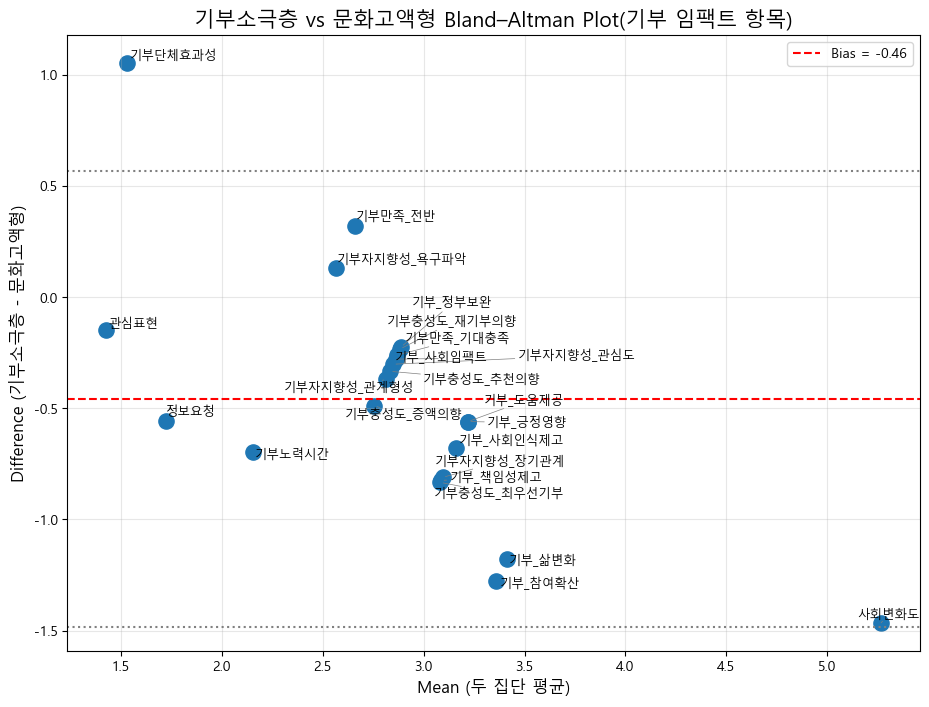

In [317]:
forviz=dat10[impact_cols+['페르소나']]
forviz=forviz.drop_duplicates().reset_index(drop=True)
df_low = forviz[forviz['페르소나'] == 1]
df_high = forviz[forviz['페르소나'] == 2]

x_vals = []
y_vals = []
labels = []

# 각 항목별로 평균 계산
for col in impact_cols:
    low_mean = df_low[col].mean()
    high_mean = df_high[col].mean()

    x = (low_mean + high_mean) / 2
    y = low_mean - high_mean

    x_vals.append(x)
    y_vals.append(y)
    labels.append(col)

plt.figure(figsize=(11,8))
plt.scatter(x_vals, y_vals, s=120)

# Bias + Limits of Agreement
bias = np.mean(y_vals)
sd = np.std(y_vals)

plt.axhline(bias, color='red', linestyle='--', label=f'Bias = {bias:.2f}')
plt.axhline(bias + 1.96 * sd, color='gray', linestyle=':')
plt.axhline(bias - 1.96 * sd, color='gray', linestyle=':')

# 텍스트 자동 조정
texts = []
for i, label in enumerate(labels):
    texts.append(plt.text(x_vals[i], y_vals[i], label, fontsize=9))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.title("기부소극층 vs 문화고액형 Bland–Altman Plot(기부 임팩트 항목)", fontsize=15)
plt.xlabel("Mean (두 집단 평균)", fontsize=12)
plt.ylabel("Difference (기부소극층 - 문화고액형)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Ⅴ. 비기부·기부중단 원인 분석(Q21~Q22)

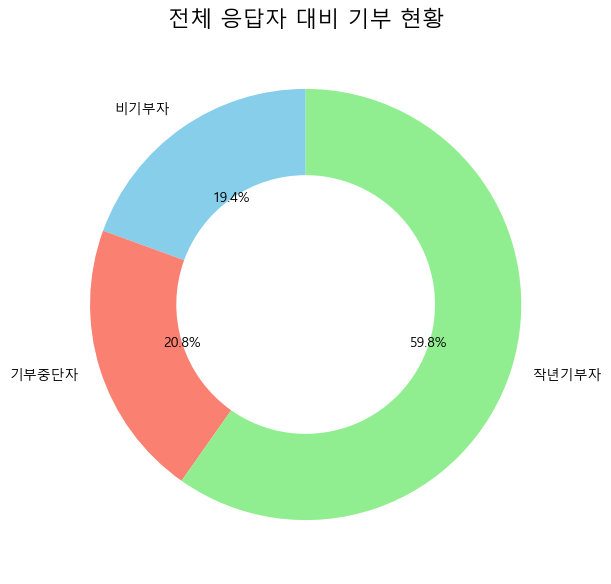

In [318]:
sizes = [486, 520, 2500-486-520]
labels = ["비기부자", "기부중단자", "작년기부자"]
colors = ["skyblue", "salmon", "lightgreen"]

plt.figure(figsize=(7,7))
plt.pie(
    sizes, 
    labels=labels, 
    autopct="%1.1f%%", 
    startangle=90, 
    colors=colors,
    wedgeprops={'width':0.4}  # 도넛 차트로 변경, 0.4는 두께 비율
)
plt.title("전체 응답자 대비 기부 현황", fontsize=16)
plt.show()

In [329]:

dup_cols=['채널','기부분야','국내의 사회복지 또는 자선 분야', '해외구호 분야', '초/중/고/대학교 교육분야', '의료분야', '문화예술분야',
       'NGO분야', '지역사회발전 분야', '기타분야', '기부관련활동','기부수준_낮은이유']
dat01=no_float.drop(dup_cols,axis=1).drop_duplicates().reset_index(drop=True)
data=pd.read_excel('C:/Users/gram/Desktop/NGO/20250703_005327.xlsx')
datum3=pd.concat([data[['문2_01','문2_03']],dat01[['기부타입']]],axis=1)

In [330]:
datum3.columns=['기부안한이유','기부중단이유','기부타입']
# 비기부자 이유
non_donor_reasons = datum3[datum3['기부타입'] == "비기부"]['기부안한이유'].value_counts()

# 기부중단자 이유
stopped_donor_reasons = datum3[datum3['기부타입'] == "기부중단"]['기부중단이유'].value_counts()
# 1) 기부하지 않은 이유 매핑
non_donation_map = {
    1: "기부에 관심이 없어서",
    2: "기부할 만한 경제적 여력이 없어서",
    3: "기부단체를 신뢰하지 못해서",
    4: "기부단체나 방법에 대한 정보가 없어서"
}

# 2) 기부중단 이유 매핑
stopped_donation_map = {
    1: "경제적 여유가 없어서",
    2: "기부하던 기간 외 다른 기관에 기부하고 싶어서",
    3: "기부하던 기관의 소통방식에 만족할 수 없어서",
    4: "기부하던 기관의 사업활동이 마음에 안 들어서",
    5: "기부하던 기관이 더 이상 나에게 기부를 요청하지 않아서",
    6: "돈으로 하는 기부 대신 자원봉사를 하고 싶어서",
    7: "내가 기부한 정도면 이미 충분하다고 생각해서",
    8: "내가 기부한다는 사실을 잊고 있어서",
    9997: "기타"
}

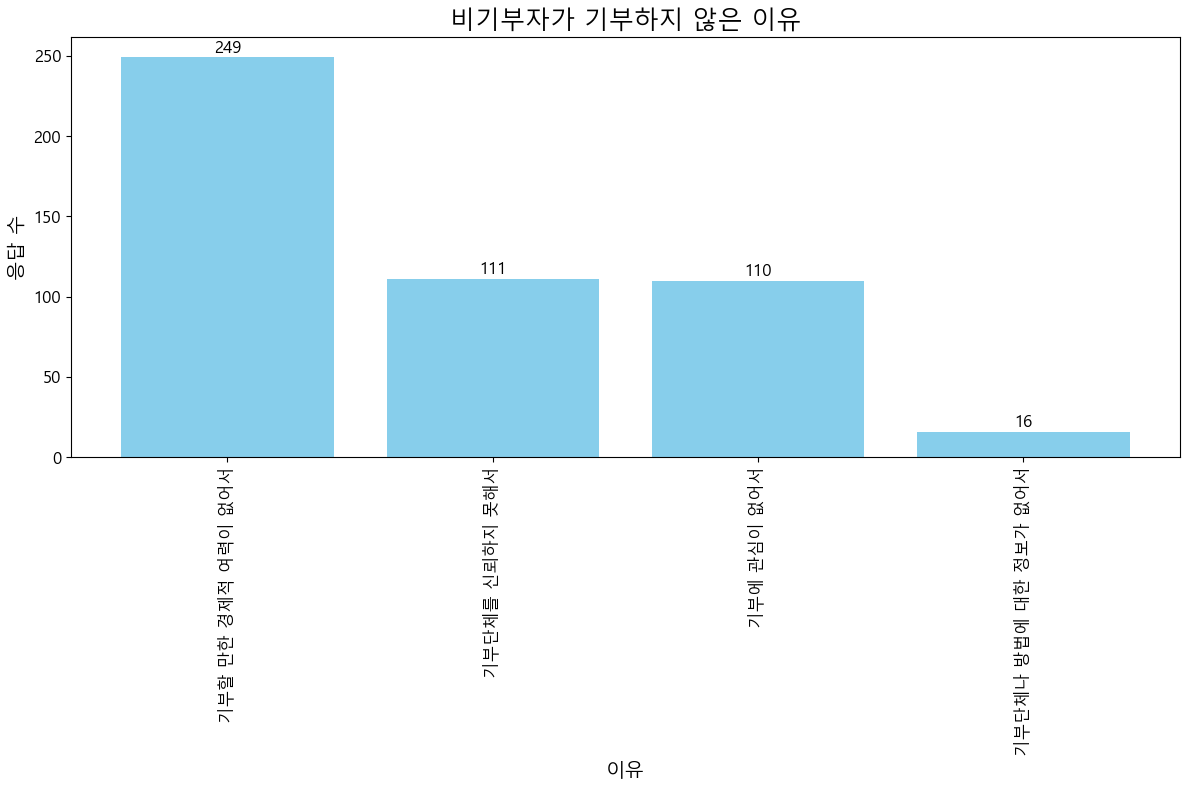

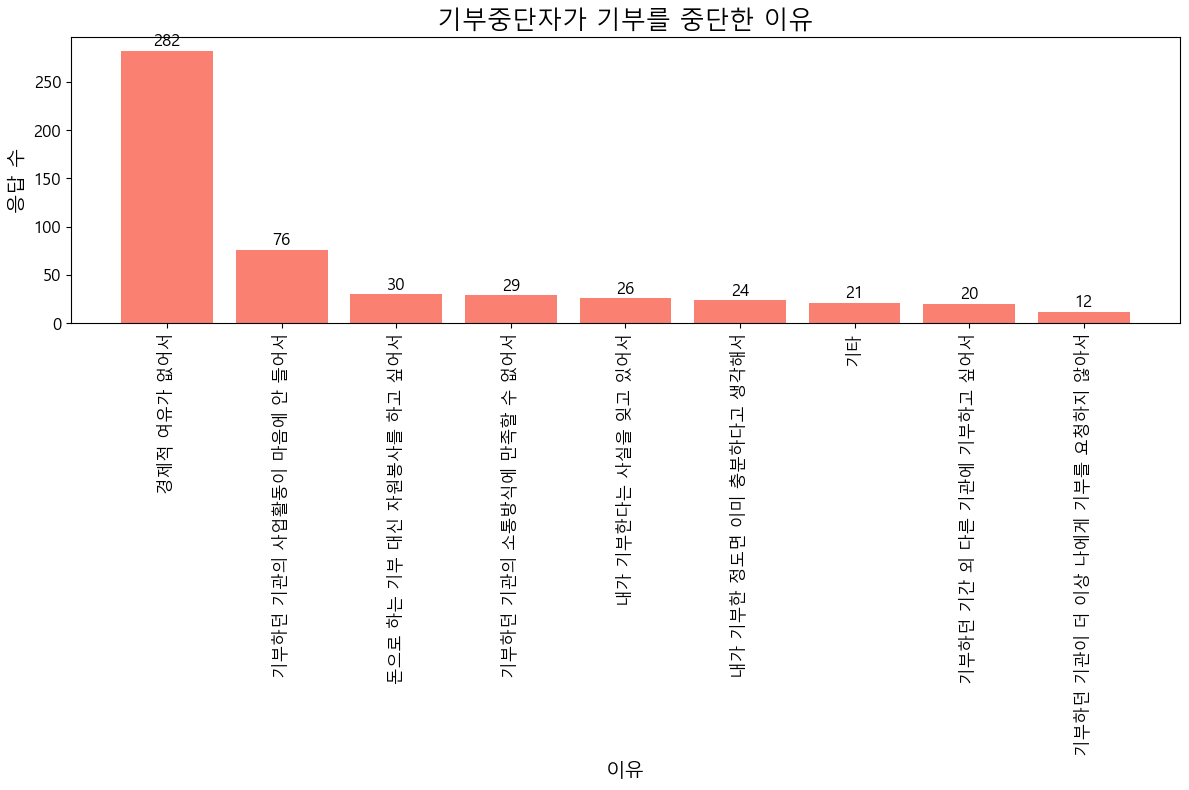

In [334]:

# -------------------------------
# -------------------------------

# -------------------------------
# 4️⃣ matplotlib로 막대그래프
# -------------------------------# -------------------------------
# 4️⃣ 색상 팔레트 생성
# -------------------------------
colors_non = cm.Blues_r(range(100, 255, int(155/len(non_donor_reasons))))
colors_stopped = cm.Reds_r(range(100, 255, int(155/len(stopped_donor_reasons))))

# -------------------------------
# 숫자형 index 문제 해결
# -------------------------------
# x값: 문자열로 변환
# x값: 문자열로 변환
x_non = non_donor_reasons.index.astype(int)
x_stopped = stopped_donor_reasons.index.astype(int)

# 매핑 적용
x_non =x_non.map(non_donation_map)
x_stopped =x_stopped.map(stopped_donation_map)
# y값
y_non = non_donor_reasons.values
y_stopped = stopped_donor_reasons.values

# -------------------------------# -------------------------------
# 1️⃣ 비기부자가 기부하지 않은 이유
# -------------------------------
plt.figure(figsize=(12,8))  # 크기 조정
bars_non = plt.bar(x_non, y_non, color='skyblue')
plt.title("비기부자가 기부하지 않은 이유", fontsize=18)
plt.xlabel("이유", fontsize=14)
plt.ylabel("응답 수", fontsize=14)
plt.xticks(rotation=90, fontsize=12)  # x축 글자 90도 + 크기 키움
plt.yticks(fontsize=12)

# 막대 위 값 표시
for bar in bars_non:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# -------------------------------
# 2️⃣ 기부중단자가 기부를 중단한 이유
# -------------------------------
plt.figure(figsize=(12,8))
bars_stopped = plt.bar(x_stopped, y_stopped, color='salmon')
plt.title("기부중단자가 기부를 중단한 이유", fontsize=18)
plt.xlabel("이유", fontsize=14)
plt.ylabel("응답 수", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# 막대 위 값 표시
for bar in bars_stopped:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [336]:
dat01['기부횟수']=dat01['정기기부_횟수']+dat01['일시기부_횟수']
income=dat01[['가구소득','기부타입','기부횟수','작년기부액']]
income['가구소득']=income['가구소득']/10000
income['작년기부액']=(income['작년기부액']/10000).astype(float)

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\1693563549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income['가구소득']=income['가구소득']/10000
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\1693563549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income['작년기부액']=(income['작년기부액']/10000).astype(float)


C:\Users\gram\AppData\Local\Temp\ipykernel_39816\3171059304.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income['기부횟수_범주'] = pd.cut(income['기부횟수'], bins=bins, labels=labels, include_lowest=True)


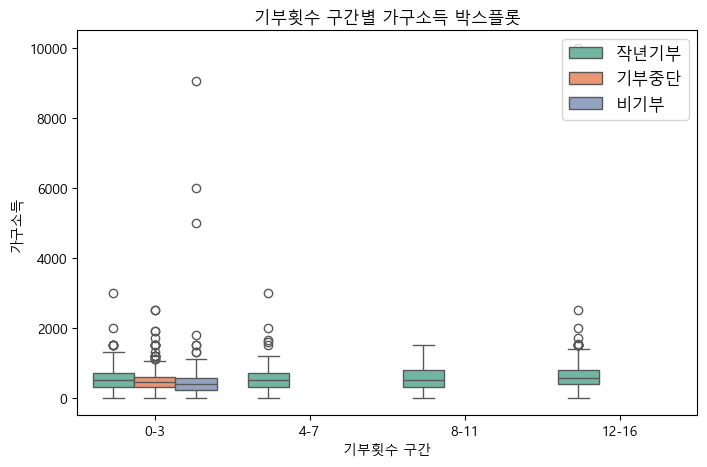

In [337]:
# 1) 기부횟수 0~16을 적당히 구간으로 나누기
bins = [0, 3, 7, 11, 16]  # 원하는 구간
labels = ["0-3", "4-7", "8-11", "12-16"]

income['기부횟수_범주'] = pd.cut(income['기부횟수'], bins=bins, labels=labels, include_lowest=True)

# 2) bin별 기부금액 박스플롯
plt.figure(figsize=(8,5))
sns.boxplot(data=income, x='기부횟수_범주', y='가구소득',    hue="기부타입",
    palette="Set2"
)
# 범례를 오른쪽 상단에 위치
plt.legend(
    loc='upper right',   # 오른쪽 상단
    bbox_to_anchor=(1, 1),  # 위치 세밀 조정 가능
    fontsize=12
)

plt.xlabel("기부횟수 구간")
plt.ylabel("가구소득")
plt.title("기부횟수 구간별 가구소득 박스플롯")
plt.show()

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\2932711884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income["income_bin"] = pd.qcut(income["작년기부액"], 10, duplicates="drop")


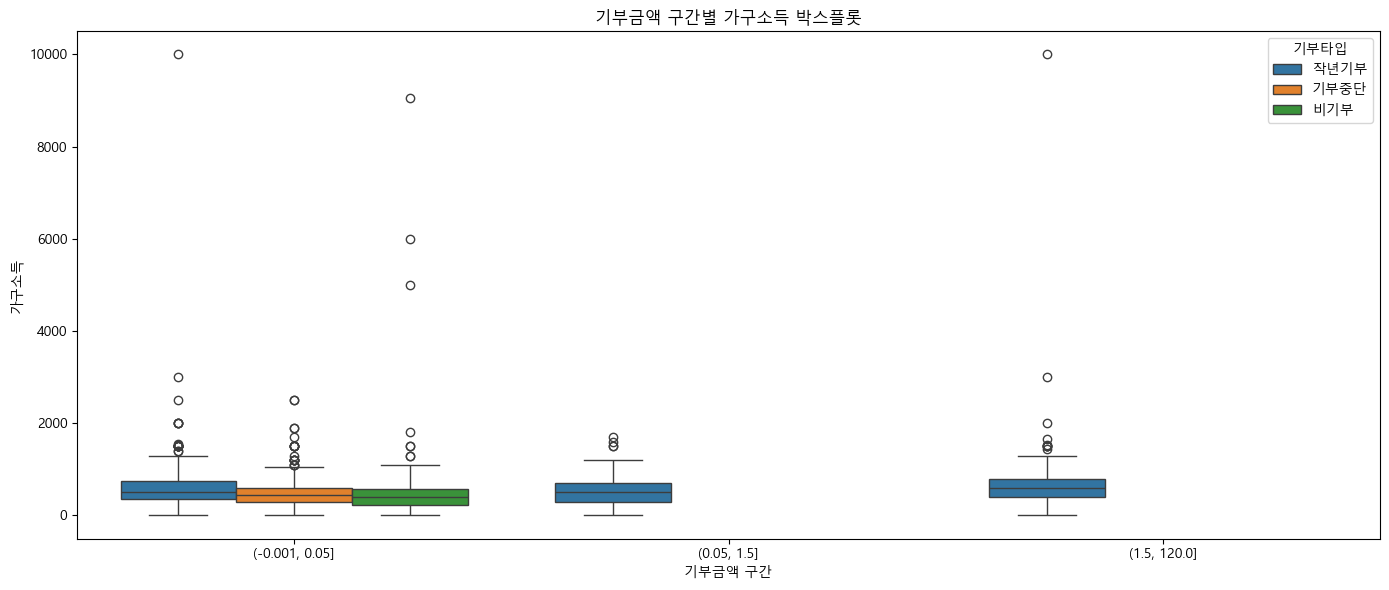

In [338]:
# 1) 가구소득 10개 bin 만들기
income["income_bin"] = pd.qcut(income["작년기부액"], 10, duplicates="drop")

# 2) 박스플롯 (x=소득 bin, y=기부금액, hue=기부타입)
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=income,
    x="income_bin",       # 범주형 (10개 구간)
    y="가구소득",          # 박스플롯의 y축
    hue="기부타입"
)

plt.title("기부금액 구간별 가구소득 박스플롯")
plt.xlabel("기부금액 구간")
plt.ylabel("가구소득")
plt.legend(title="기부타입")
plt.tight_layout()
plt.show()

# Ⅵ. 타겟팅 전략(Q23~Q25)

In [356]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)
dup_cols=['채널','기부분야','국내의 사회복지 또는 자선 분야', '해외구호 분야', '초/중/고/대학교 교육분야', '의료분야', '문화예술분야',
       'NGO분야', '지역사회발전 분야', '기타분야', '기부수준_낮은이유']
no_float['페르소나']=labels
dat10=no_float.drop(dup_cols,axis=1).drop_duplicates().reset_index(drop=True)
dat10=map_region(dat10, col_name='지역', new_col='지역')

In [358]:

# region별 기부자 비율 테이블
pivot = pd.crosstab(dat10['지역'], dat10['기부유형'], normalize='index') * 100
pivot = pivot.reset_index()
pivot["기부잠재력"] = (
    0.5 * pivot["정기기부"] +
    0.3 * pivot["일시기부"] -
    0.2 * pivot["비기부"]
)

pivot["기부취약점수"] = (
    0.6 * pivot["비기부"] -
    0.4 * pivot["정기기부"]
)
pivot.columns=['지역','비기부','일시기부','정기기부','기부잠재력','기부취약점수']
jiyeak=pd.merge(dat10,pivot[['지역','기부잠재력','기부취약점수']],on='지역',how='left')
jiyeak2=jiyeak[['지역','세대','기부잠재력','기부취약점수','페르소나','기부관련활동']]
jiyeak2["기부관련활동개수"] = jiyeak2["기부관련활동"].apply(lambda x: 0 if x == 0 else 1)
gibu_count=jiyeak2.groupby(['지역','세대','페르소나'])['기부관련활동개수'].sum().reset_index()
jiyeak3=pd.merge(jiyeak2,gibu_count,how='left',on=['지역','세대','페르소나']).drop('기부관련활동개수_x',axis=1)
jiyeak3=jiyeak3.rename(columns={'기부관련활동개수_y':'기부관련활동개수'})

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\2273836250.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jiyeak2["기부관련활동개수"] = jiyeak2["기부관련활동"].apply(lambda x: 0 if x == 0 else 1)
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\2273836250.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gibu_count=jiyeak2.groupby(['지역','세대','페르소나'])['기부관련활동개수'].sum().reset_index()


In [361]:

persona_score_map = {
    0: 0.2,
    1: 0.8,
    2: 0.3,
    3: 1
}

jiyeak2["페르소나점수"] = jiyeak2["페르소나"].map(persona_score_map)
# 변수 선택
cols = ["기부잠재력", "기부취약점수", "기부관련활동개수",'페르소나점수']

# MinMax Scaling
scaler = MinMaxScaler()
scaled =jiyeak2[cols]

scaled=scaler.fit_transform(scaled)
df_scaled = pd.DataFrame(scaled, columns=[c + "_scaled" for c in cols])
df = pd.concat([jiyeak2, df_scaled], axis=1)

# -------------------------------
# ① 변수 방향성 맞추기 (타겟점수 높을수록 타겟)
# -------------------------------

# 기부잠재력: 낮을수록 타겟 → 역방향
df["기부잠재력_inv"] = 1 - df["기부잠재력"]

# 기부취약점수: 높을수록 타겟 → 정방향 유지
df["기부취약점수_pos"] = df["기부취약점수"]

# 기부관련활동: 낮을수록 타겟 → 역방향
df["기부관련활동_inv"] = 1 - df["기부관련활동개수"]

# -------------------------------
# ② 최종 타겟점수 계산 (가중치는 자유롭게 조정 가능)
# -------------------------------
# -----------------------------------
# ③ 가중치 설정
# -----------------------------------
w1, w2, w3, w4 = 0.35, 0.35, 0.25, 0.05   # 페르소나 가중치를 w4로 추가

# -----------------------------------
# ④ 최종 타겟점수 계산
# -----------------------------------
df["타겟점수"] = (
    df["기부잠재력_inv"] * w1 +
    df["기부취약점수_pos"] * w2 +
    df["기부관련활동_inv"] * w3 +
    df["페르소나점수"] * w4
)

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\146448327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jiyeak2["페르소나점수"] = jiyeak2["페르소나"].map(persona_score_map)


In [369]:
# 타겟 점수 계산 (기부취약 - 기부잠재력)


# 우선순위 정렬
jiyeak3 = df.sort_values('타겟점수', ascending=True).reset_index(drop=True)
# 매핑 딕셔너리
persona_map = {
    0: '사회구호형',
    1: '기부소극층',
    2: '문화고액형',
    3: '무관심층'
}

jiyeak3_idx=jiyeak3.groupby(['지역'])['타겟점수'].idxmax()
result = jiyeak3.loc[jiyeak3_idx].reset_index(drop=True)
df_rep2=result.copy()

# 매핑 적용
df_rep2['페르소나'] = df_rep2['페르소나'].map(persona_map)

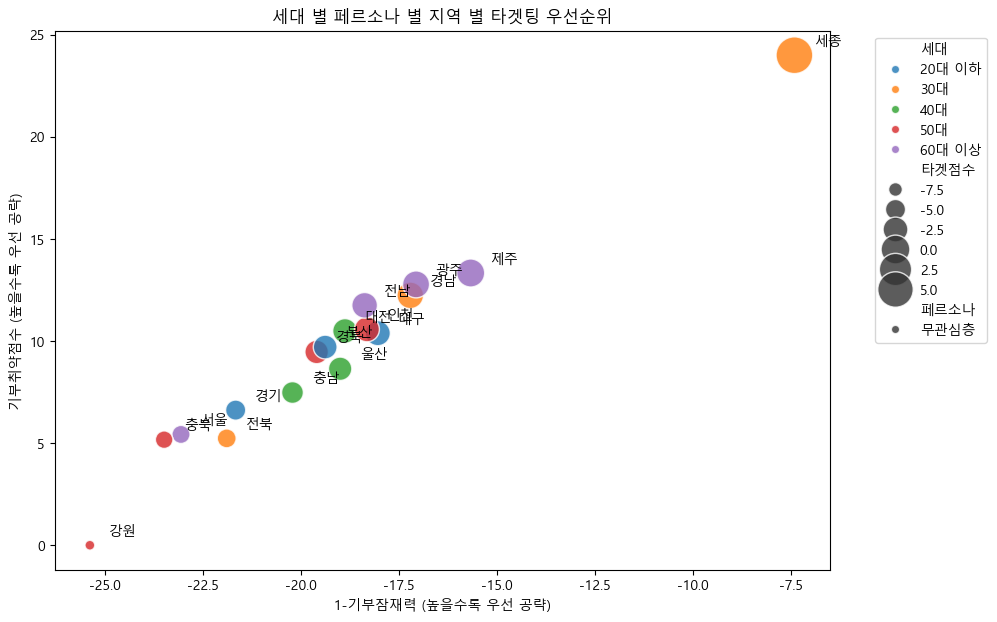

In [373]:
plt.figure(figsize=(10,7))
#plt.figure(figsize=(10,7))
sns.scatterplot(
    data=df_rep2 ,
    x='기부잠재력_inv',
    y='기부취약점수_pos',
    hue='세대',          # 색상으로 세대 구분
    style='페르소나',    # 마커 모양으로 페르소나 구분
    size='타겟점수',     # 점 크기로 우선순위 표시
    sizes=(50, 700),
    palette='tab10',
    alpha=0.8
)

# 지역 라벨 표시
for i in range(df_rep2.shape[0]):
    plt.text(df_rep2['기부잠재력_inv'][i]+0.5, df_rep2['기부취약점수_pos'][i]+0.5, df_rep2['지역'][i])

plt.title("세대 별 페르소나 별 지역 별 타겟팅 우선순위")
plt.xlabel("1-기부잠재력 (높을수록 우선 공략)")
plt.ylabel("기부취약점수 (높을수록 우선 공략)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [466]:
dup_cols=['기부분야','국내의 사회복지 또는 자선 분야', '해외구호 분야', '초/중/고/대학교 교육분야', '의료분야', '문화예술분야',
       'NGO분야', '지역사회발전 분야', '기타분야', '기부수준_낮은이유']
dat10=no_float.drop(dup_cols,axis=1).drop_duplicates().reset_index(drop=True)
dat10=map_region(dat10, col_name='지역', new_col='지역')
channel2=dat10[['지역','페르소나','세대','채널','기부관련활동']]

In [467]:
# 매핑 딕셔너리
persona_map = {
    0: '사회구호형',
    1: '기부소극층',
    2: '문화고액형',
    3: '무관심층'
}
channel2['페르소나'] = channel2['페르소나'].map(persona_map)
channel3=channel2.groupby(['지역','페르소나','세대'])[['채널','기부관련활동']].agg(list).reset_index()
df_rep3=pd.merge(df_rep2[['지역','세대','페르소나','타겟점수']],channel3,how='left',on=['지역','페르소나','세대'])
df_rep3=df_rep3.drop('기부관련활동',axis=1)
df = df_rep3.explode("채널")
#df=df.drop_duplicates().reset_index(drop=True)
#df2=df.drop('채널',axis=1).drop_duplicates().reset_index(drop=True)

C:\Users\gram\AppData\Local\Temp\ipykernel_39816\2232811118.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel2['페르소나'] = channel2['페르소나'].map(persona_map)
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\2232811118.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  channel3=channel2.groupby(['지역','페르소나','세대'])[['채널','기부관련활동']].agg(list).reset_index()


In [ ]:
#dat10=dat10[dat10['채널']!=0].reset_index(drop=True)
#dap=dat10.groupby(['지역','페르소나','세대'])['채널'].agg(list).reset_index()
#dap['페르소나'] = dap['페르소나'].map(persona_map)
#dap2=pd.merge(df,dap,on=['지역','세대','페르소나'],how='left').reset_index(drop=True)
## ▼ 채널 1개씩 분해
## ▼ 채널이 문자열("A, B, C")이면 리스트로 변환
#df=dap2.copy()


C:\Users\gram\AppData\Local\Temp\ipykernel_39816\1470494389.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  divi2=divi.groupby(['지역', '세대', '페르소나','채널']).size().reset_index(name='count')


C:\Users\gram\AppData\Local\Temp\ipykernel_39816\3998850713.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  divi2=divi.groupby(['지역', '세대', '페르소나','채널']).size().reset_index(name='count')
C:\Users\gram\AppData\Local\Temp\ipykernel_39816\3998850713.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = divi3.pivot_table(


<Figure size 1600x1200 with 0 Axes>

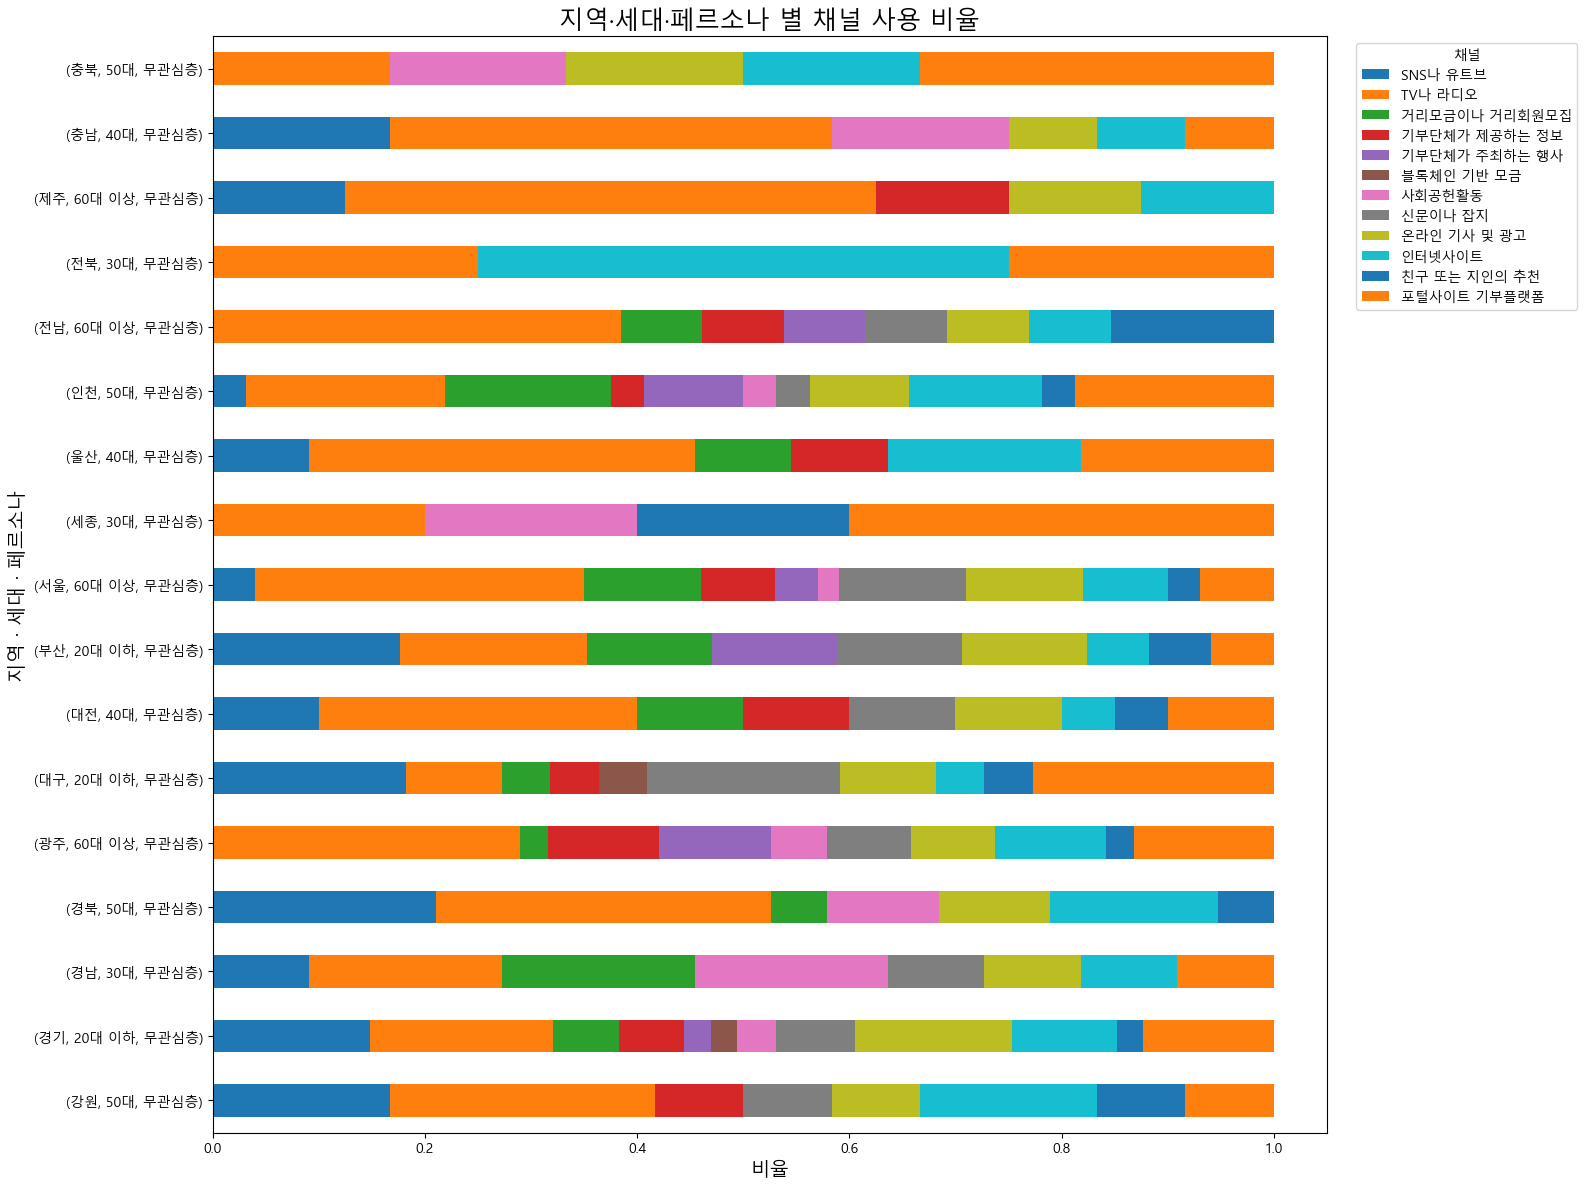

In [551]:
divi=df[df['채널']!=0].reset_index()
divi2=divi.groupby(['지역', '세대', '페르소나','채널']).size().reset_index(name='count')
divi2=divi2[divi2['count']!=0].reset_index()
divi3=divi2[divi2['count']!=0].reset_index()
pivot = divi3.pivot_table(
    index=['지역', '세대','페르소나'],
    columns='채널',
    values='count',
    aggfunc='sum',
    fill_value=0
)


# ▼ 비율 계산 (각 지역–세대 내부에서 normalize)
ratio = pivot.div(pivot.sum(axis=1), axis=0)

# -------------------------------
#       Stacked Bar Plot
# -------------------------------
# NaN 포함된 행 제거 (즉, 결측치가 하나라도 있으면 제거)
pivot_clean = ratio.dropna(how="any")
plt.figure(figsize=(16, 12))   # 크기 크게 설정

pivot_clean.plot(
    kind='barh',          # 가로 막대
    stacked=True,
    figsize=(16, 12)
)

plt.title("지역·세대·페르소나 별 채널 사용 비율", fontsize=18)
plt.xlabel("비율", fontsize=14)
plt.ylabel("지역 · 세대 · 페르소나", fontsize=14)
plt.legend(title="채널", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [546]:
no_float=pd.read_csv('C:/Users/gram/Desktop/NGO/final.csv')
dat10=map_region(no_float, col_name='지역', new_col='지역')
dat10["올해기부의향"] = (
    dat10["올해기부의향"]
    .str.strip()
    .replace({
        "기부의향 없음": "없음",
        "기부의향 있음": "있음"
    })
)
dat10['전환구분'] = dat10.apply(classify_conversion, axis=1)
dat10=dat10.dropna().reset_index(drop=True)
inval=dat10.copy()

In [547]:
cat_cols = ['성별','지역','혼인상태', '자녀여부', '종교', '고용상태','소득변화', '학벌','기부동기','단체선정기준','올해기부의향'
            ,'정보요청','관심표현','기부수준인식','상한선이유','상한선배제이유','추가지출여부_행정비용','추가지출여부_성과측정'	,'추가지출여부_IT비용'
            ,'자원봉사여부','고향사랑기부제여부','고향사랑기부제_사용여부','고향사랑기부제_영향력','종교기부여부','기부유형','세대','소득수준','기부타입',
            '기부노력시간','기부단체효과성','전환구분']+dup_cols
for col in cat_cols:
    
    # 1) 값 종류가 2개인 경우: 2 → 0
    if inval[col].nunique() == 2 and 2 in inval[col].unique():
        inval[col] = inval[col].replace(2, 0)
    
    # 2) 숫자 0과 한글 문자열이 섞여 있으면: 숫자 0 → '0'
    uniques = inval[col].unique()
    # 숫자 0이 있고, 문자열(한글)이 있으면 변환
    if any(isinstance(x, str) for x in uniques) and 0 in uniques:
        inval[col] = inval[col].replace(0, '0')
for col in cat_cols:
    le = LabelEncoder()
    inval[col] = le.fit_transform(inval[col])


In [549]:
# -------------------------
# 1. 데이터 로드 (예시)
# -------------------------
# df = pd.read_csv("donation.csv")  # 형태: features + target(기부의향)
target_col = "전환구분"     # 타깃 변수명 예시

X = inval.drop([target_col]+['기부타입','올해기부의향'],axis=1)

y = inval['전환구분']

# -------------------------
# 3. Train/Test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# 5. LightGBM 학습
# -------------------------
model = lgb.LGBMClassifier(
     objective='binary',
    pos_label=1,     # ← positive class 강제 지정!!
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    random_state=42
)
remove_cols = ['올해기부의향', '기부타입', '전환구분']
cat_colss = [col for col in cat_cols if col not in remove_cols]
model.fit(X_train, y_train,    categorical_feature=cat_colss)

# --------------------
# 3. Feature Importance 추출

[LightGBM] [Warning] Unknown parameter: pos_label
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: pos_label
[LightGBM] [Info] Number of positive: 709, number of negative: 1909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 483
[LightGBM] [Info] Number of data points in the train set: 2618, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.270817 -> initscore=-0.990479
[LightGBM] [Info] Start training from score -0.990479


LGBMClassifier(learning_rate=0.05, n_estimators=500, objective='binary',
               pos_label=1, random_state=42)

In [555]:


# 1) 예측 확률 & 예측 클래스
y_pred_proba = model.predict_proba(X_test)[:, 1] 
y_pred = model.predict(X_test)

# 2) Accuracy / F1 / AUC
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)  # 문자열로 지정
auc = roc_auc_score((y_test == '전환가능군').astype(int), y_pred_proba)

print("🔍 Test Performance")
print(f"✔ Accuracy     : {acc:.4f}")
print(f"✔ F1 Score     : {f1:.4f}")
print(f"✔ ROC-AUC      : {auc:.4f}")

# 3) Classification report
print("\n📌 Classification Report")
print(classification_report(y_test, y_pred))

# 4) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=['Actual 비전환', 'Actual 전환'],
                     columns=['Pred 비전환', 'Pred 전환'])
print("\n📌 Confusion Matrix")
print(cm_df)

[LightGBM] [Warning] Unknown parameter: pos_label
[LightGBM] [Warning] Unknown parameter: pos_label
🔍 Test Performance
✔ Accuracy     : 0.9740
✔ F1 Score     : 0.9516
✔ ROC-AUC      : nan

📌 Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       477
           1       0.97      0.94      0.95       178

    accuracy                           0.97       655
   macro avg       0.97      0.96      0.97       655
weighted avg       0.97      0.97      0.97       655


📌 Confusion Matrix
            Pred 비전환  Pred 전환
Actual 비전환       471        6
Actual 전환         11      167


c:\Users\gram\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


c:\Users\gram\anaconda3\envs\torch\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


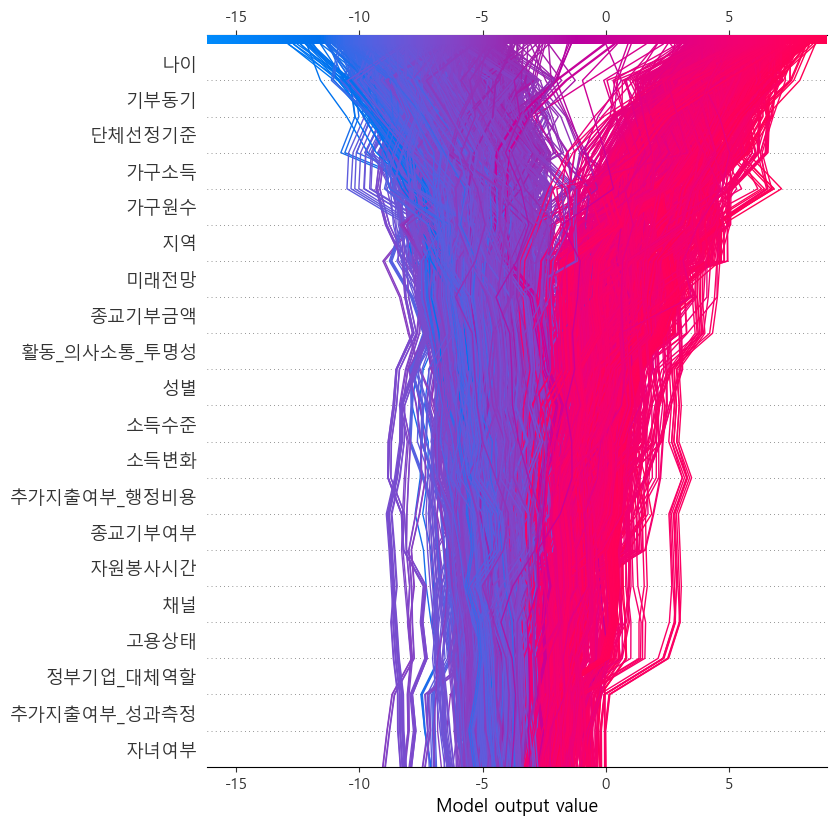

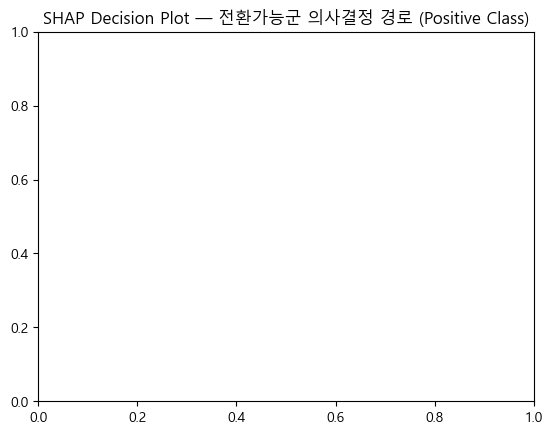

In [556]:
# 1) SHAP 값 생성
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X)   # shape: (N, F)
base_val = explainer.expected_value         # scalar

# 2) numpy 변환 (가장 안전한 방식)
X_np = X.values
feat_names = X.columns.tolist()

# 3) 전환가능군 샘플만 선택 (원하면 전체도 가능)
# 예: y_test == 1인 샘플만
X_sub = X_np
shap_sub = shap_vals

# 4) Decision Plot
plt.figure(figsize=(14, 6))
shap.decision_plot(
    base_val,
    shap_sub,
    X_sub,
    feature_names=feat_names,
    highlight=0,  # 첫 번째 전환케이스 강조
    ignore_warnings=True
)
plt.title("SHAP Decision Plot — 전환가능군 의사결정 경로 (Positive Class)")
plt.show()

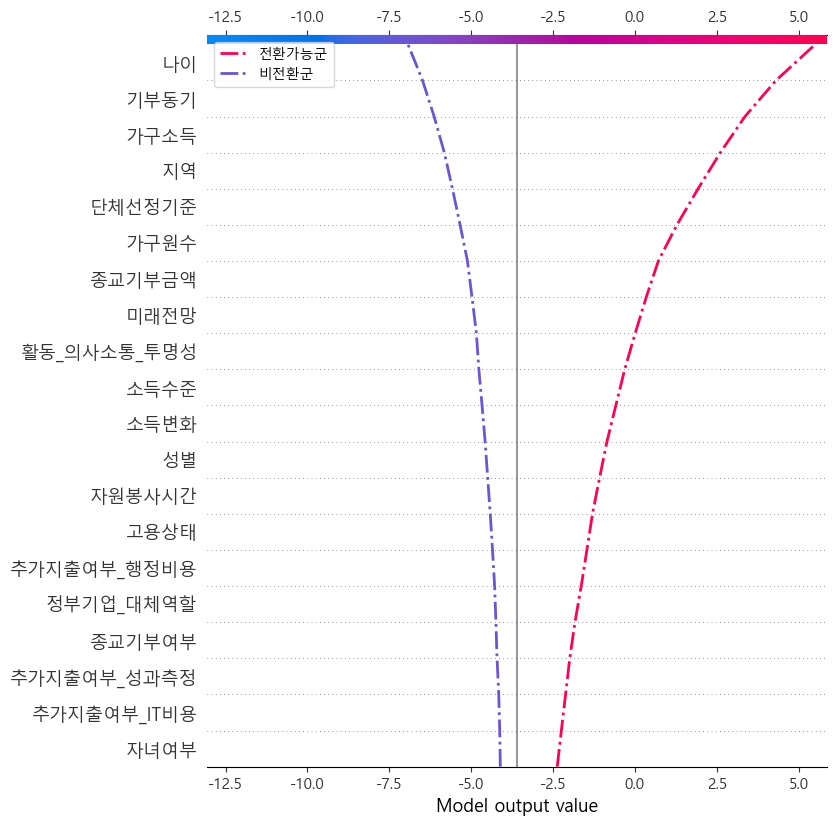

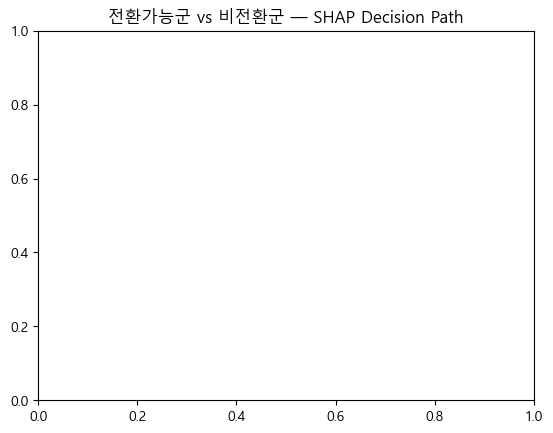

In [565]:
explainer = shap.TreeExplainer(
    model)
# 3) SHAP 값 계산
shap_values = explainer(X)
# 1) 두 집단 인덱스
idx_conv = inval[inval["전환구분"] == 1].index
idx_non  = inval[inval["전환구분"] == 0].index

# 2) 두 집단 SHAP 평균 (1 x n_features)
conv_mean = shap_values.values[idx_conv].mean(axis=0)       # shape (n_features,)
non_mean  = shap_values.values[idx_non].mean(axis=0)        # shape (n_features,)

# 3) 2줄로 붙여서 (2 x n_features) 만들기
shap_2line = np.vstack([conv_mean, non_mean])

# 4) features도 같은 shape으로 맞추기 (평균값 복제)
feat_mean = X.mean(axis=0).values              # (n_features,)
feat_2line = np.vstack([feat_mean, feat_mean])       # (2 x n_features)

# 5) feature names
feat_names = X.columns.tolist()
plt.close('all')
# 6) SHAP decision plot
shap.decision_plot(
    base_value=explainer.expected_value,     # 스칼라
    shap_values=shap_2line,                  # (2 x n_features)
    features=feat_2line,                     # 동일 shape
    feature_names=feat_names,
    highlight=[0, 1],                        # 두 줄 모두 표시
    legend_labels=["전환가능군", "비전환군"],
    ignore_warnings=True,
)
plt.title("전환가능군 vs 비전환군 — SHAP Decision Path")
plt.show()